# LCE per PMT

In [1]:
## Check Python version:
!python -V
## Check ROOT version:
!which root

Python 3.7.3


In [2]:
## Imports:

import sys
import glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec            # to arrange the plots nicely
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence
import random

In [3]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

from math import log10, floor
def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## Properties PMTs

<img src="../../Technical_Drawings_and_Data_Sheets/PMTs/pmts_verbessert.png" alt="pmts_verbessert.png" style="width: 700px;"/>

In [5]:
PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

PMT_ID  PMT_position_x  PMT_position_y  PMT_position_R  PMT_position_Phi
1       1           -14.0           -28.0       31.304952         -2.034444
2       2           -28.0             0.0       28.000000          3.141593
3       3           -14.0            28.0       31.304952          2.034444
4       4            14.0            28.0       31.304952          1.107149
5       5            28.0             0.0       28.000000          0.000000
6       6            14.0           -28.0       31.304952         -1.107149
7       7             0.0             0.0        0.000000          0.000000

In [6]:
R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

## Imports and data porcessing

In [7]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
#! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/LCE
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/LCE

ls: cannot access '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE': No such file or directory
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_10.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_1.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_2.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_3.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_4.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_5.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_6.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_7.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_8.root
optPhot_S1_1.0e+05_pmtGap0.0_RPTFE0.95_LXeAbs100_Tmesh0.89770509_nop_1.0e+04_9.root
optPhot_S1_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_no

In [8]:
## Selection of file to be analyzed:
#filename_list = ['/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root']
#filename_list = glob.glob("/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")
filename_list = glob.glob("/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_2.5e+03_*.root")

if len(filename_list) == 1:    
    filename = filename_list[0]  
else:   
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'
 
    
if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]

elif filename[6:25] == 'Simulation_Data/Mod':
    filenameprefix = filename[:-5][44:]

elif filename[6:25] == 'Simulation_Data/LCE':
    filenameprefix = filename[:-5][26:]

elif filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][45:]

elif filename[:63] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][63:]

elif filename[:70] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][70:]

elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][44:]

elif filename[:62] == '/media/alex/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][62:]

elif filename[:69] == '/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][69:]

else:
    filenameprefix = 'filenameprefix'
    
print(filenameprefix)

optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_2.5e+03


In [9]:
type(filename)

str

In [10]:
## Import as pandas dataframes

import pandas as pd

branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    print('.', end = '')
print('\n')
    
if filenameprefix.find('nop') > 0:
    nop_string = filenameprefix[(filenameprefix.find('nop')+4) : (filenameprefix.find('+', filenameprefix.find('nop')+4)+3)]
    exec('nop = '+nop_string)
    print('nop = '+str(nop))
    _chunk_collect['nbpmthits'] = _chunk_collect['nbpmthits'] / nop
    _chunk_collect['ntpmthits'] = _chunk_collect['ntpmthits'] / nop
    _chunk_collect['pmthits'] = _chunk_collect['pmthits'] / nop
else:
    print('Error: Number of particles per event = 1!')

....................................................................................................

nop = 2500.0


In [11]:
## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(0,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')

0 1 2 3 4 5 6 7 

In [12]:
## Total PMT hits
_chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)
_chunk_collect['napmthits'].shape

(10000000,)

In [13]:
_chunk_collect.head(6)

xp_pri     yp_pri    zp_pri  nbpmthits  ntpmthits  \
0  24.724848   8.700320  2.598857     0.1392     0.1280   
1  18.361572   4.089008  4.635953     0.1300     0.1408   
2  15.958376  28.599548  4.930703     0.1368     0.1132   
3  27.050507  19.127470  4.275898     0.1328     0.1144   
4  11.416049 -17.677778  4.150400     0.1492     0.1260   
5  13.215602  22.885763  3.860679     0.1380     0.1312   

                                             pmthits  pmthits_0  pmthits_1  \
0  [0.1392, 0.004, 0.0024, 0.0048, 0.0232, 0.066,...     0.1392     0.0040   
1  [0.13, 0.0052, 0.0044, 0.0052, 0.0216, 0.072, ...     0.1300     0.0052   
2  [0.1368, 0.0016, 0.0028, 0.0112, 0.0668, 0.014...     0.1368     0.0016   
3  [0.1328, 0.0052, 0.0076, 0.0076, 0.042, 0.0352...     0.1328     0.0052   
4  [0.1492, 0.012, 0.0052, 0.006, 0.0032, 0.016, ...     0.1492     0.0120   
5  [0.138, 0.0024, 0.0052, 0.014, 0.0688, 0.0224,...     0.1380     0.0024   

   pmthits_2  pmthits_3  pmthits_4  pmthits_5  pmthits_6  pmthits_7  napmthits  
0     0.0024     0.0048     0.0232     0.0660     0.0096     0.0180     0.2672  
1     0.0044     0.0052     0.0216     0.0720     0.0080     0.0244     0.2708  
2     0.0028     0.0112     0.0668     0.0148     0.0056     0.0104     0.2500  
3     0.0076     0.0076     0.0420     0.0352     0.0060     0.0108     0.2472  
4     0.0052     0.0060     0.0032     0.0160     0.0576     0.0260     0.2752  
5     0.0052     0.0140     0.0688     0.0224     0.0036     0.0148     0.2692

## Photons per PMT histograms

(7, 82)
(7, 82)


PMT1  \
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 1.000896, 9.325376, 15.154727999999993, ...   

                                                                  PMT2  \
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.252792, 4.162888, 11.637703999999996, ...   

                                                                  PMT3  \
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.996296, 9.326552, 15.173767999999994, ...   

                                                                  PMT4  \
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 1.000928, 9.338216, 15.179599999999994, ...   

                                                                  PMT5  \
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.252352, 4.178008, 11.627799999999995, ...   

                                                                  PMT6  \
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.999544, 9.327984, 15.164215999999994, ...   

                                                                  PMT7  
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...  
hist_HF_n            [0.0, 0.0, 8e-06, 0.0002799999999999999, 0.008...

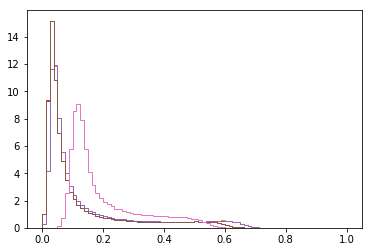

In [14]:
n_list = []
bins_center_list = []

for i in range(1,8):
    n, bins, *patches = plt.hist(
        eval("np.array(_chunk_collect['pmthits_"+str(i)+"']/_chunk_collect['ntpmthits'])"), 
        bins = 80, density = True, range = (0,1), histtype='step')
    bins_center = (bins[1:] + bins[:-1])/2
    
    n = np.concatenate((np.array([0]), n, np.array([0])))
    bins_center = np.concatenate((np.array([2*bins_center[0]-bins_center[1]]), bins_center, np.array([2*bins_center[-1]-bins_center[-2]])))
    
    n_list.append(n)
    bins_center_list.append(bins_center)

try:
    df = df.drop(index = ['hist_HF_n', 'hist_HF_bins_center'])
except:
    pass

print((np.array(n_list)).shape)
print((np.array(bins_center_list)).shape)

d = {'PMT1': [bins_center_list[0], n_list[0]], 'PMT2': [bins_center_list[1], n_list[1]], 
'PMT3': [bins_center_list[2], n_list[2]], 'PMT4': [bins_center_list[3], n_list[3]], 
'PMT5': [bins_center_list[4], n_list[4]], 'PMT6': [bins_center_list[5], n_list[5]], 
'PMT7': [bins_center_list[6], n_list[6]]}
df = pd.DataFrame(data=d, index = ['hist_HF_bins_center', 'hist_HF_n'])

df.to_pickle(filenameprefix+"_AFT_hist.pkl")    
df

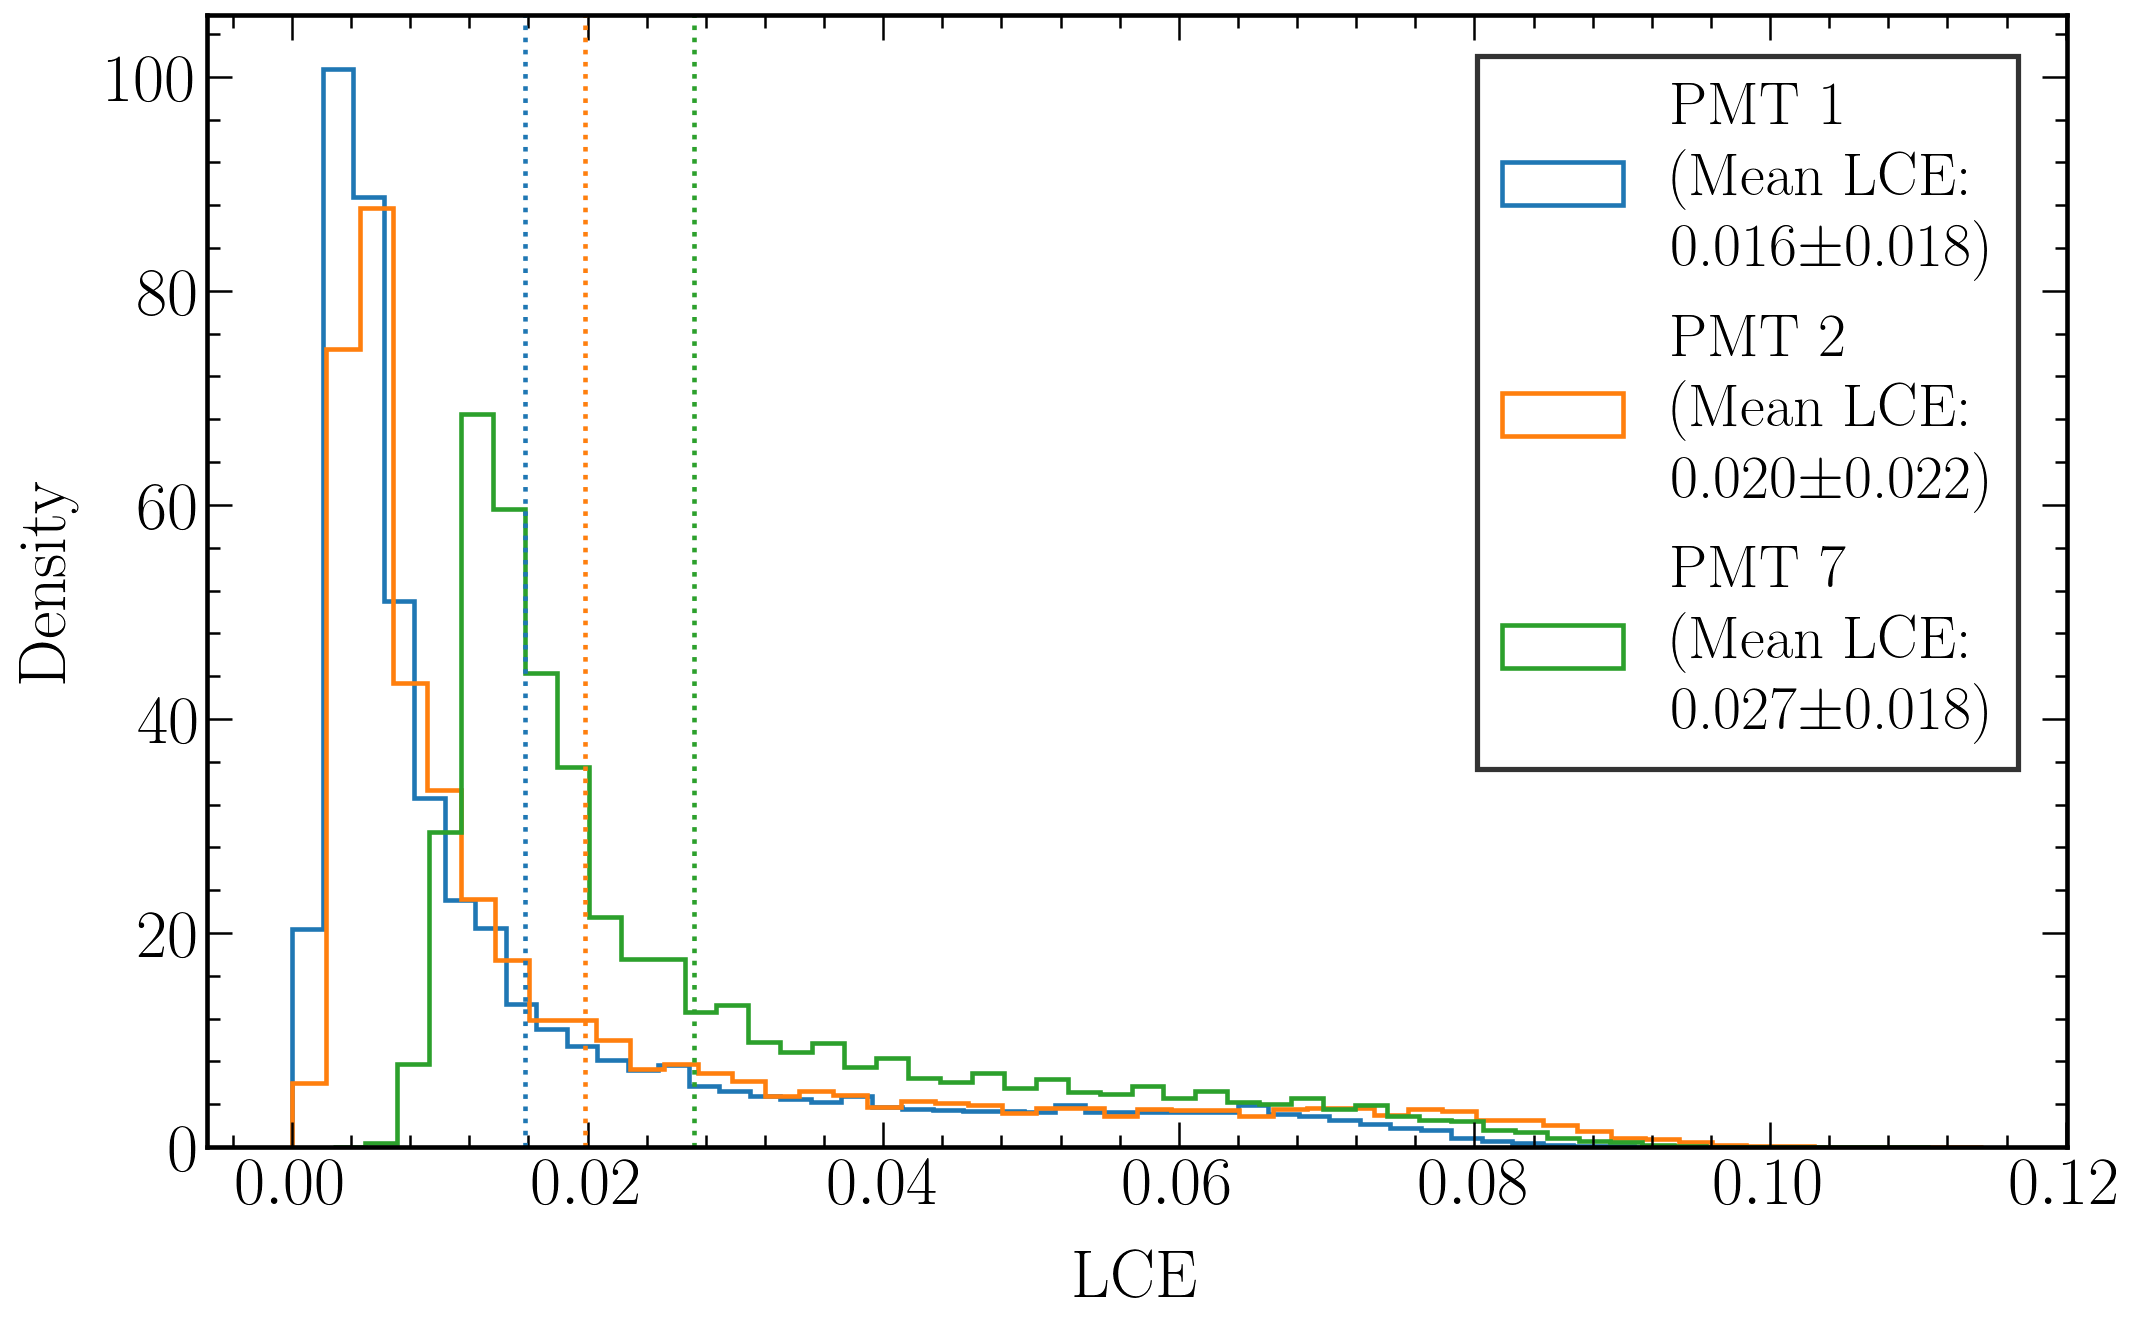

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', 
         label = "PMT 1\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_1'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_1'].std(), 2))+")")
plt.axvline(x=_chunk_collect['pmthits_1'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C1', 
         label = "PMT 2\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_2'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_2'].std(), 2))+")")
plt.axvline(x=_chunk_collect['pmthits_2'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C2', 
         label = "PMT 7\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_7'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_7'].std(), 2))+")")
plt.axvline(x=_chunk_collect['pmthits_7'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT127_hist.png")
plt.show()

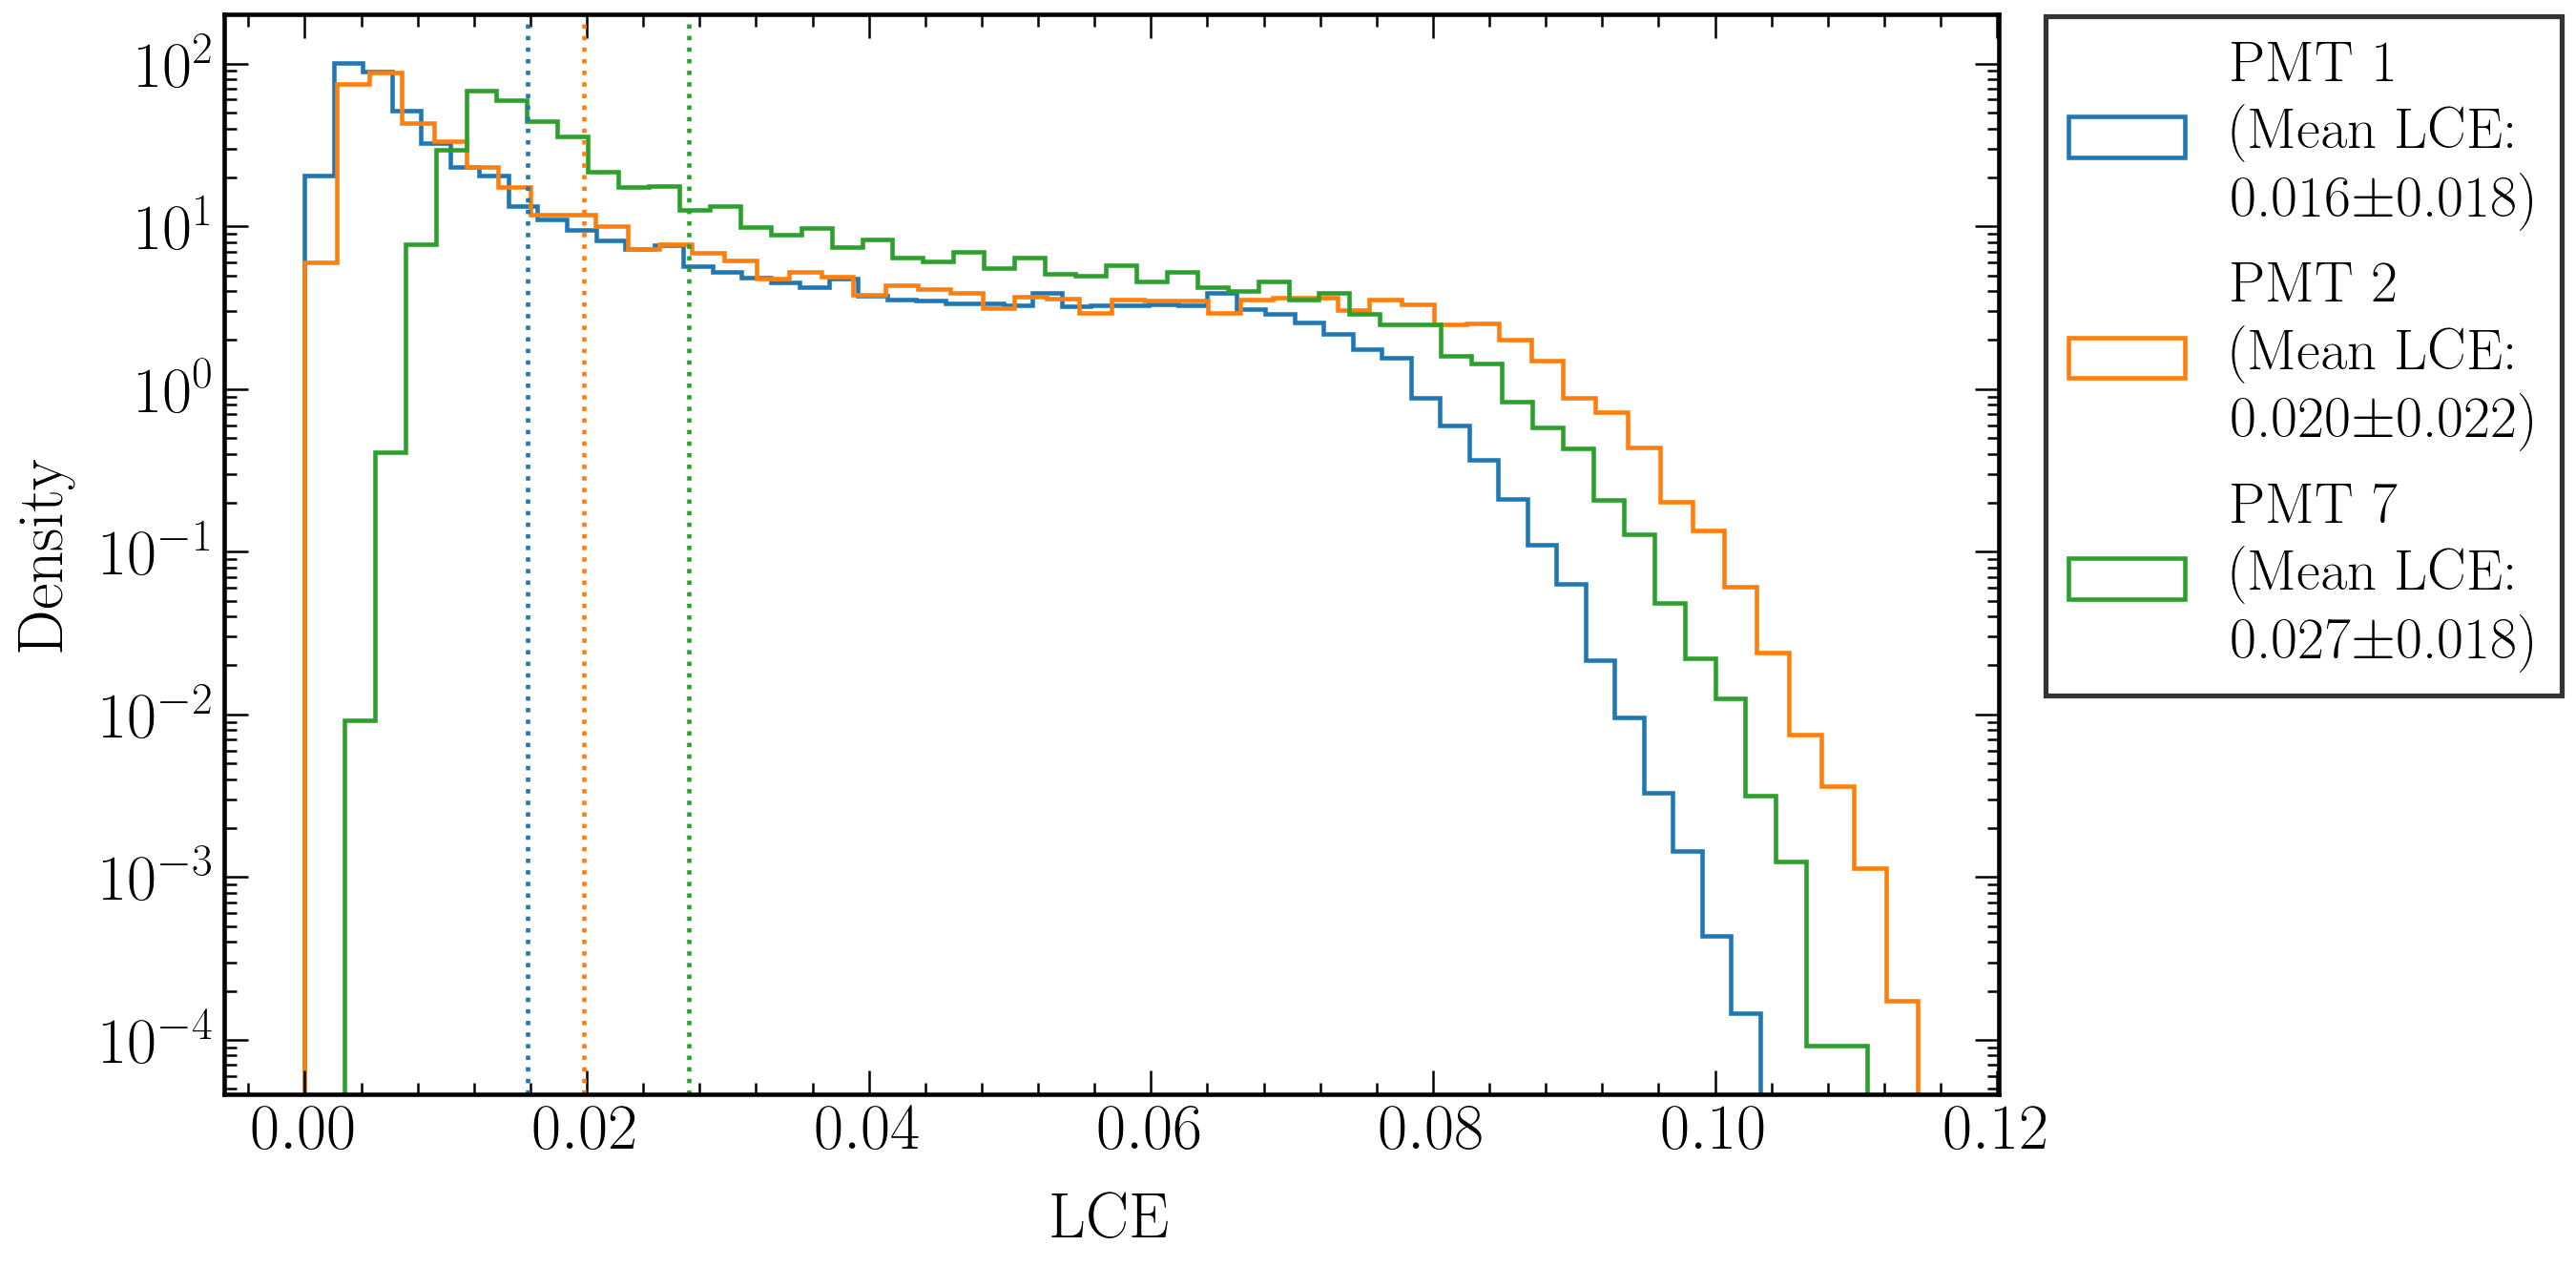

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', 
         label = "PMT 1\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_1'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_1'].std(), 2))+")")
plt.axvline(x=_chunk_collect['pmthits_1'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C1', 
         label = "PMT 2\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_2'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_2'].std(), 2))+")")
plt.axvline(x=_chunk_collect['pmthits_2'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C2', 
         label = "PMT 7\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_7'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['pmthits_7'].std(), 2))+")")
plt.axvline(x=_chunk_collect['pmthits_7'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT127_hist_log.png", bbox_inches='tight')
plt.show()

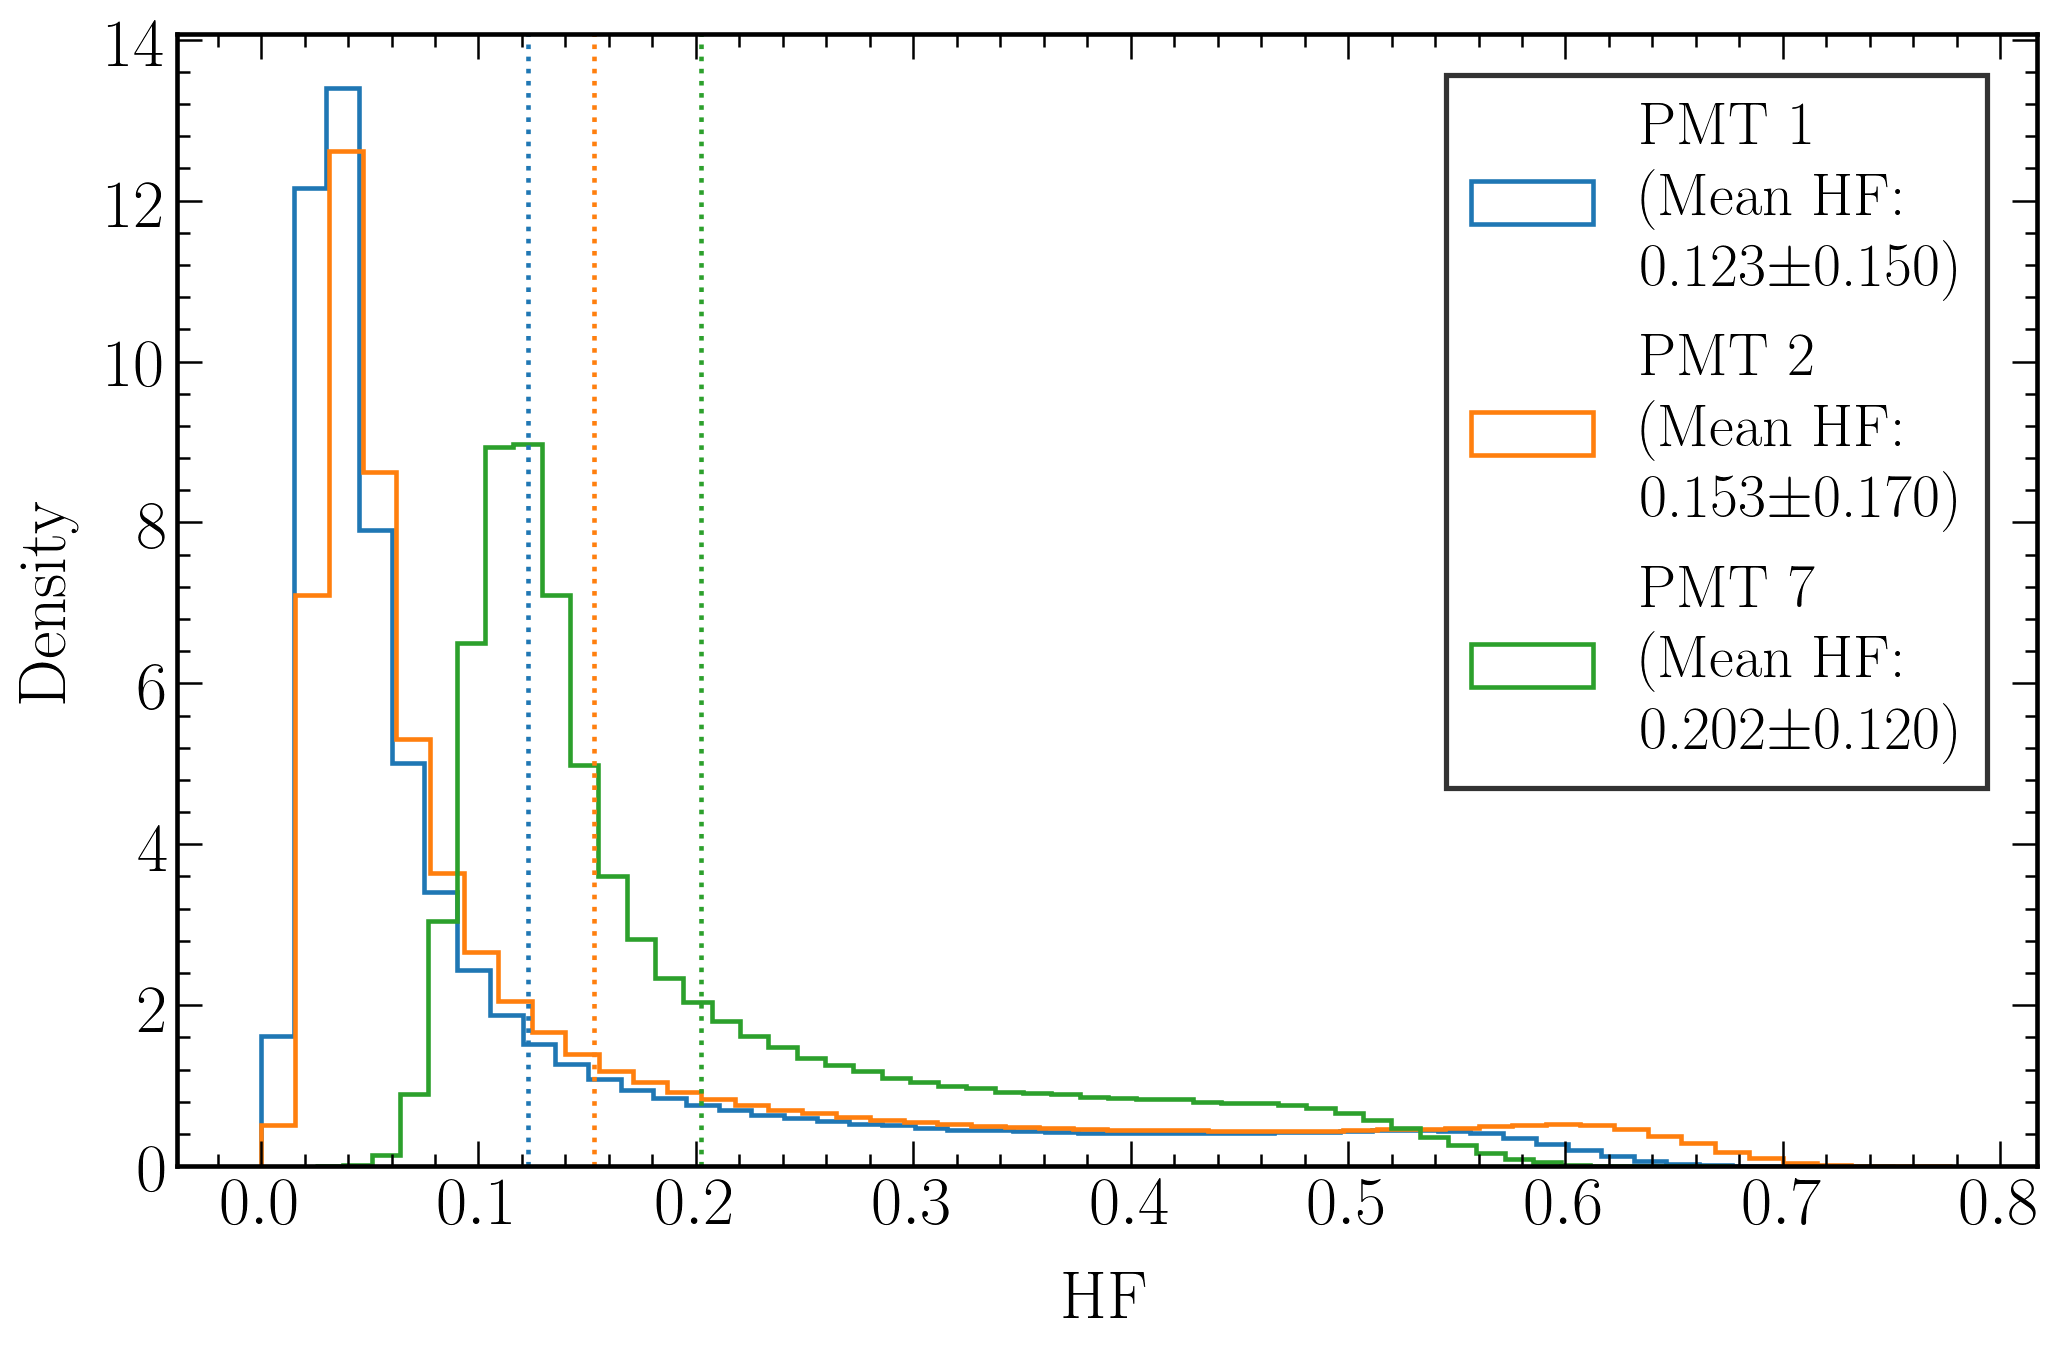

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C0', 
         label = "PMT 1\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C1', 
         label = "PMT 2\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C2', 
         label = "PMT 7\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('HF', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('HF per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_HF_PMT127_hist.png")
plt.show()

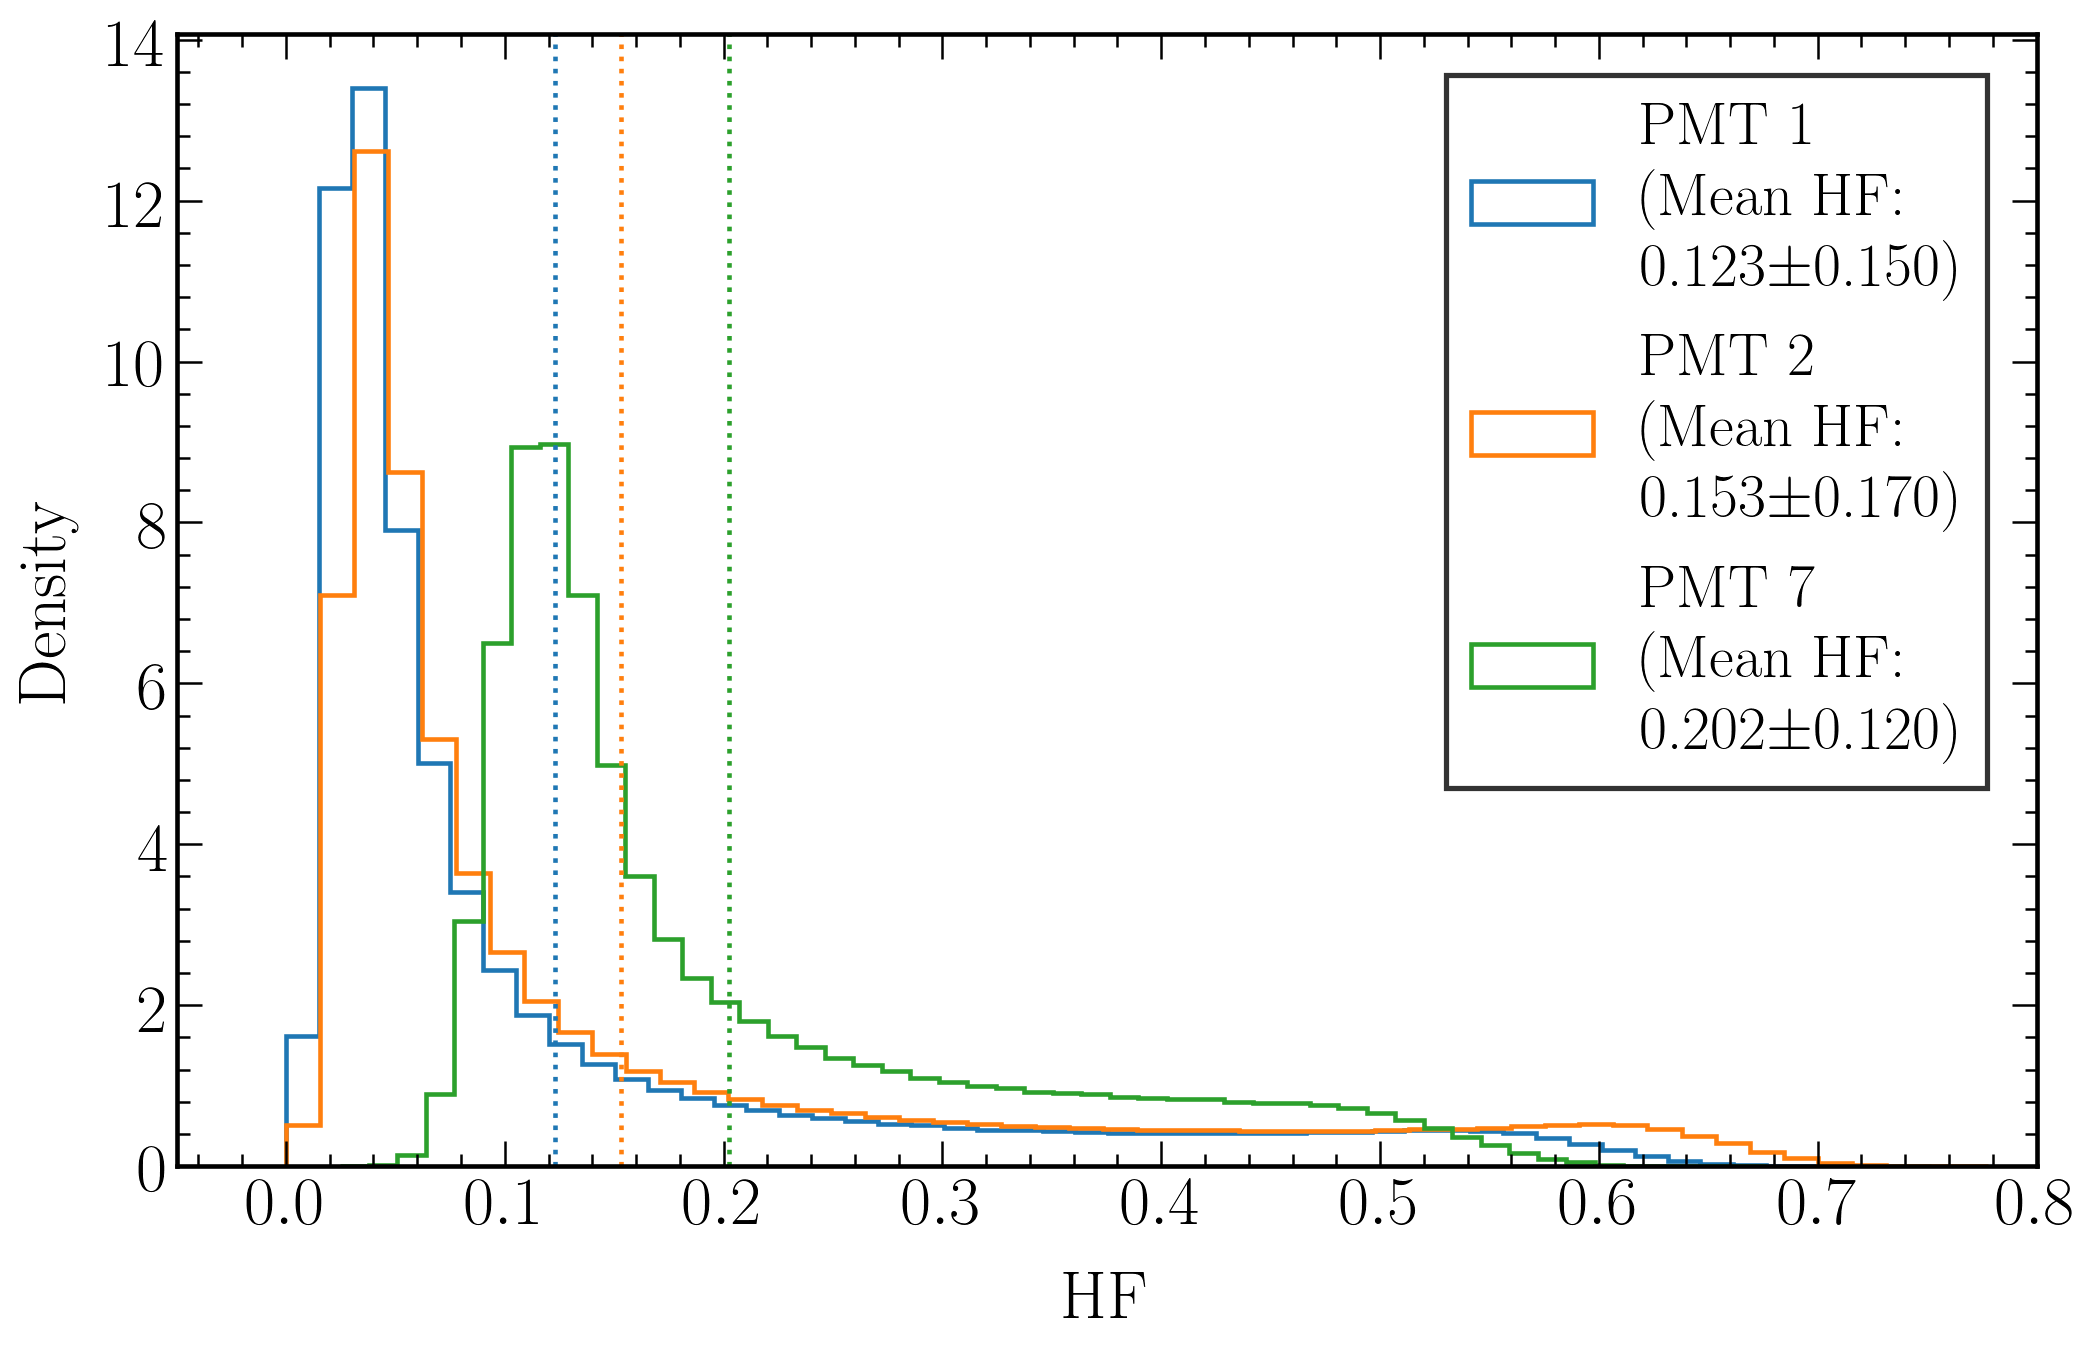

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C0', 
         label = "PMT 1\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C1', 
         label = "PMT 2\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C2', 
         label = "PMT 7\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('HF', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('HF per PMT', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_HF_PMT127_hist_scaled.png")
plt.show()

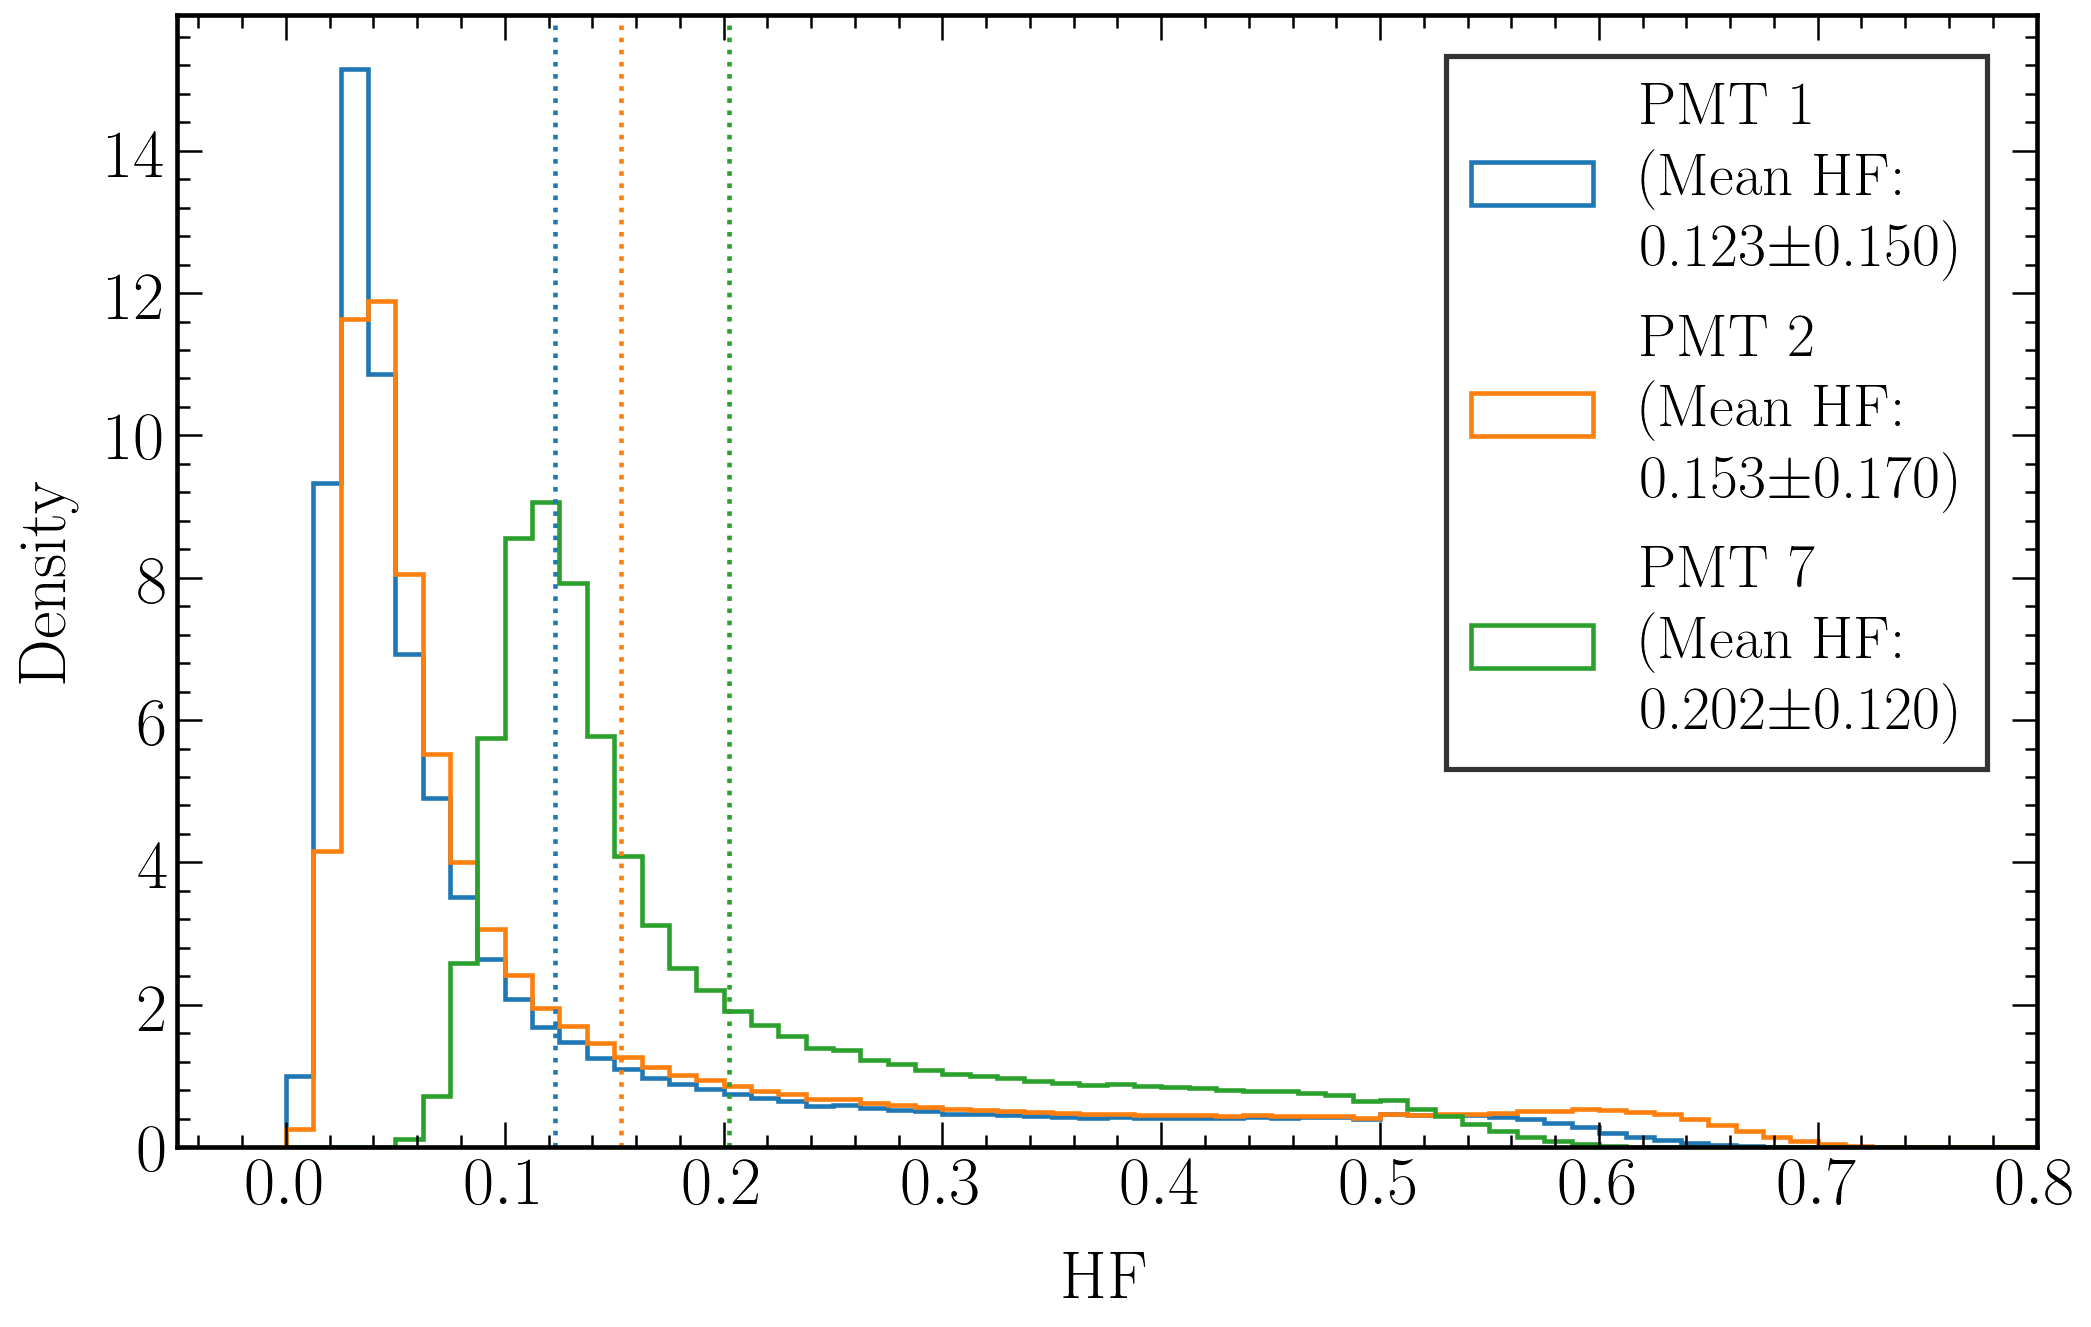

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits'], bins = 80, histtype='step', linewidth = 2.2, 
         density = True, color = 'C0', range = (0,1),
         label = "PMT 1\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits'], bins = 80, histtype='step', linewidth = 2.2, 
         density = True, color = 'C1', range = (0,1),
         label = "PMT 2\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits'], bins = 80, histtype='step', linewidth = 2.2, 
         density = True, color = 'C2', range = (0,1),
         label = "PMT 7\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('HF', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('HF per PMT', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_HF_PMT127_hist_scaled_fixedbinning.png")
plt.show()

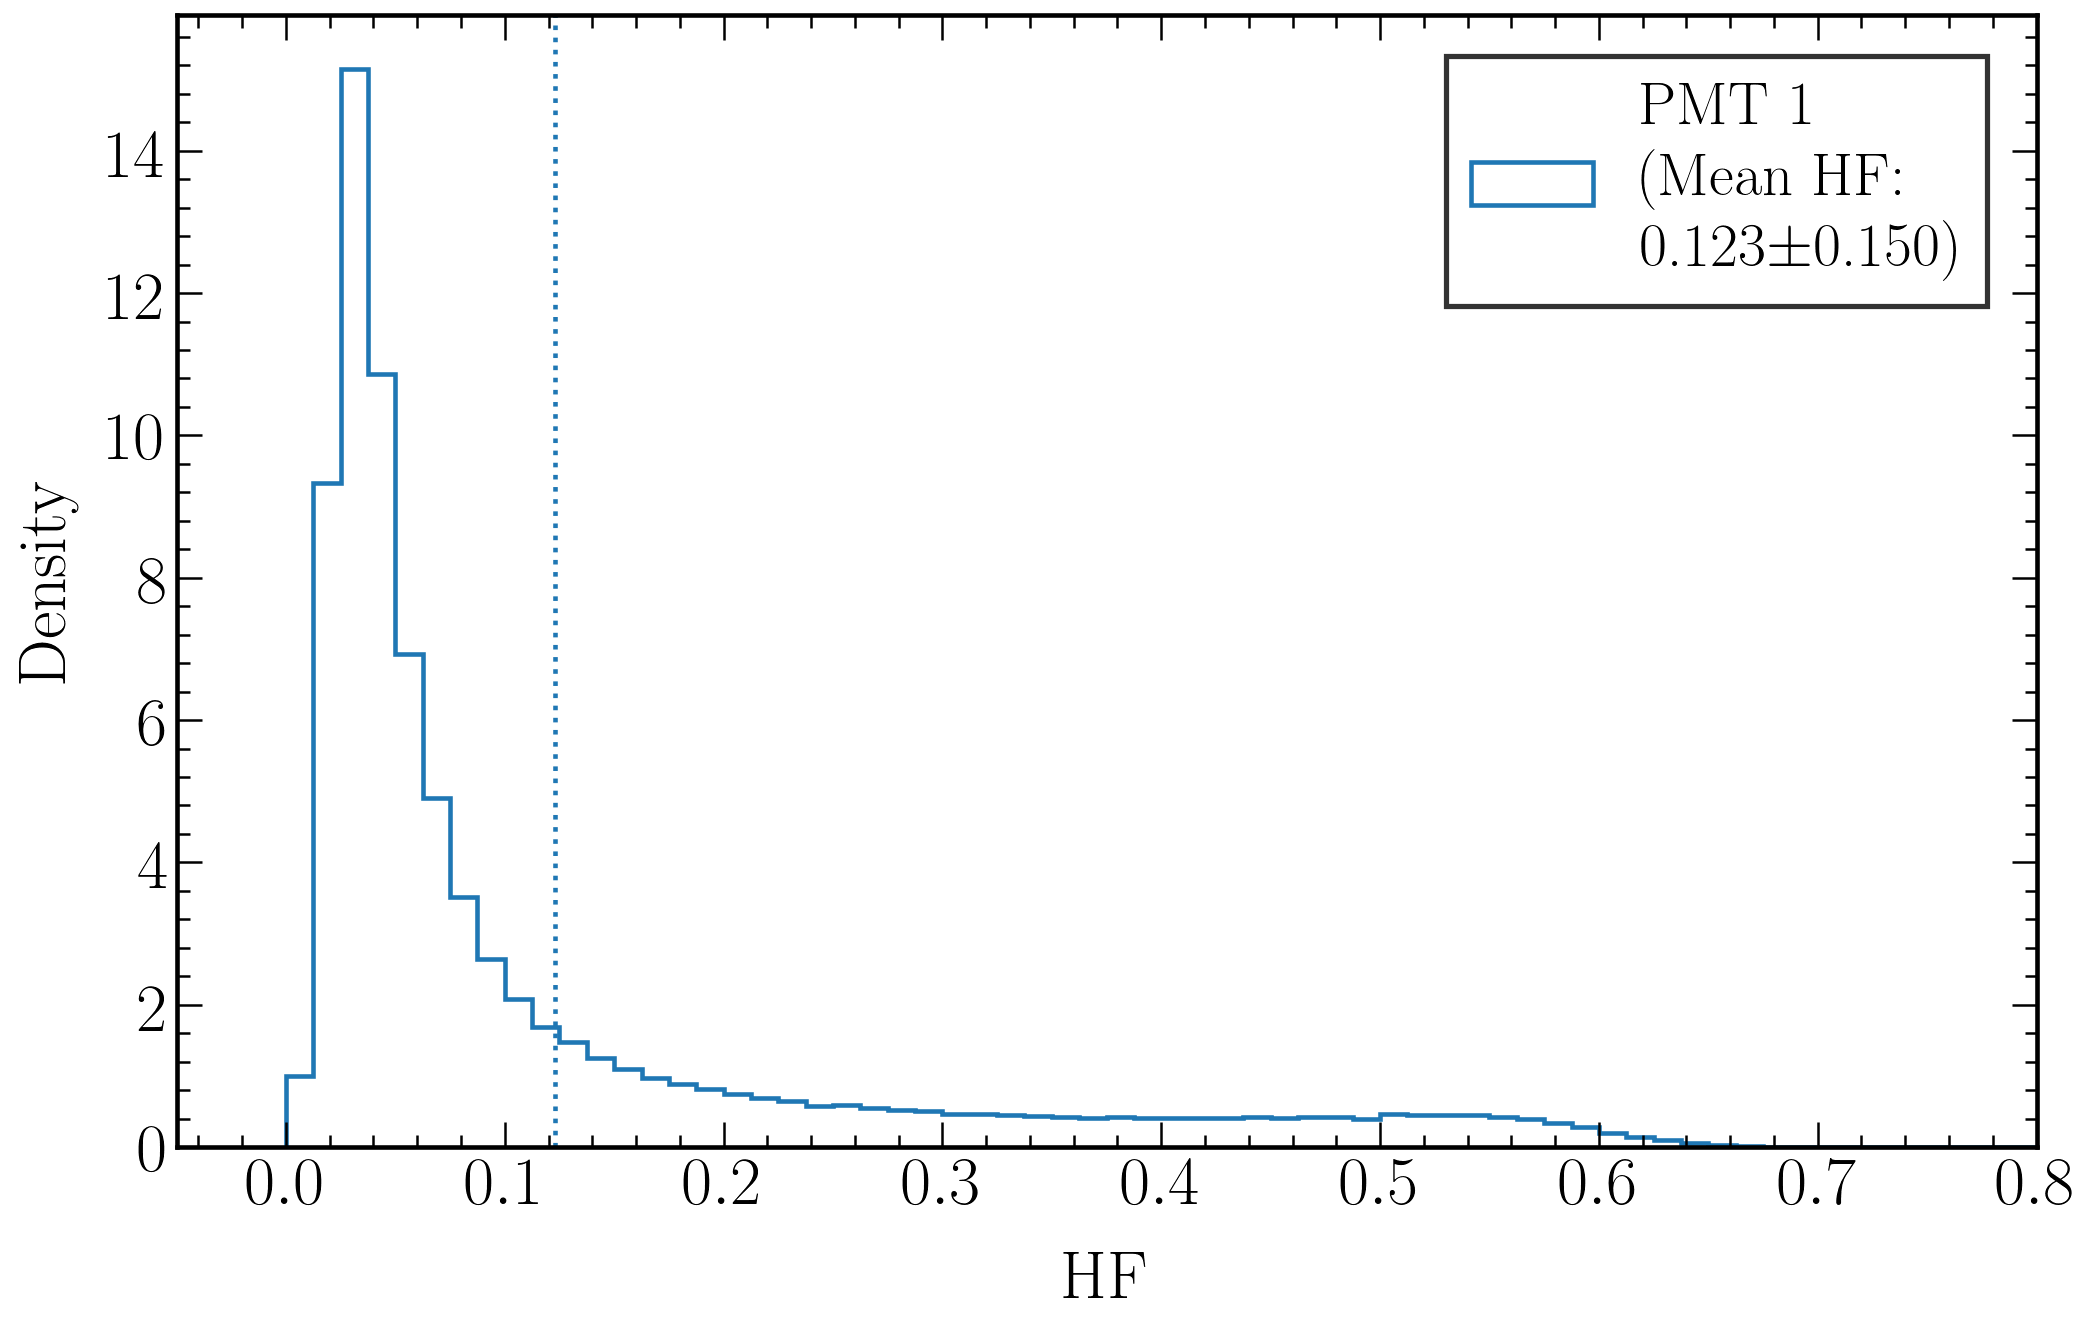

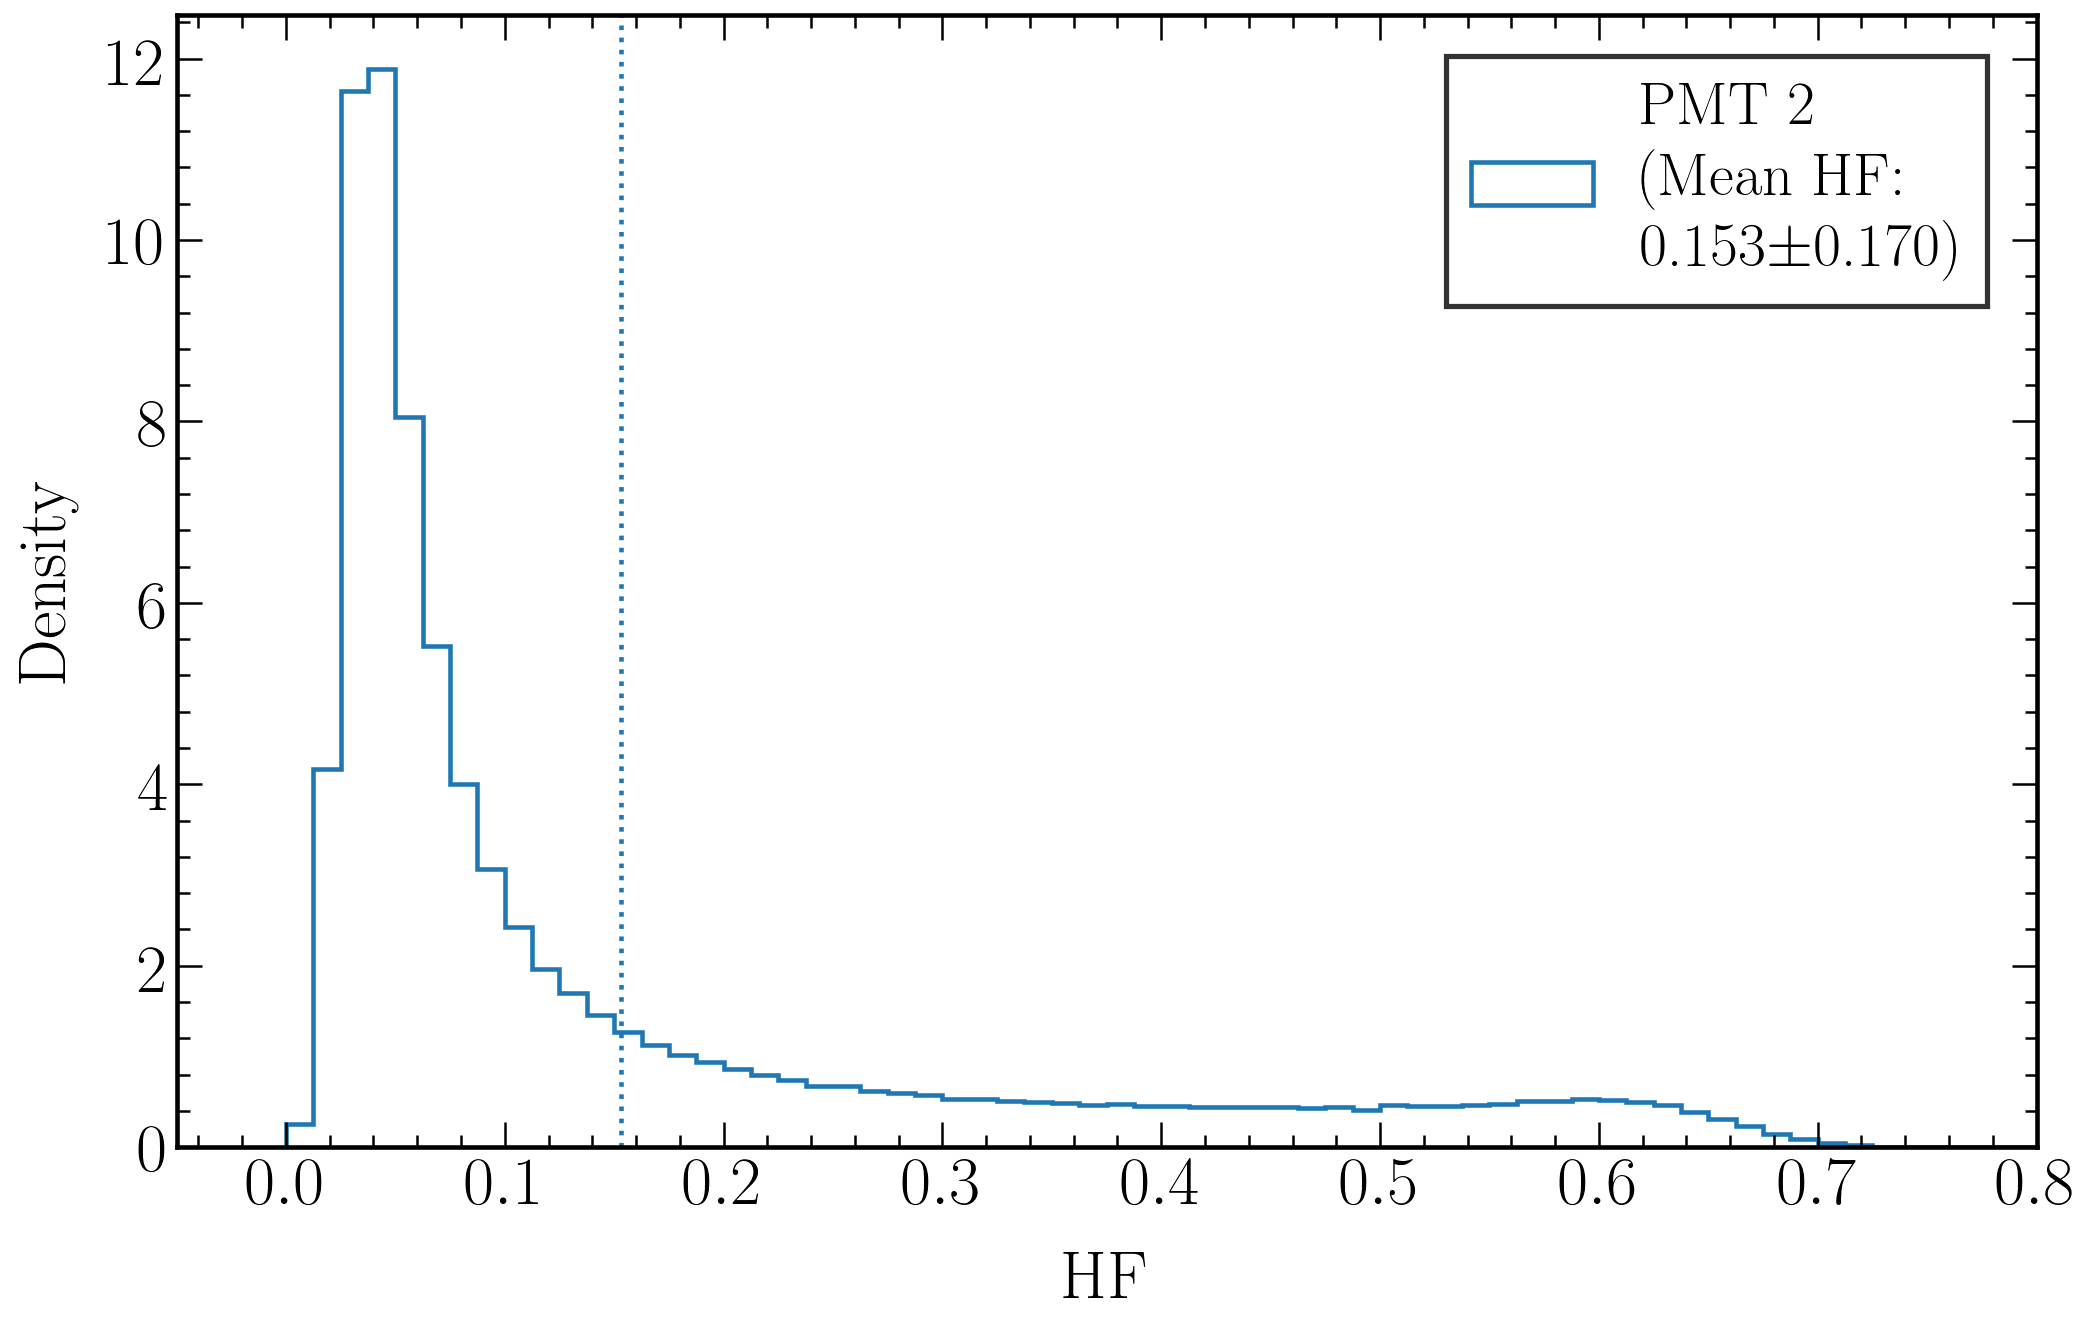

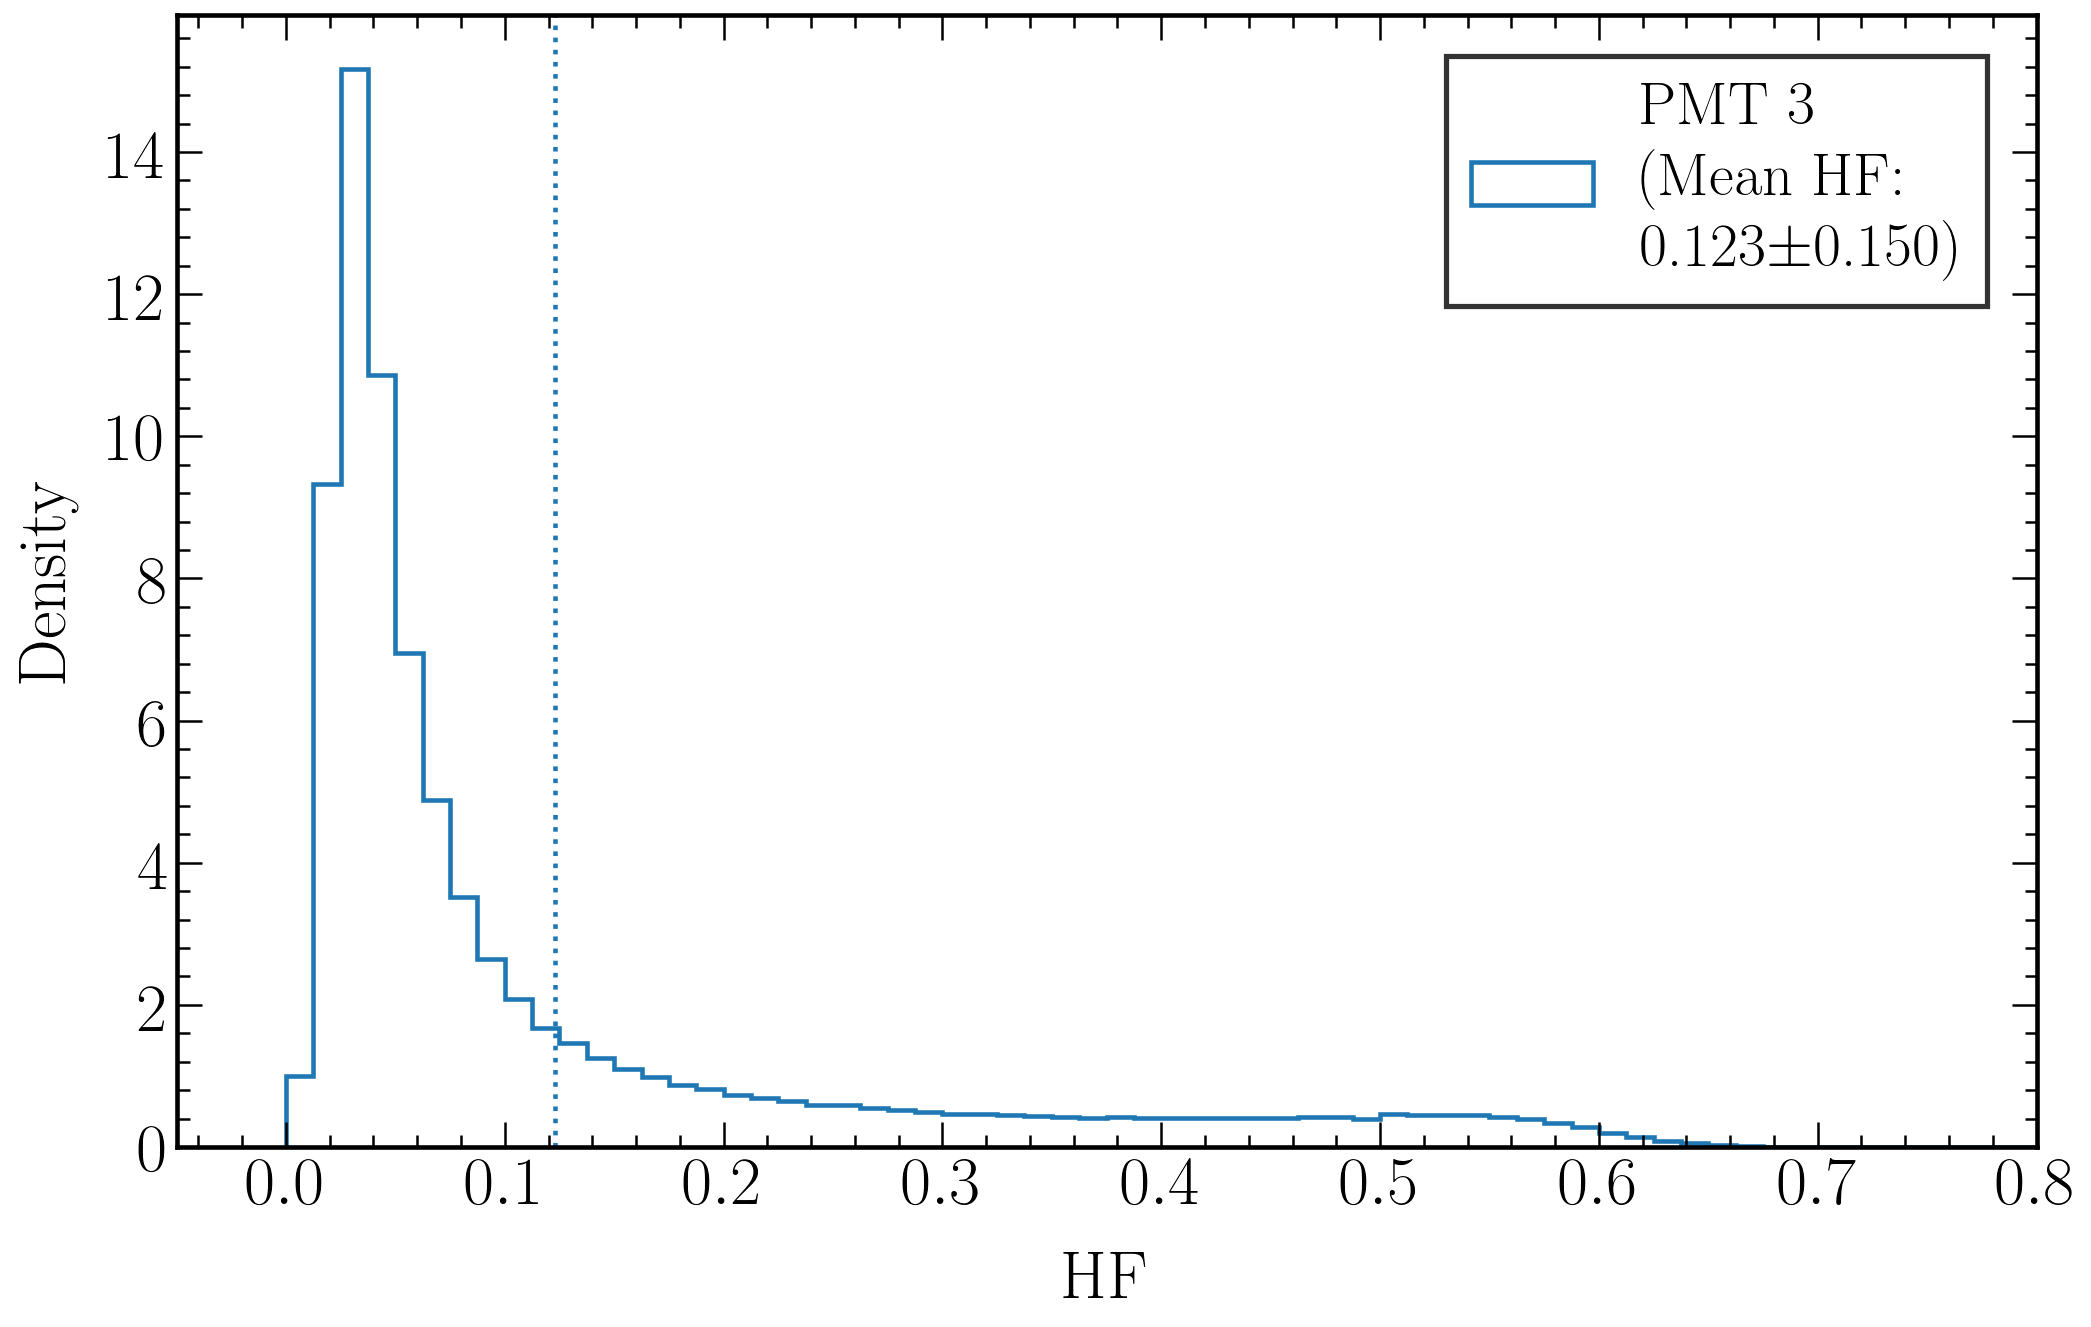

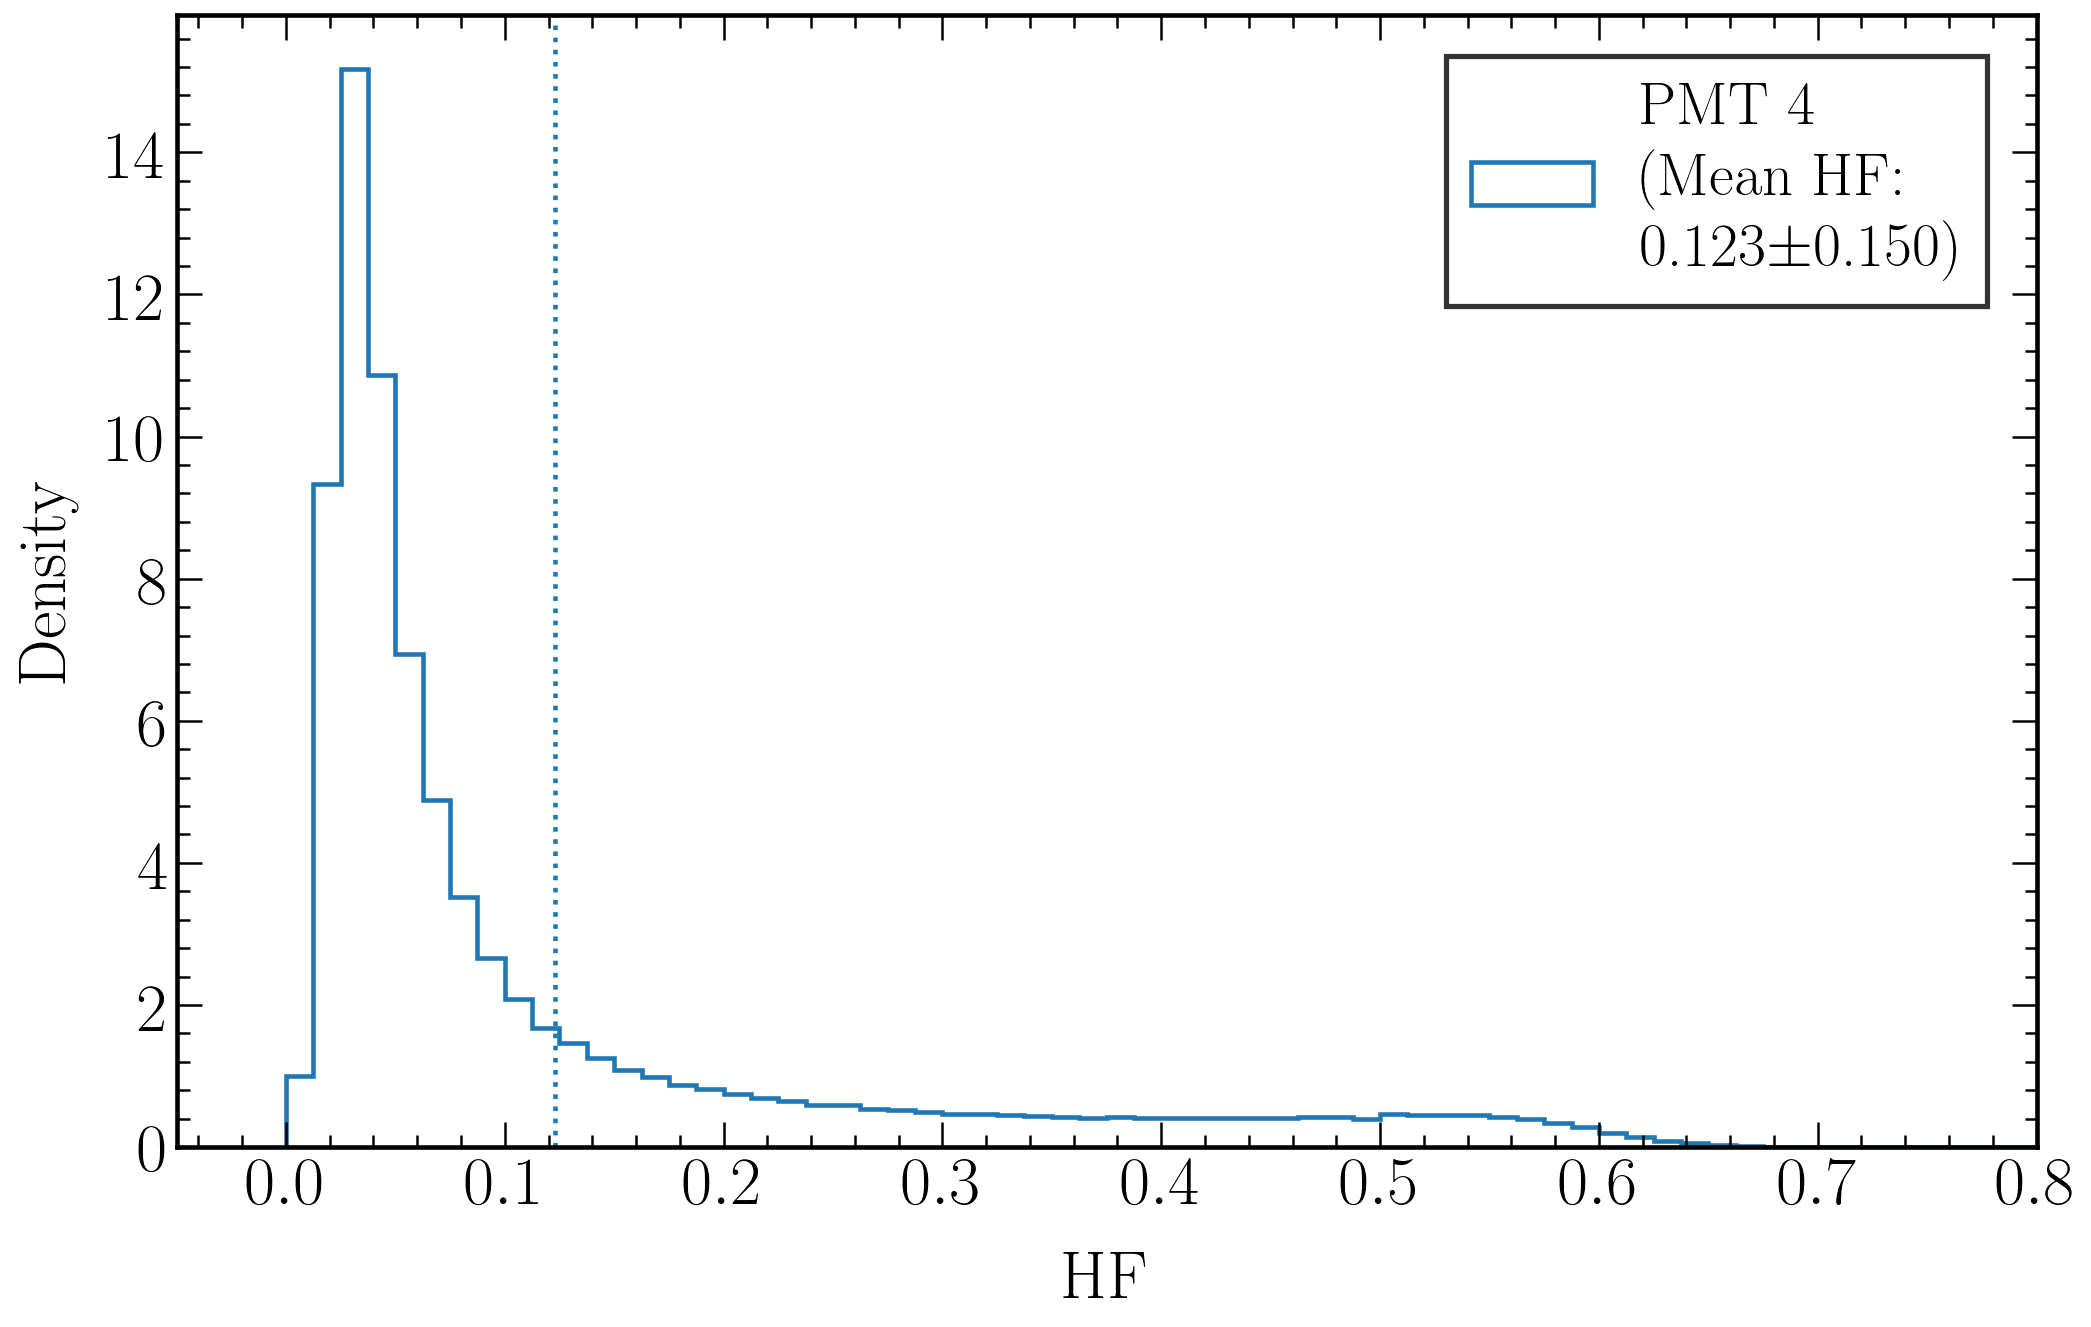

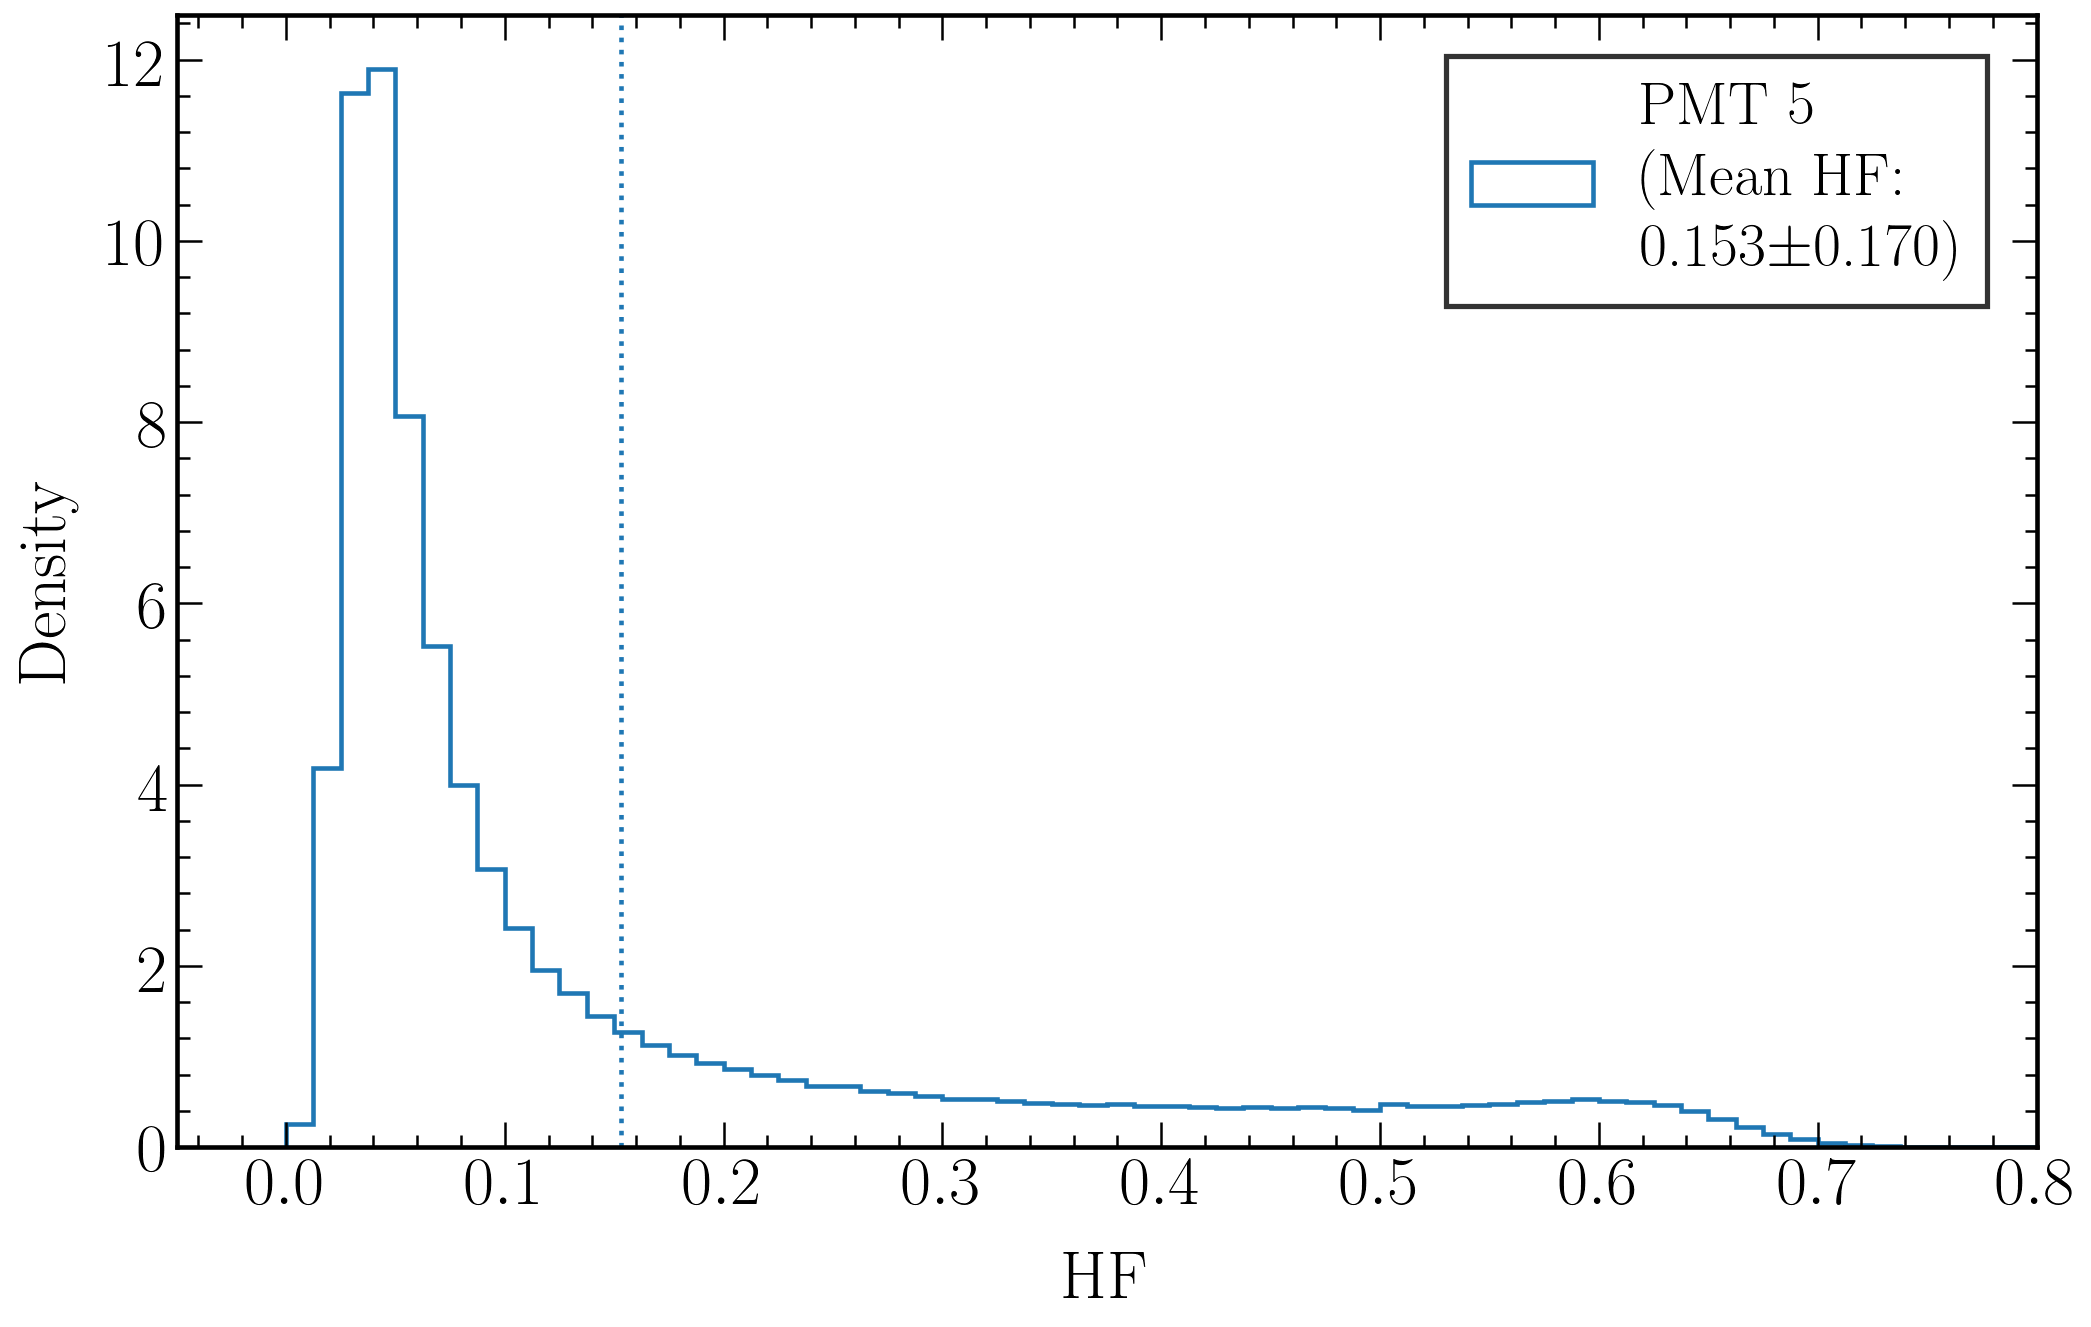

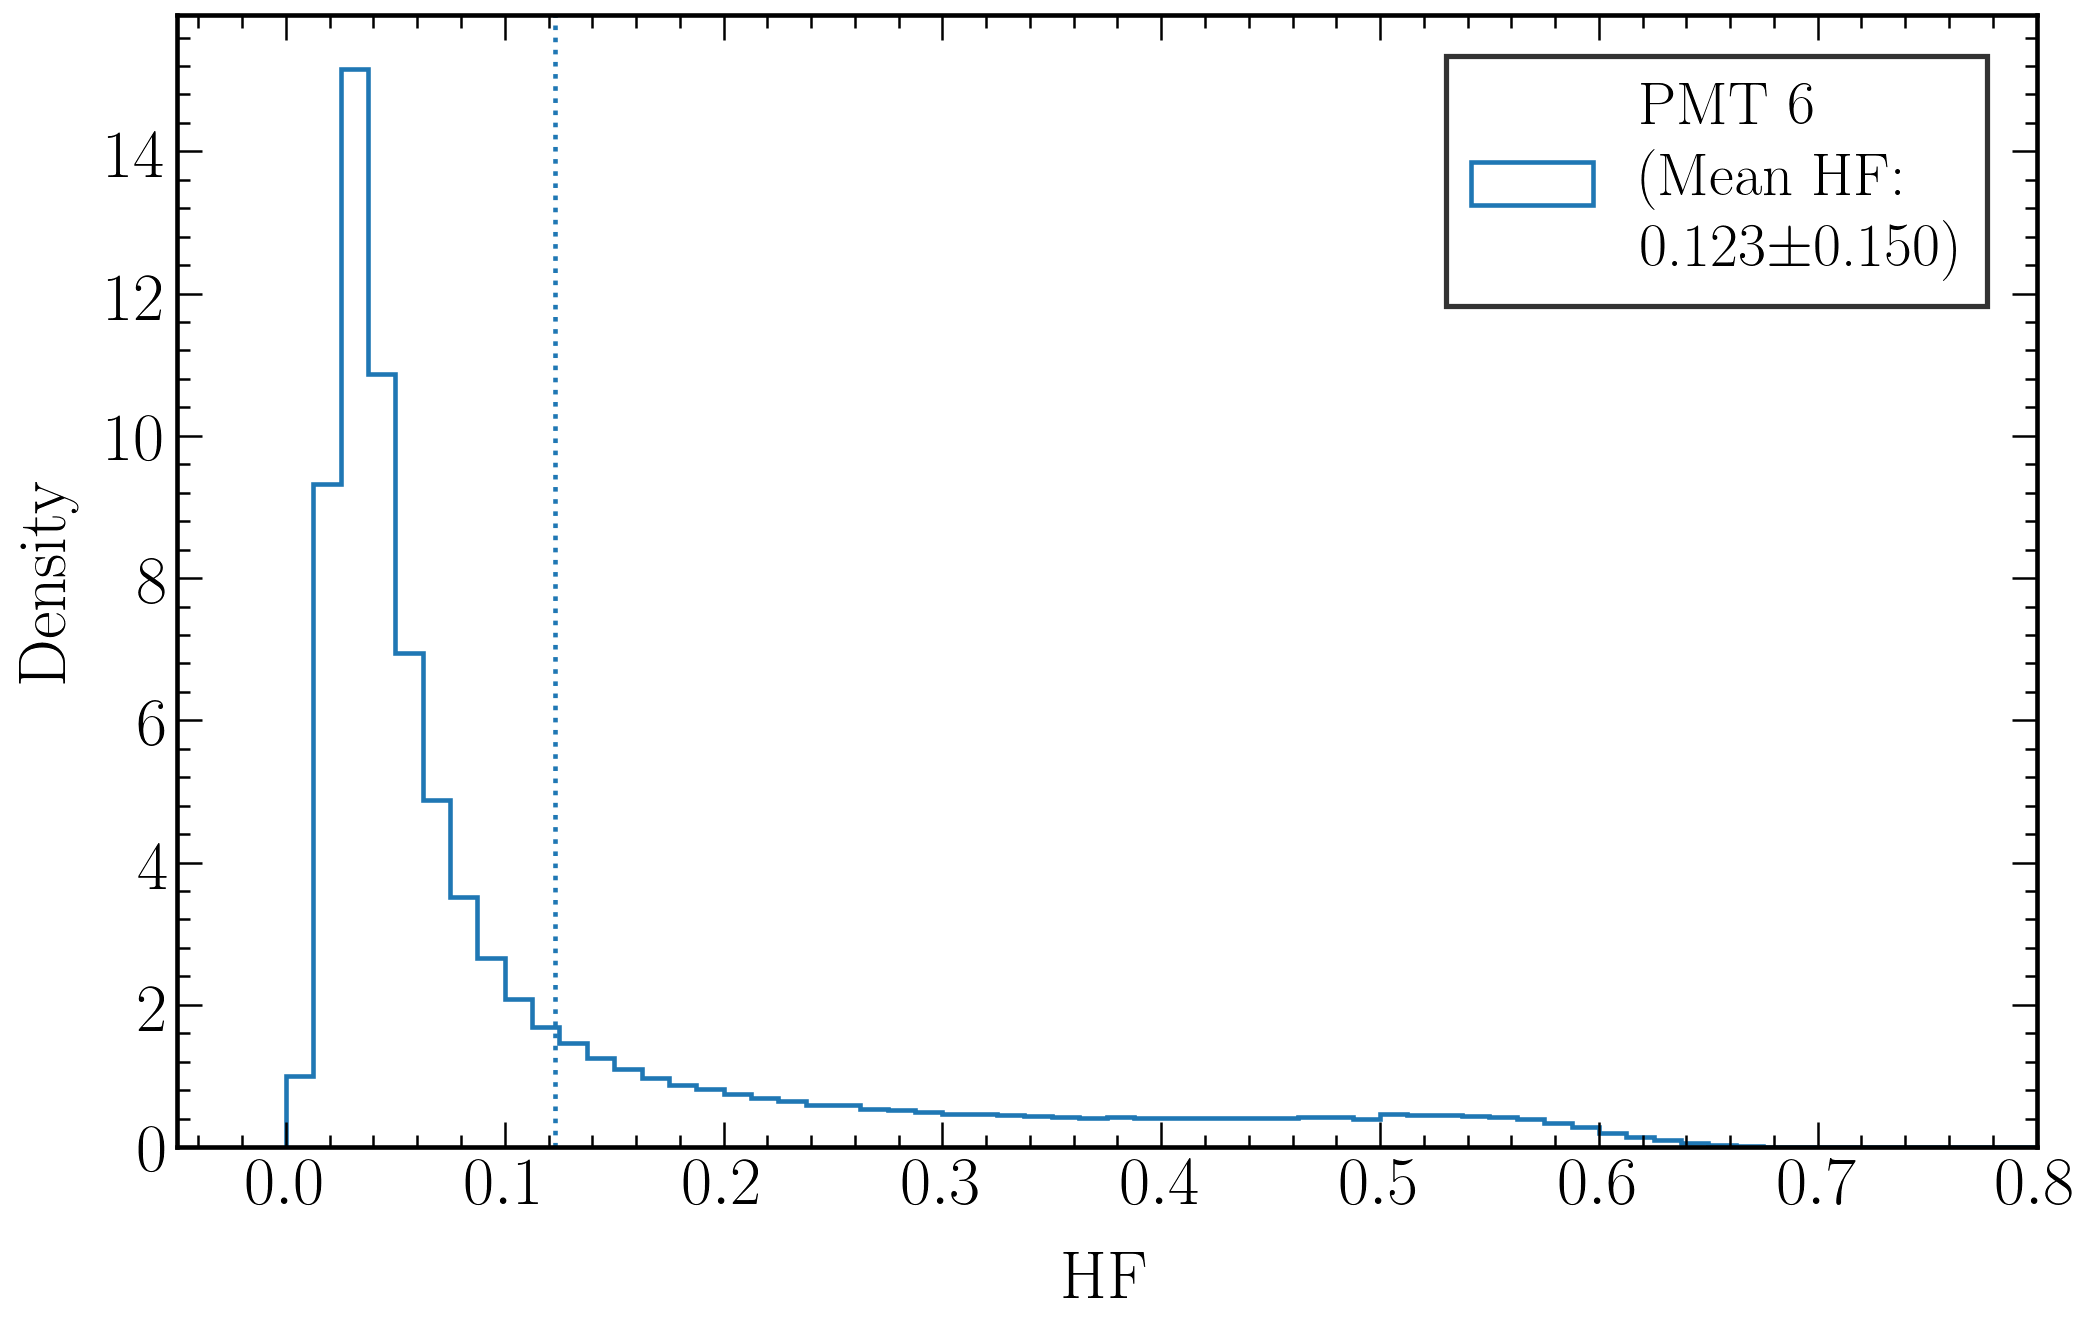

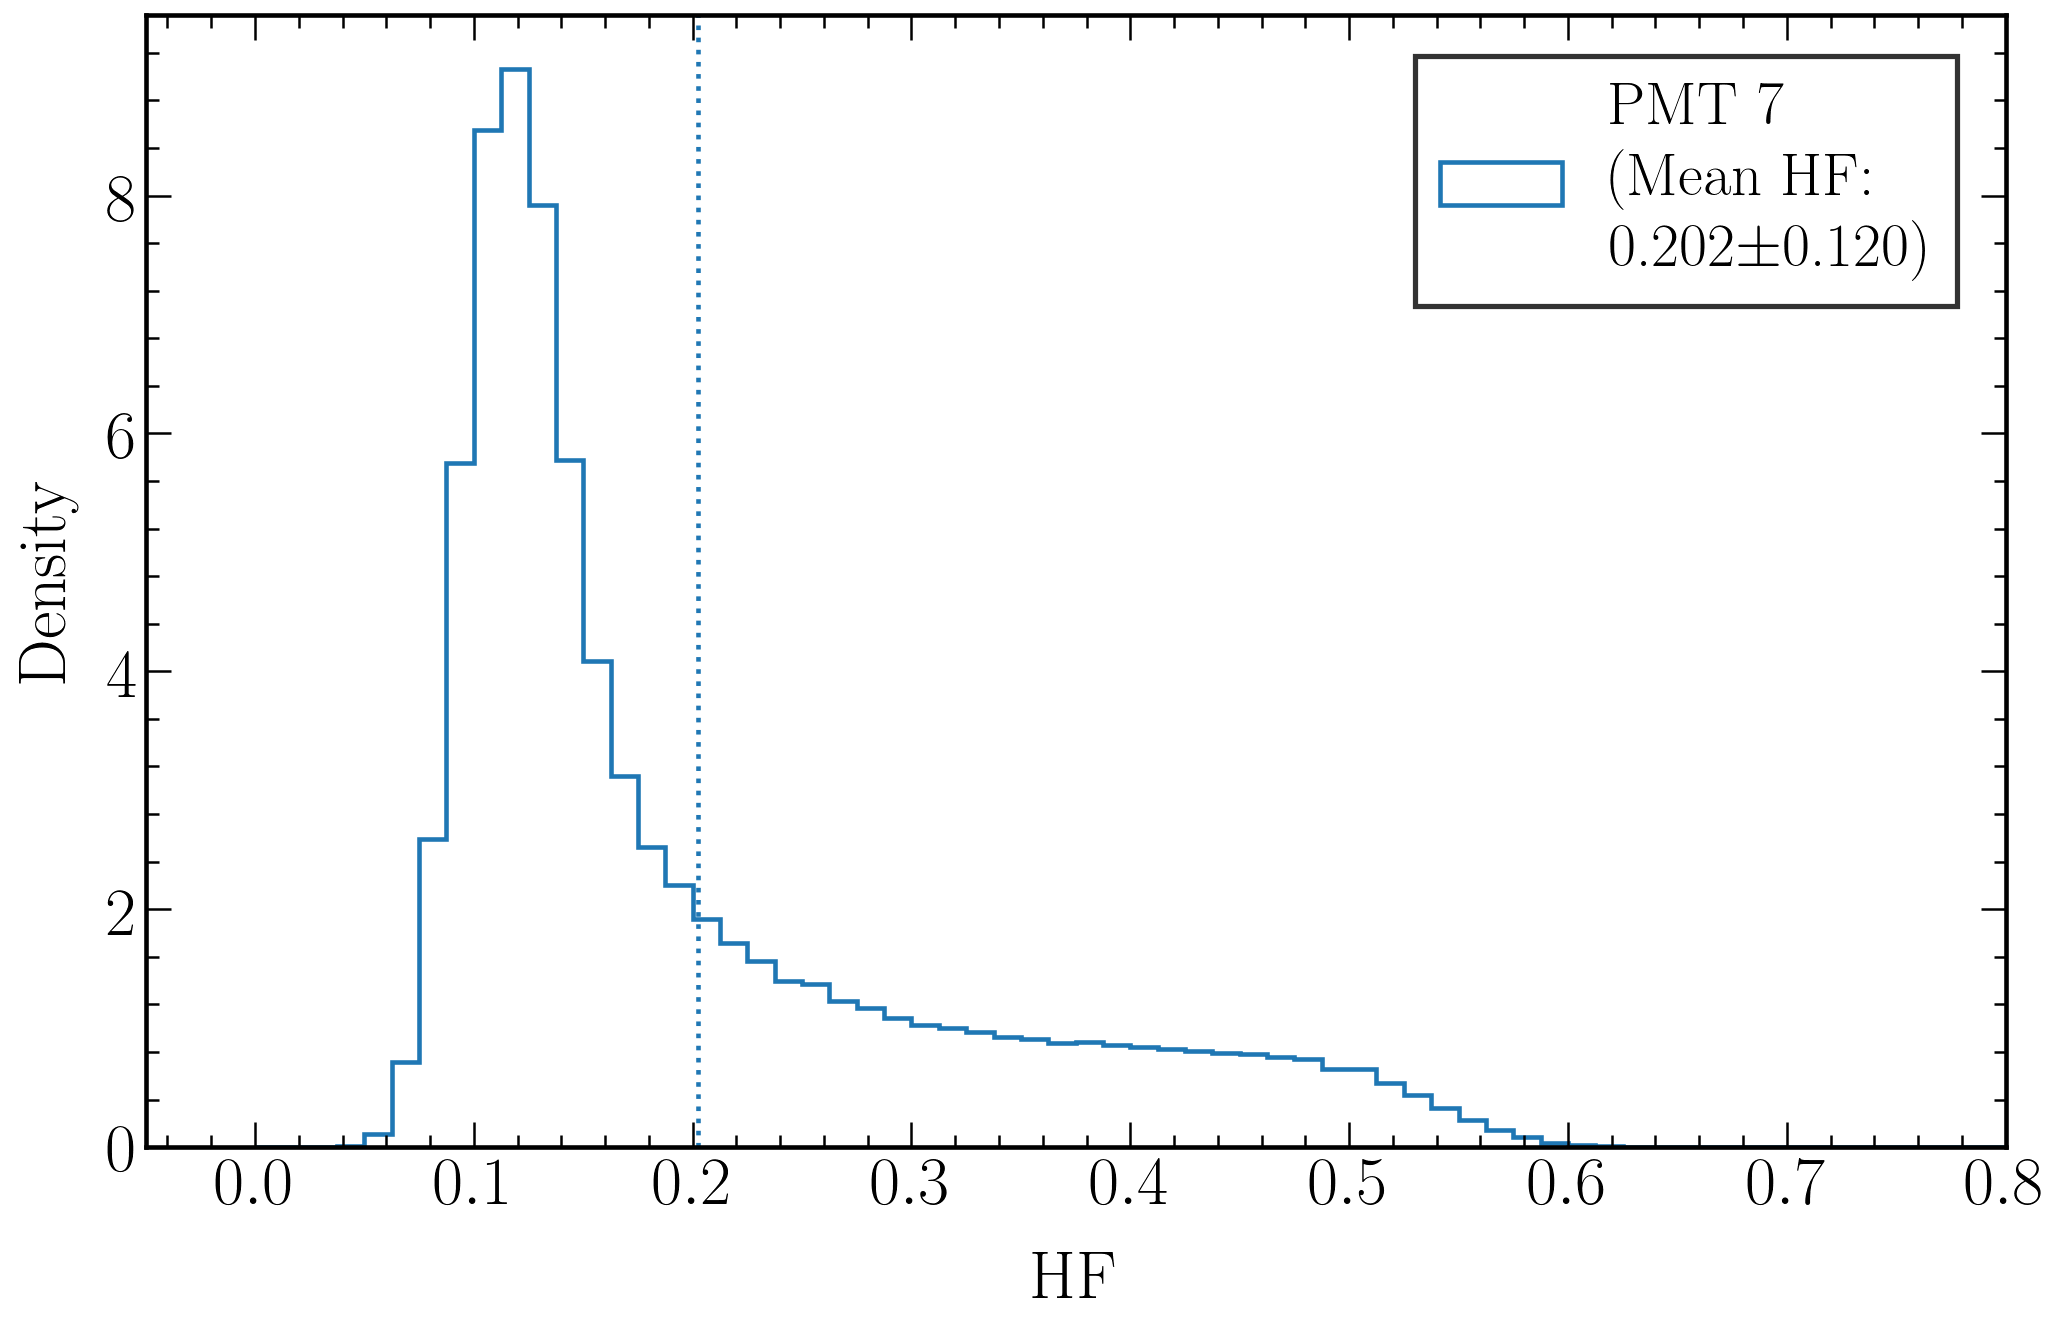

In [20]:
for i in range(1,8):
    
    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    plt.hist(_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits'], bins = 80, histtype='step', linewidth = 2.2, 
             density = True, color = 'C0', range = (0,1),
             label = "PMT "+str(i)+"\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits']).std(), 2))+")")
    plt.axvline(x=(_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

    plt.xlabel('HF', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
    #plt.title('HF per PMT', fontsize = title_size, pad = title_pad)

    plt.xlim(-0.05,0.8)

    # Legend
    leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    #leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig(filenameprefix+"_HF_PMT"+str(i)+"_hist_scaled_fixedbinning.png")
    plt.show()

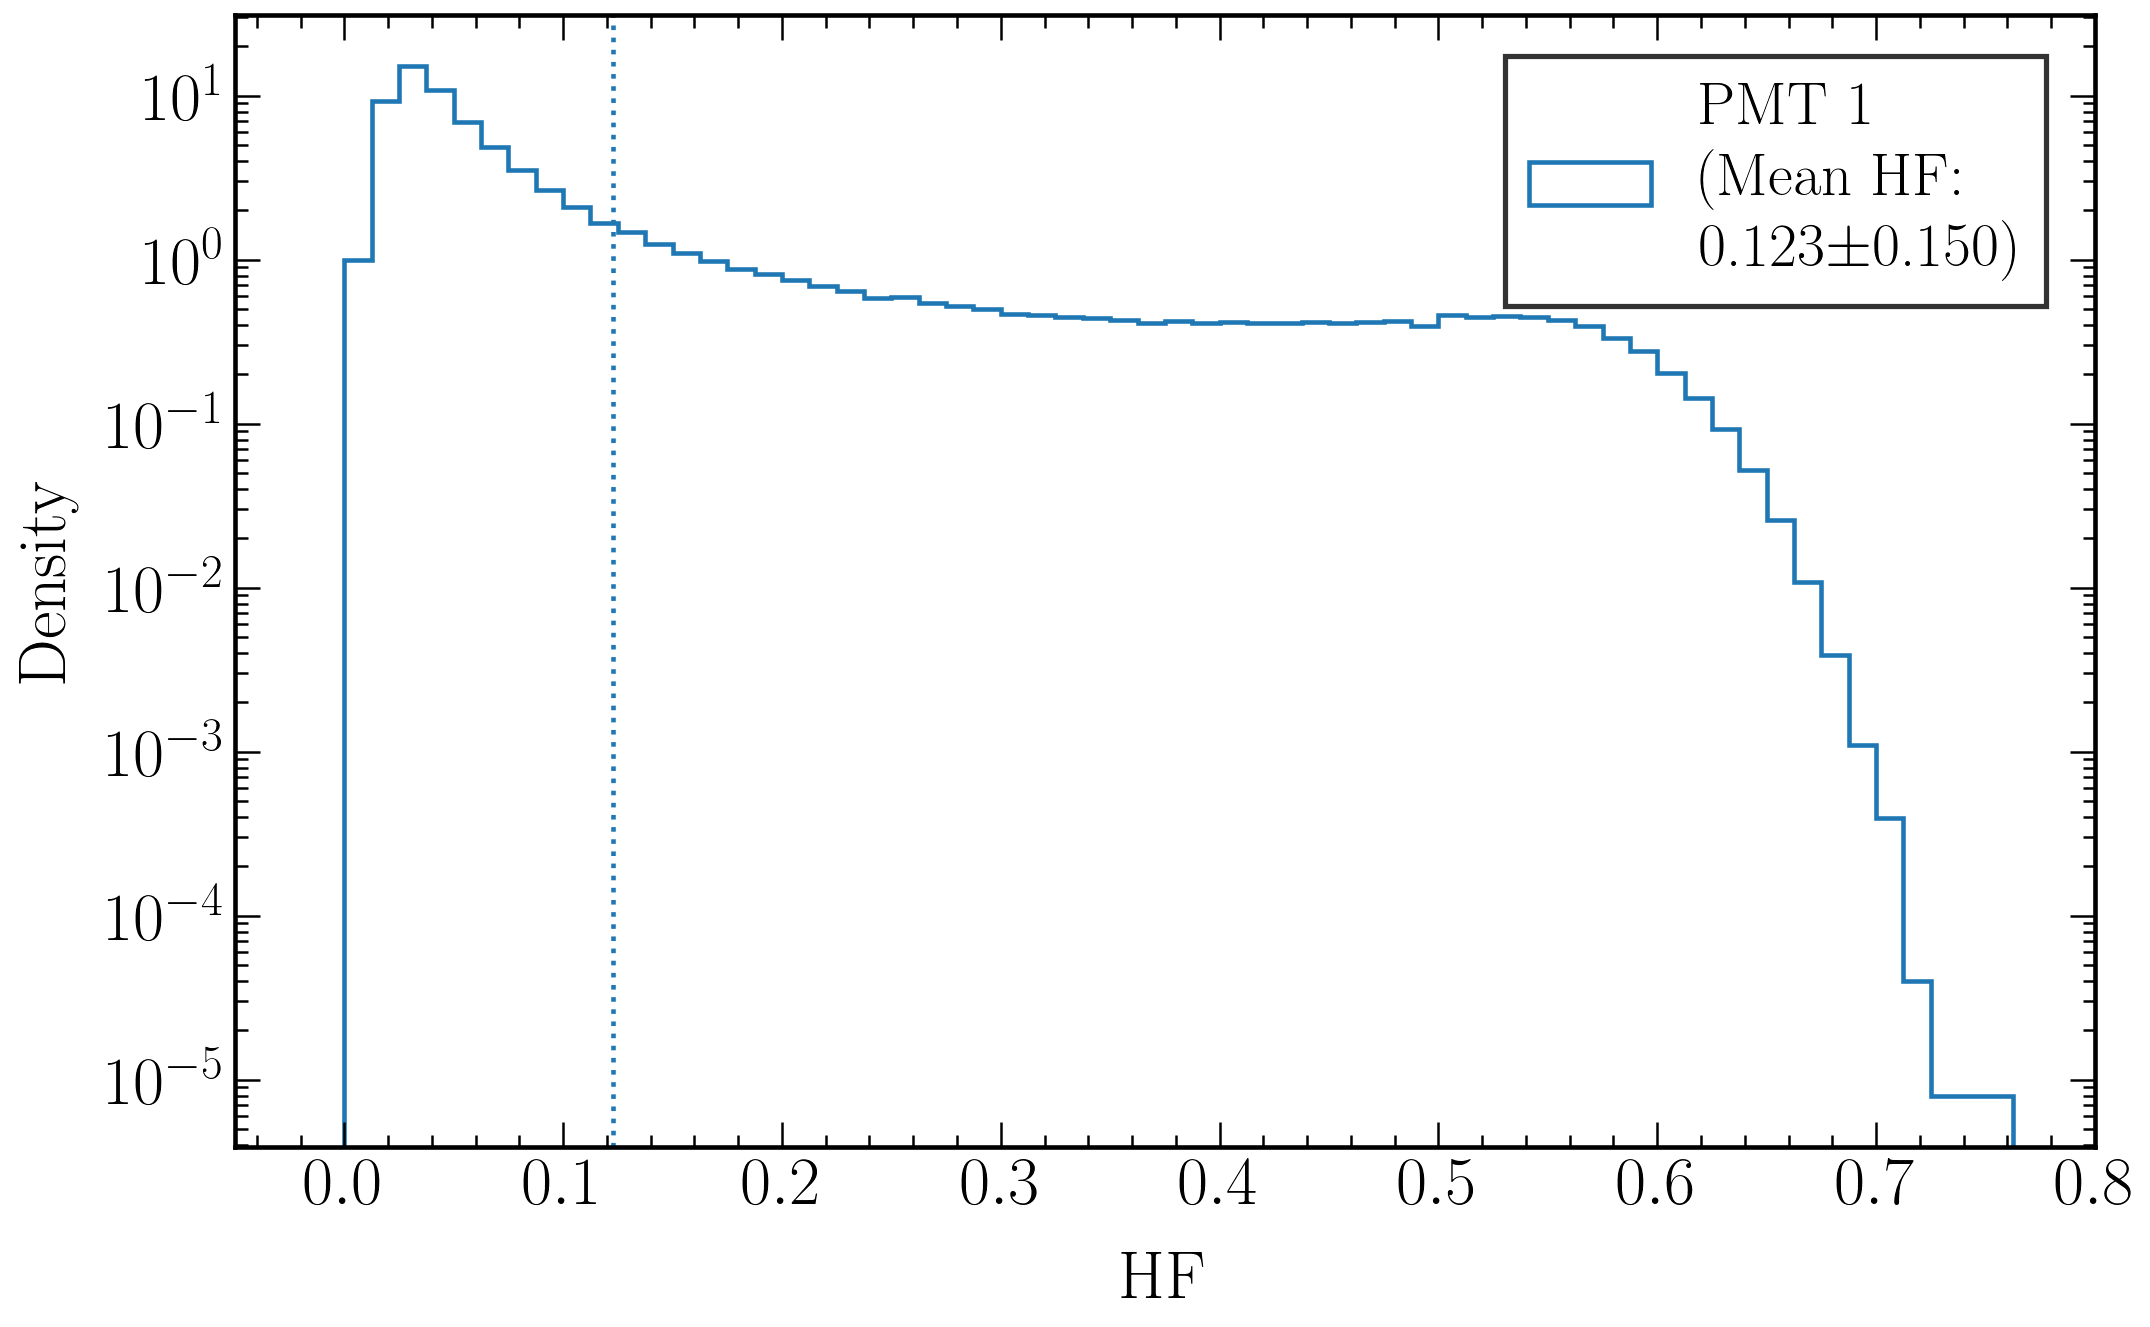

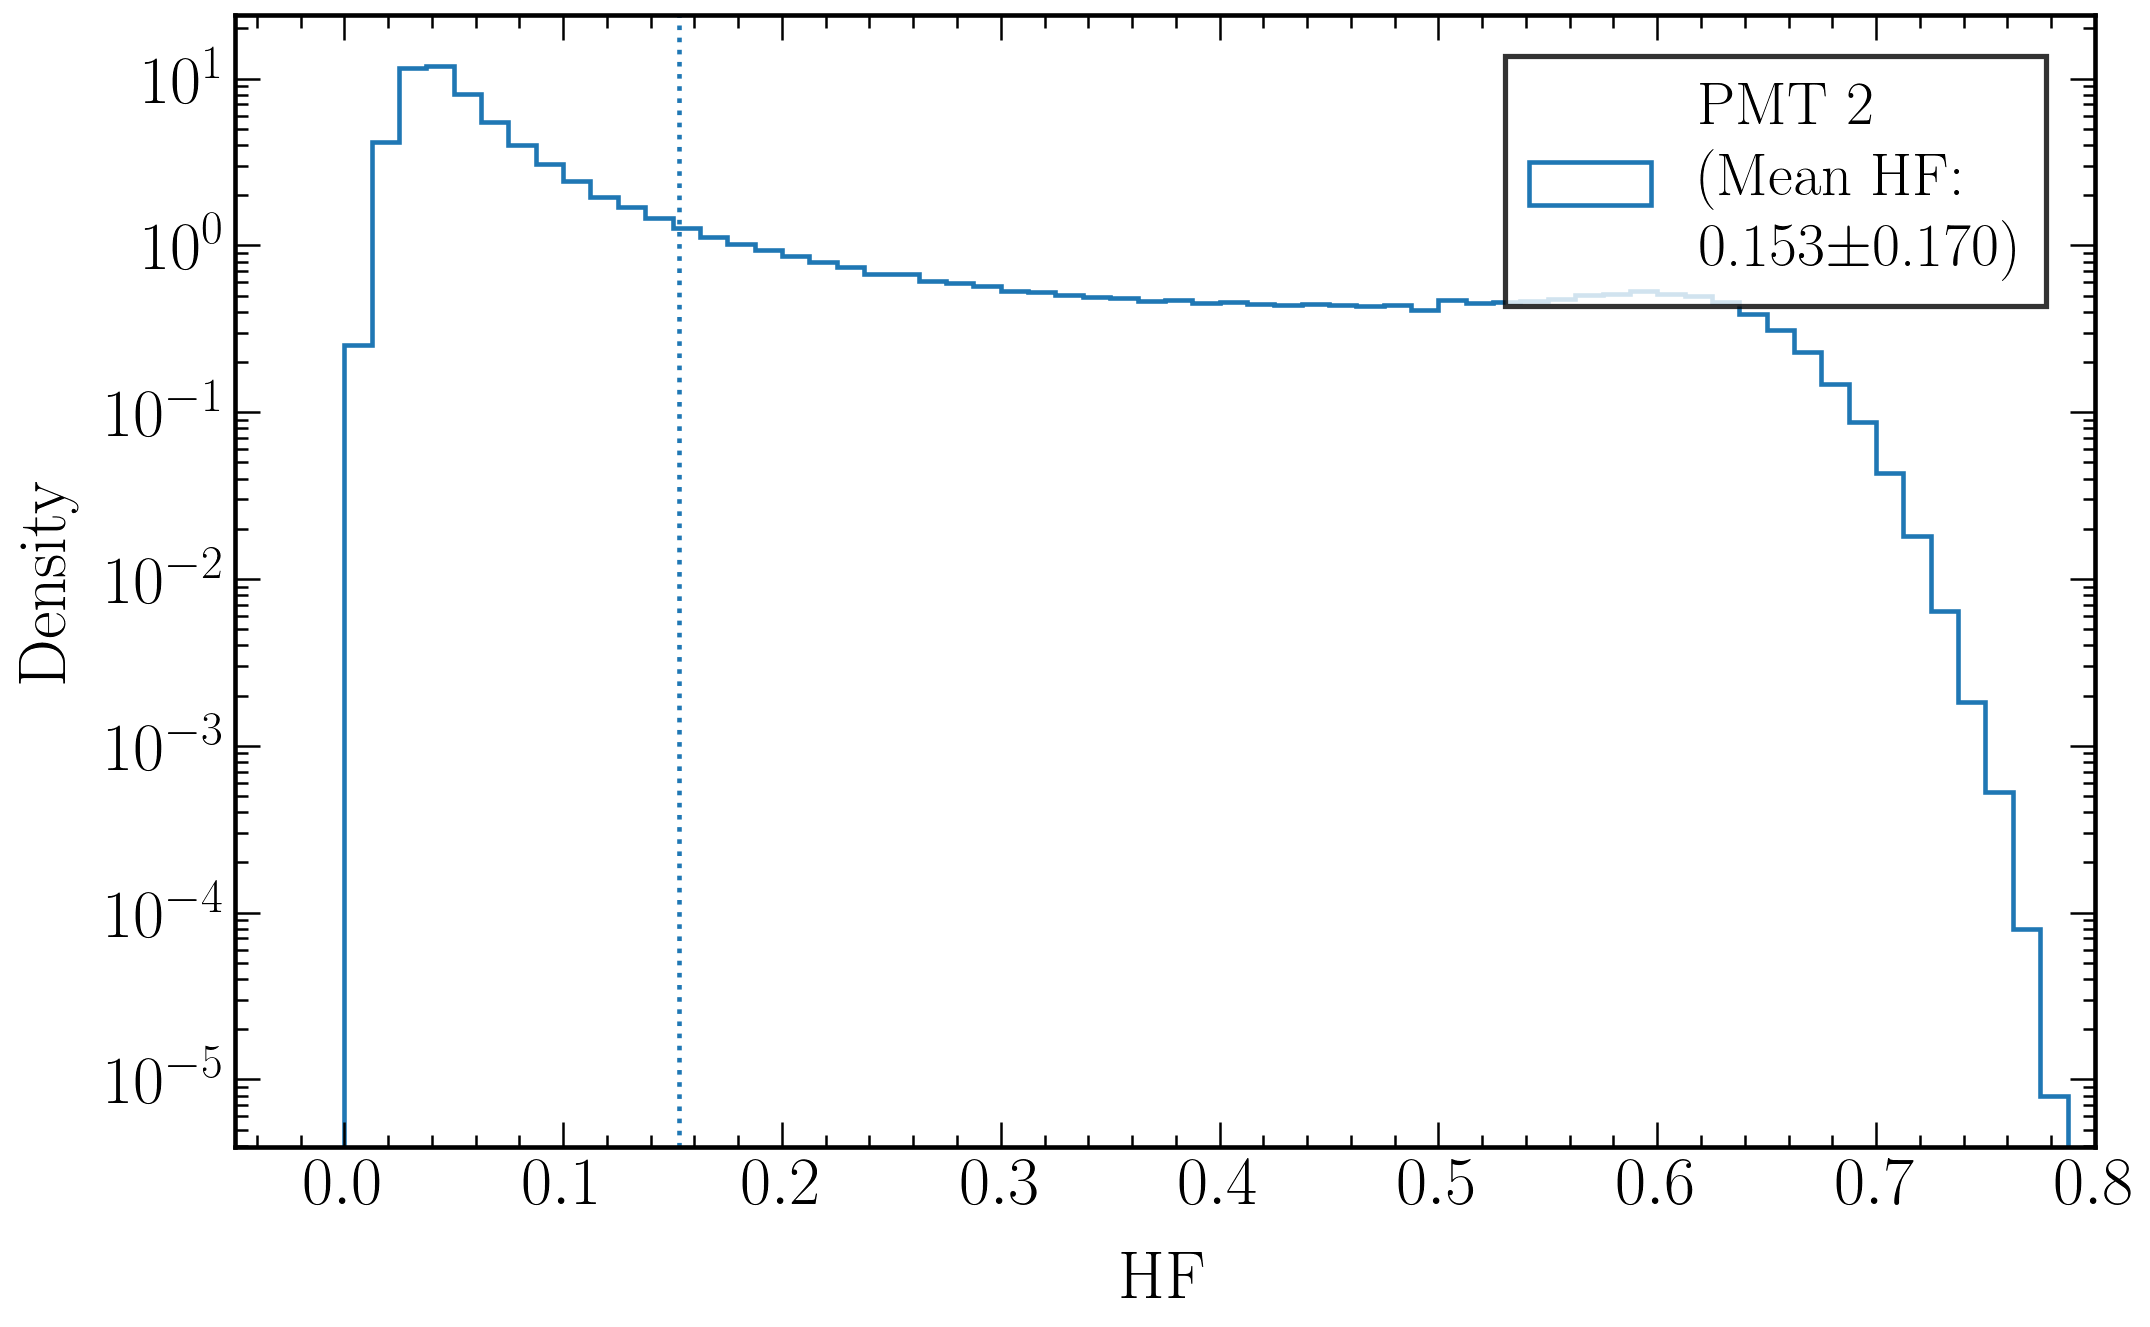

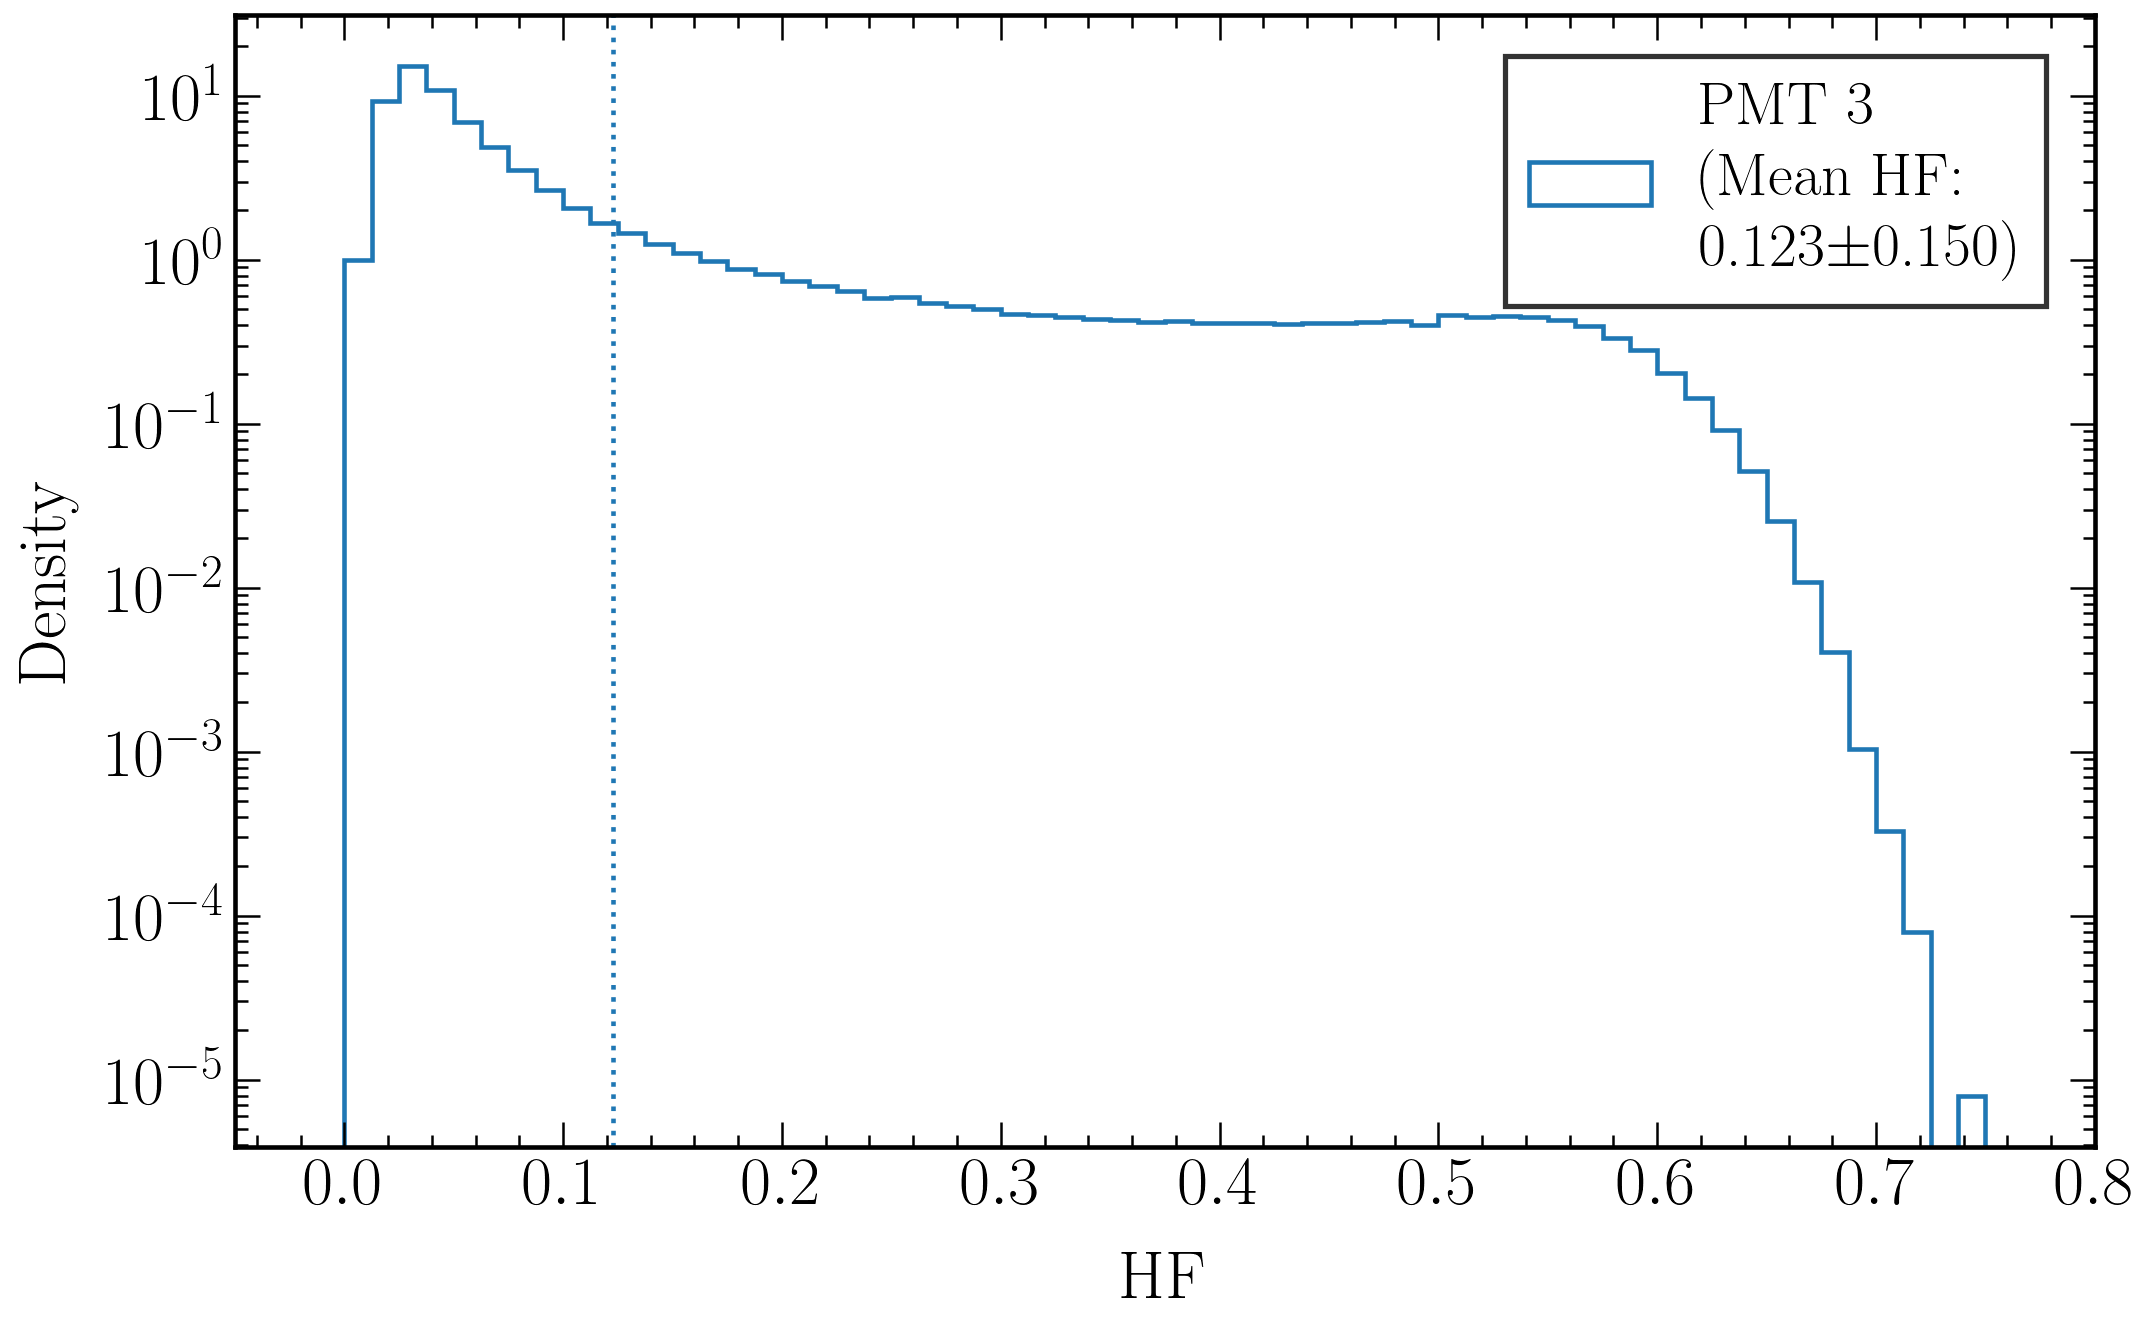

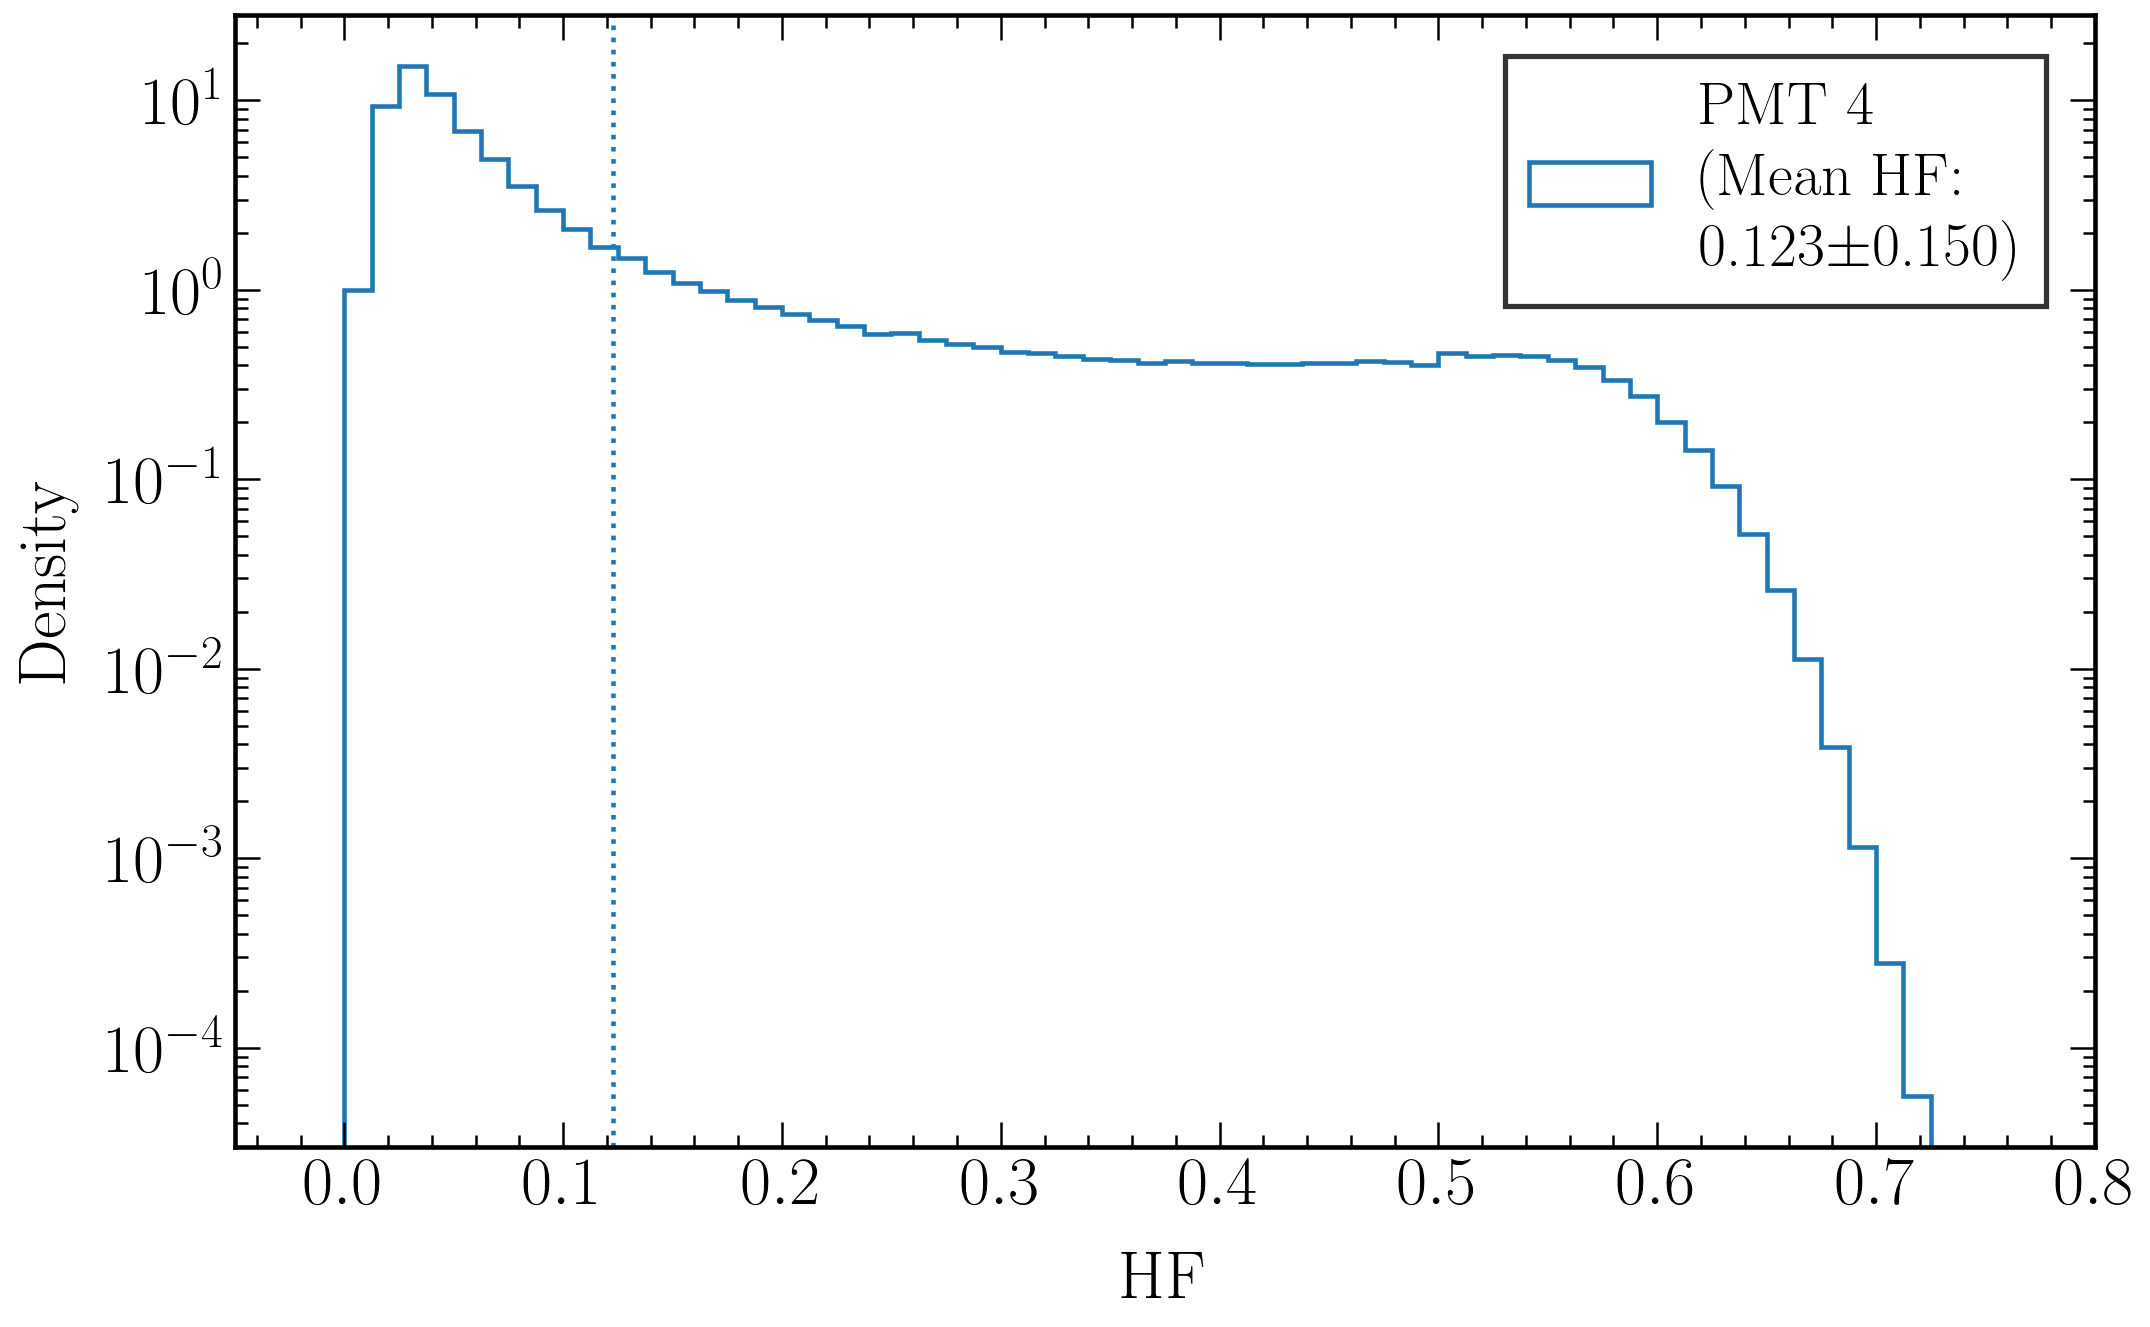

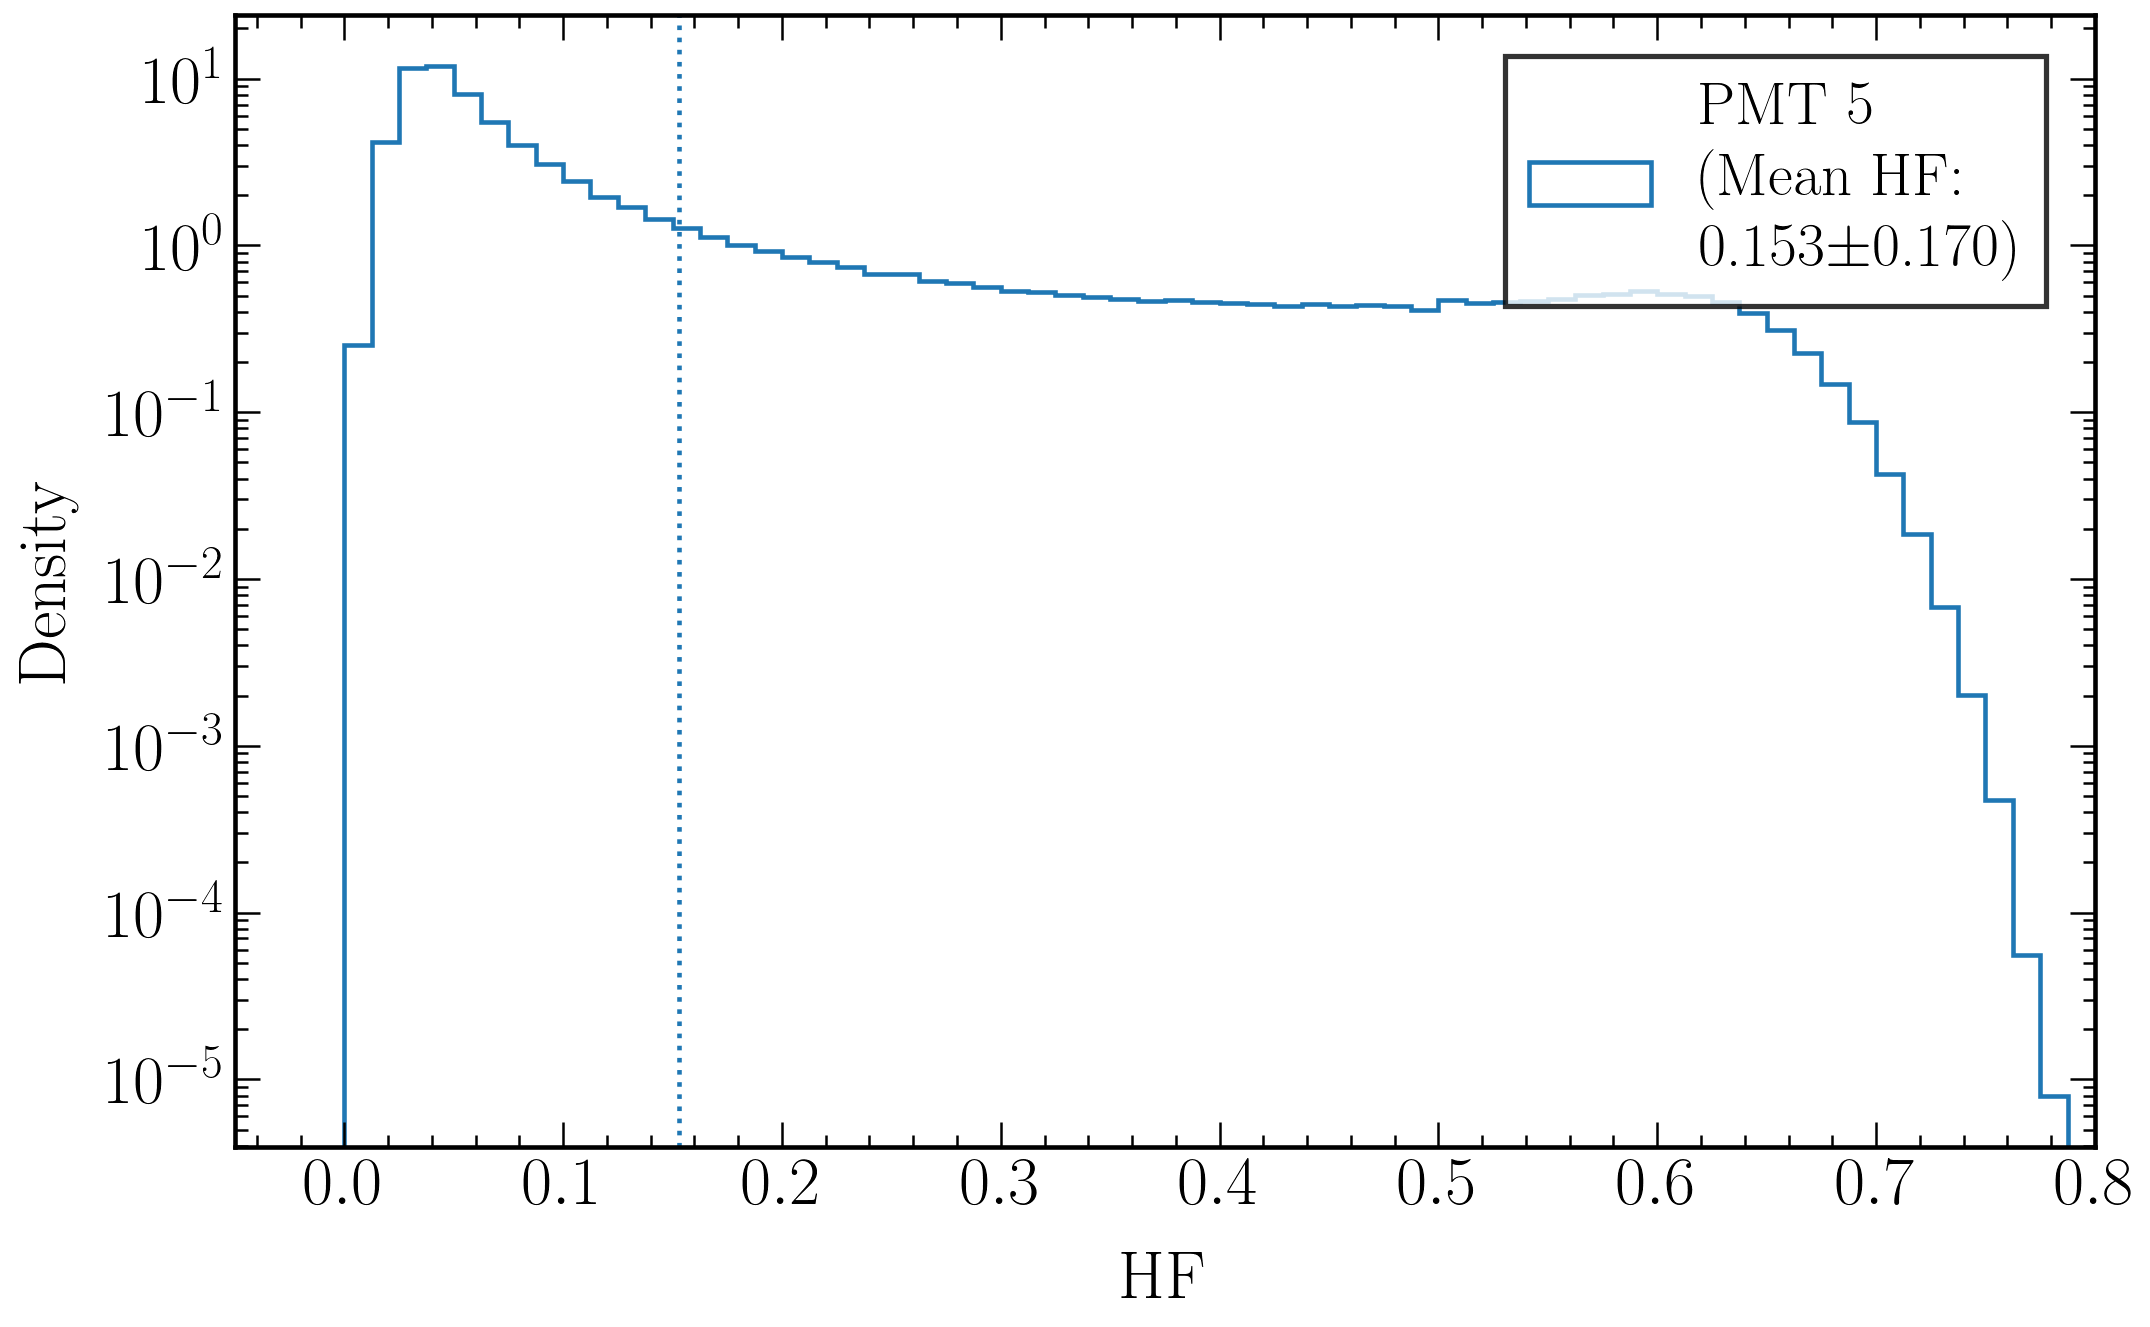

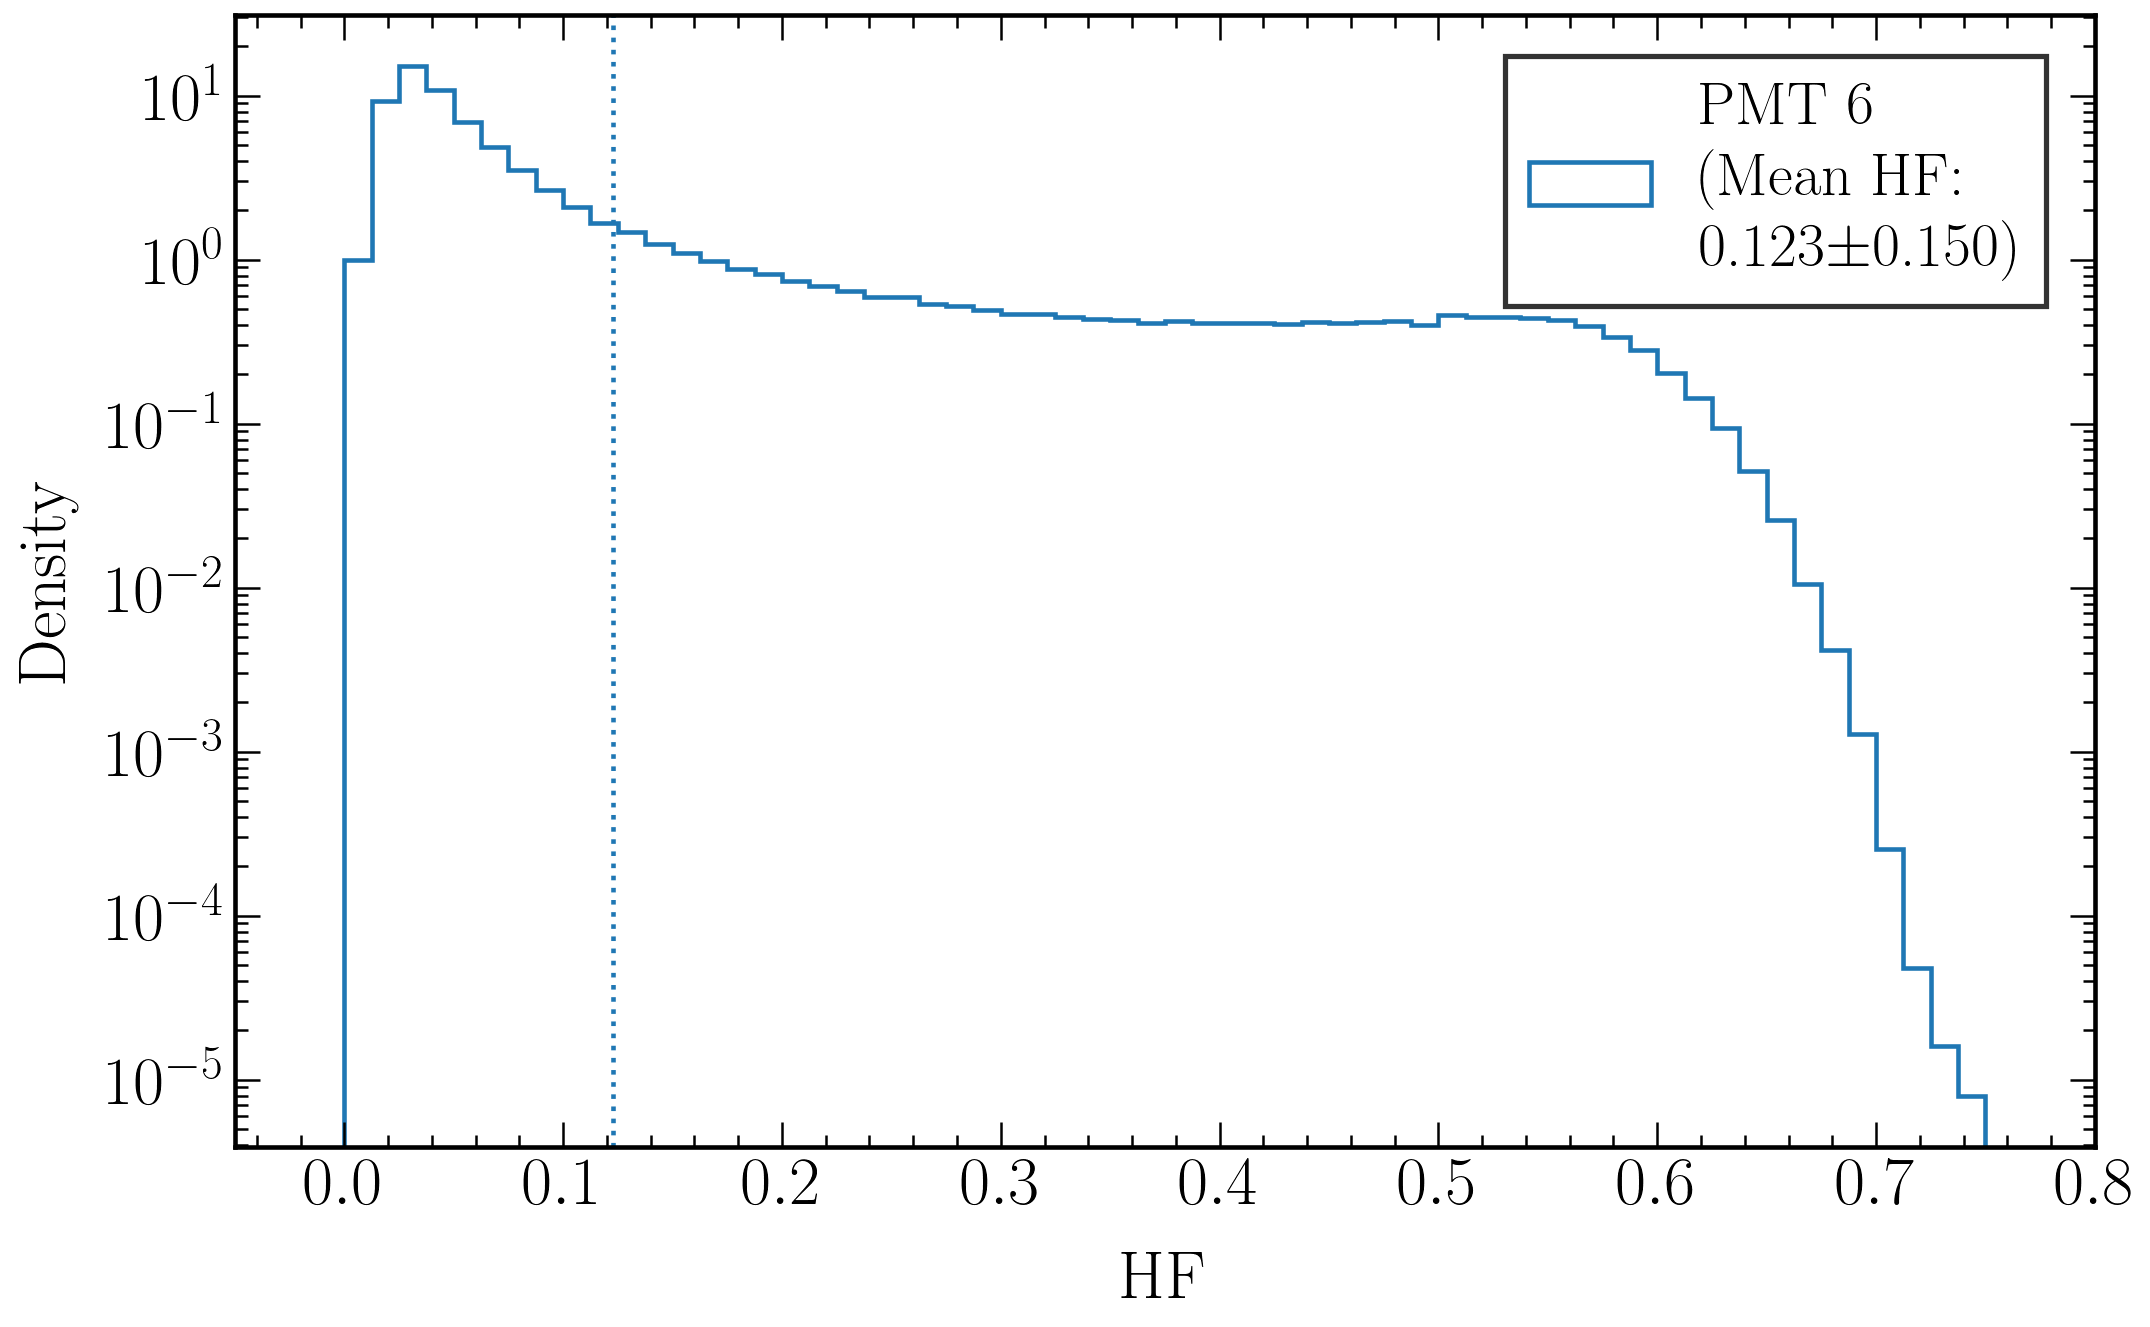

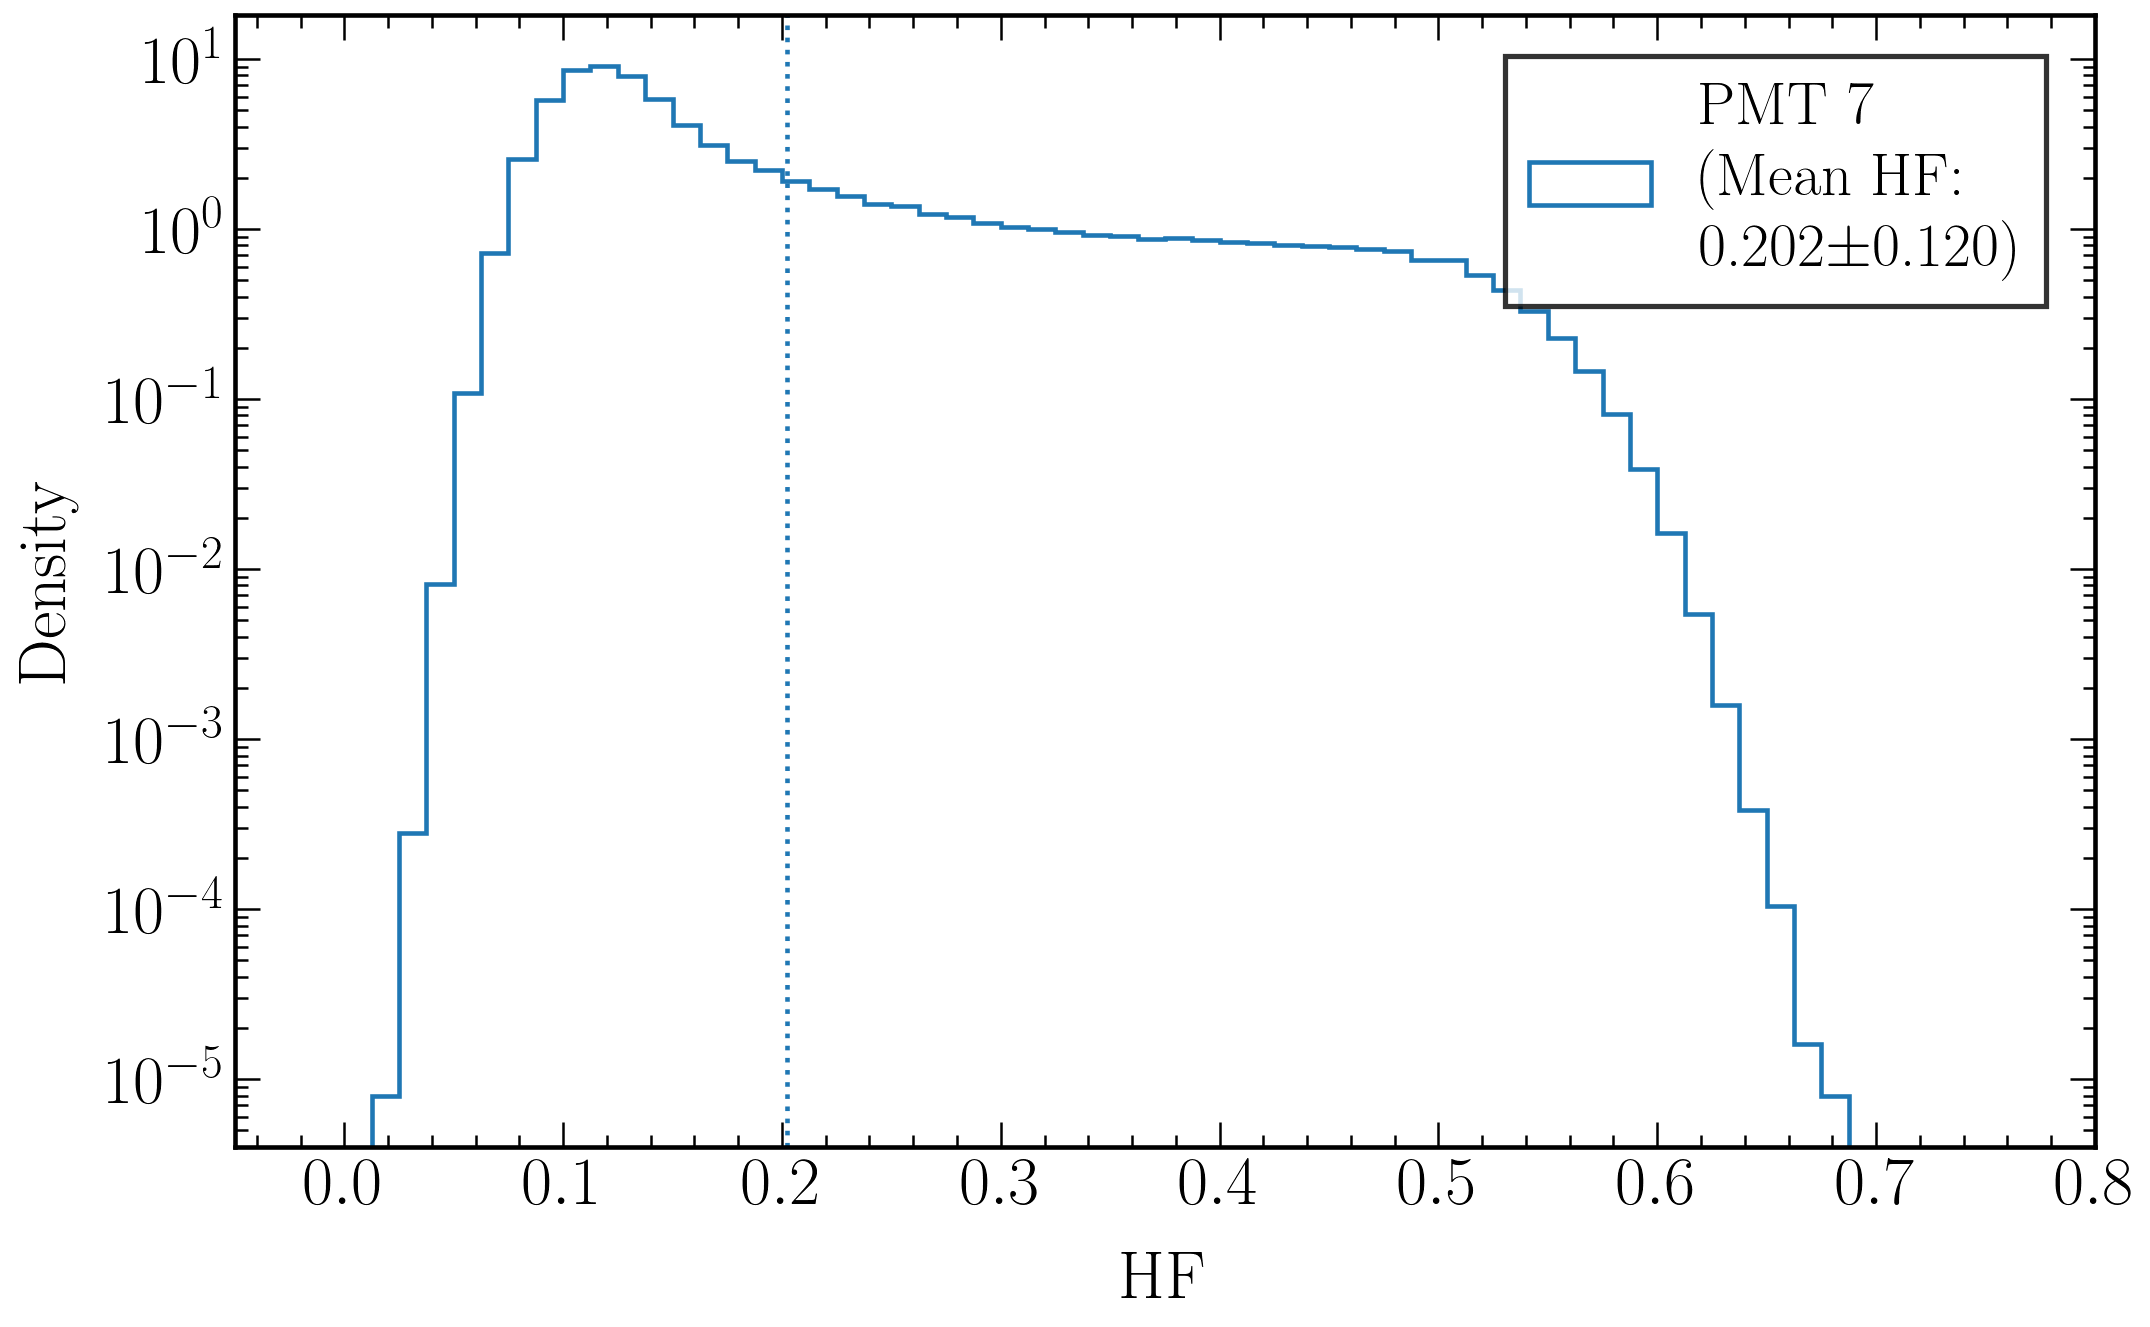

In [21]:
for i in range(1,8):
    
    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot

    plt.hist(_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits'], bins = 80, histtype='step', linewidth = 2.2, 
             density = True, color = 'C0', range = (0,1),
             label = "PMT "+str(i)+"\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits']).std(), 2))+")")
    plt.axvline(x=(_chunk_collect['pmthits_'+str(i)]/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

    plt.xlabel('HF', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
    #plt.title('HF per PMT', fontsize = title_size, pad = title_pad)

    plt.xlim(-0.05,0.8)
    plt.yscale('log')

    # Legend
    leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    #leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig(filenameprefix+"_HF_PMT"+str(i)+"_hist_scaled_fixedbinning_log.png")
    plt.show()

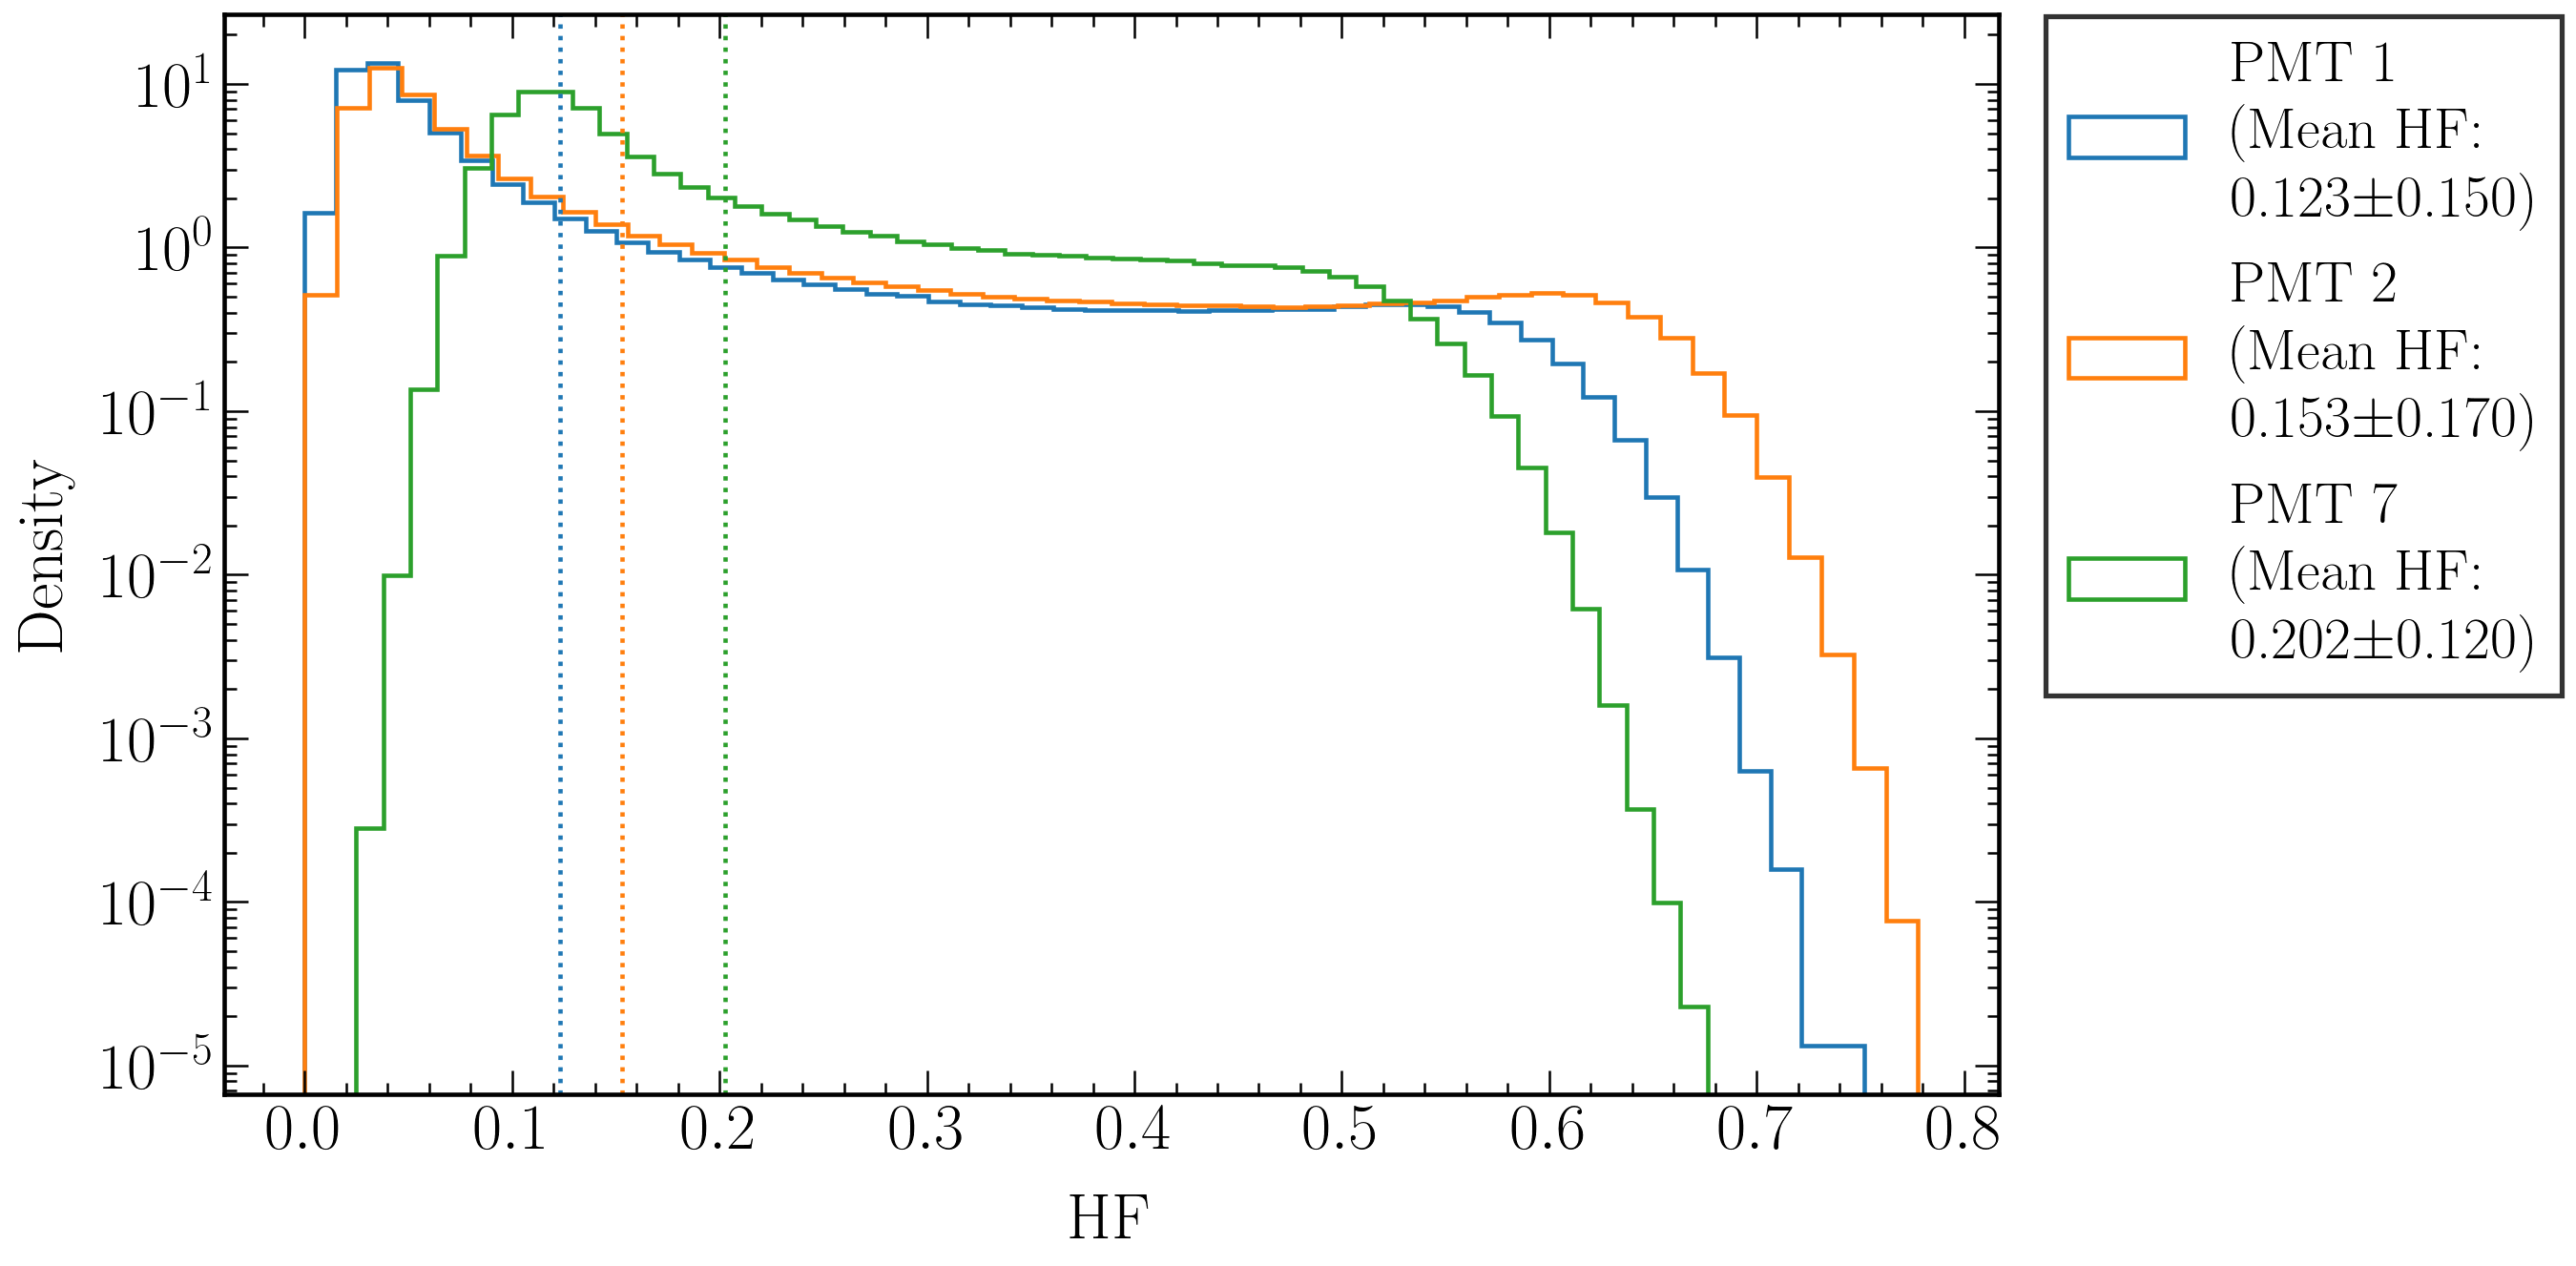

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C0', 
         label = "PMT 1\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_1']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C1', 
         label = "PMT 2\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_2']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, 
         density = True, color = 'C2', 
         label = "PMT 7\n(Mean HF:\n"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig((_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).std(), 2))+")")
plt.axvline(x=(_chunk_collect['pmthits_7']/_chunk_collect['ntpmthits']).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('HF', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('HF per PMT', fontsize = title_size, pad = title_pad)

plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_HF_PMT127_hist_log.png", bbox_inches='tight')
plt.show()

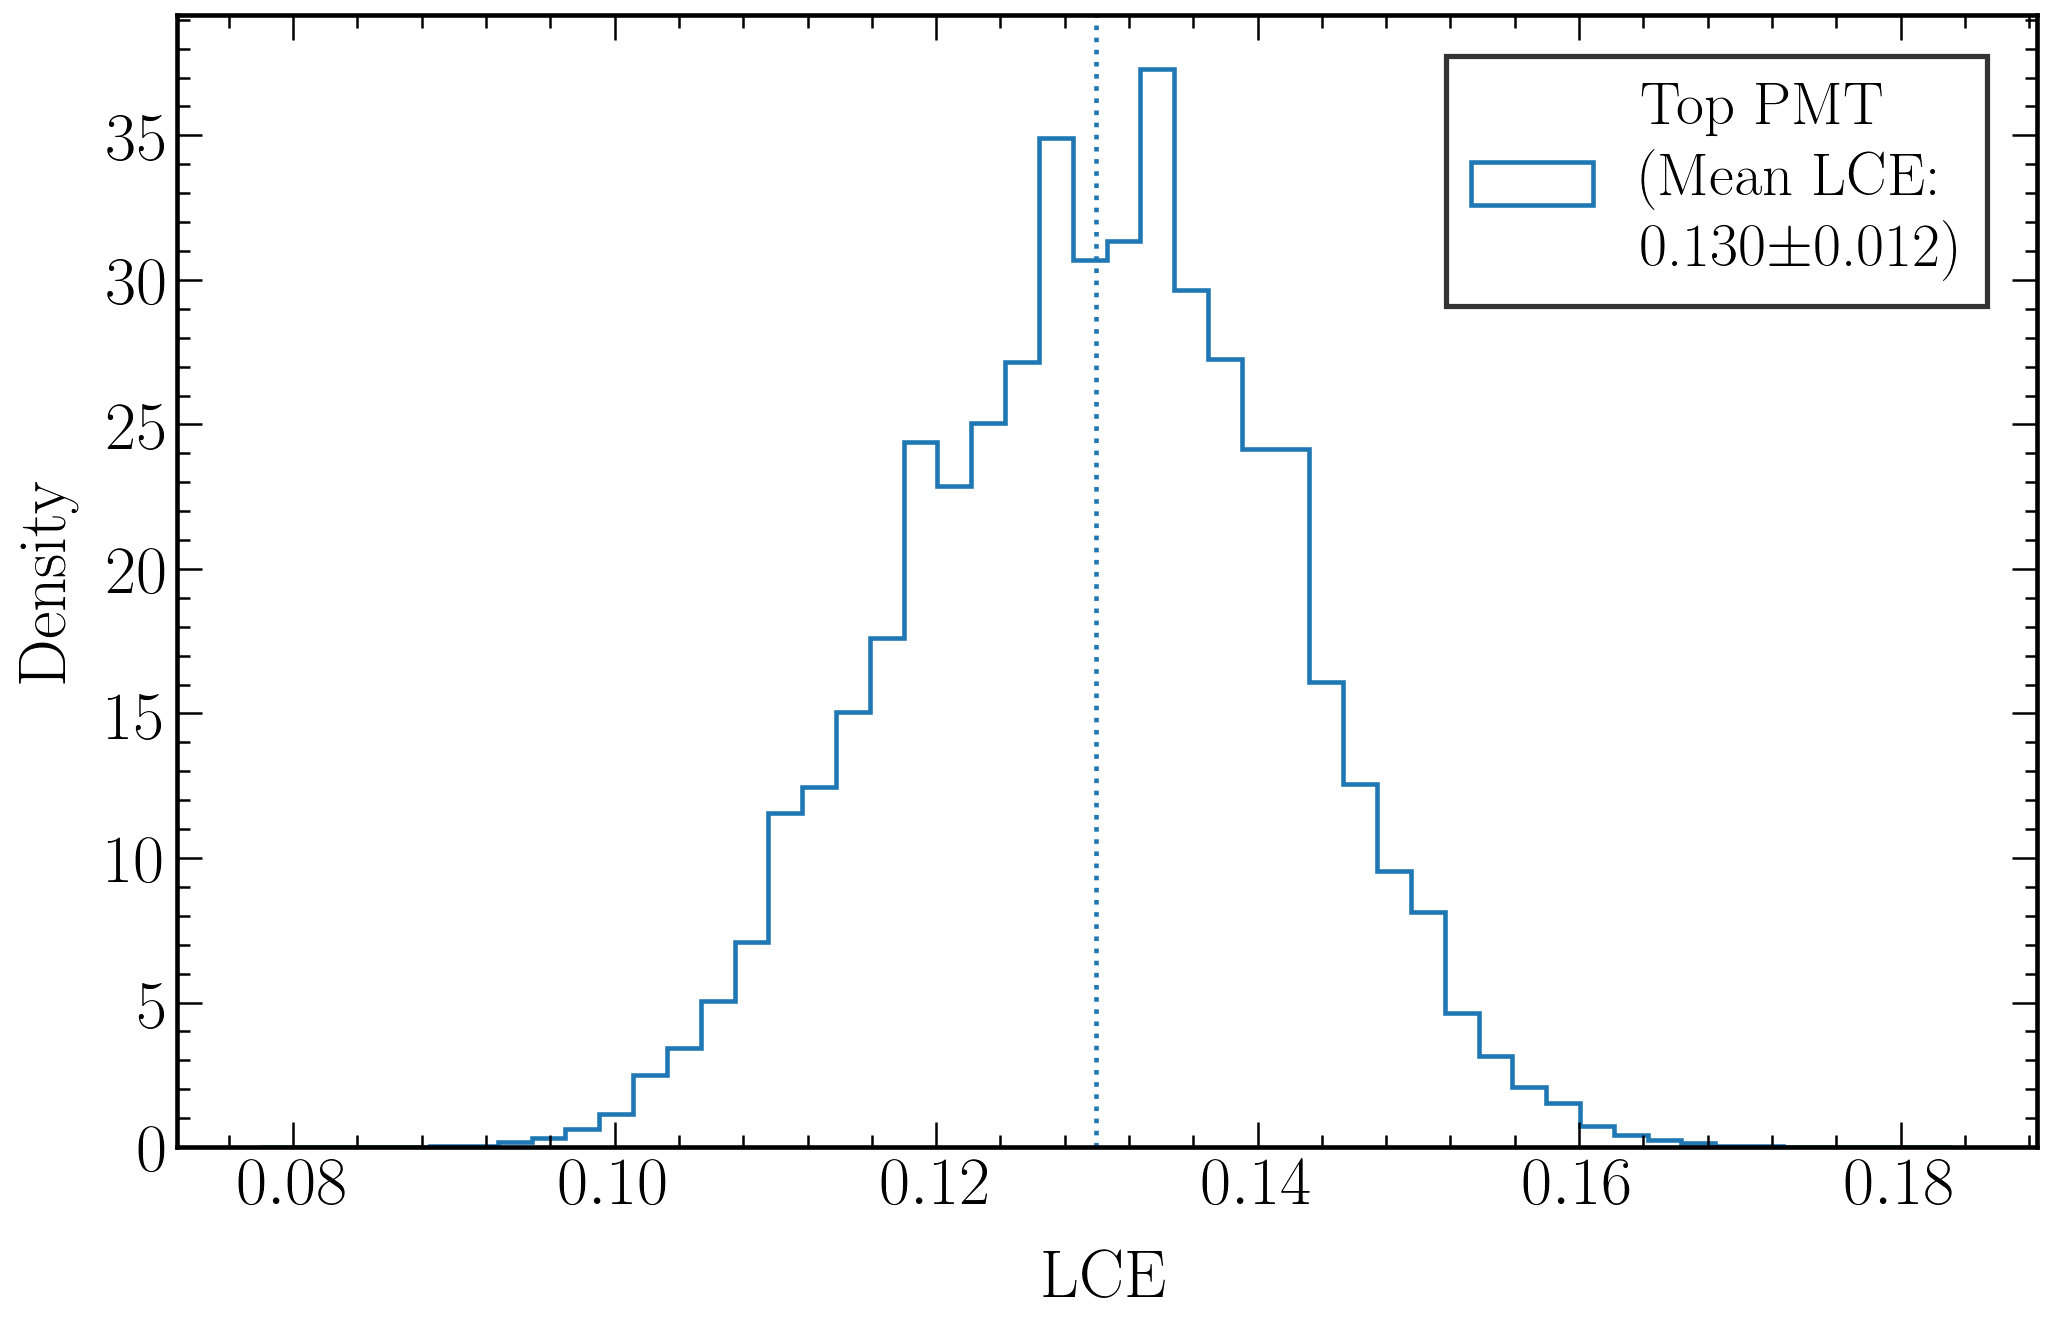

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', 
         label = "Top PMT\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['ntpmthits'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['ntpmthits'].std(), 2))+")")
plt.axvline(x=_chunk_collect['ntpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMTtop_hist.png")
plt.show()

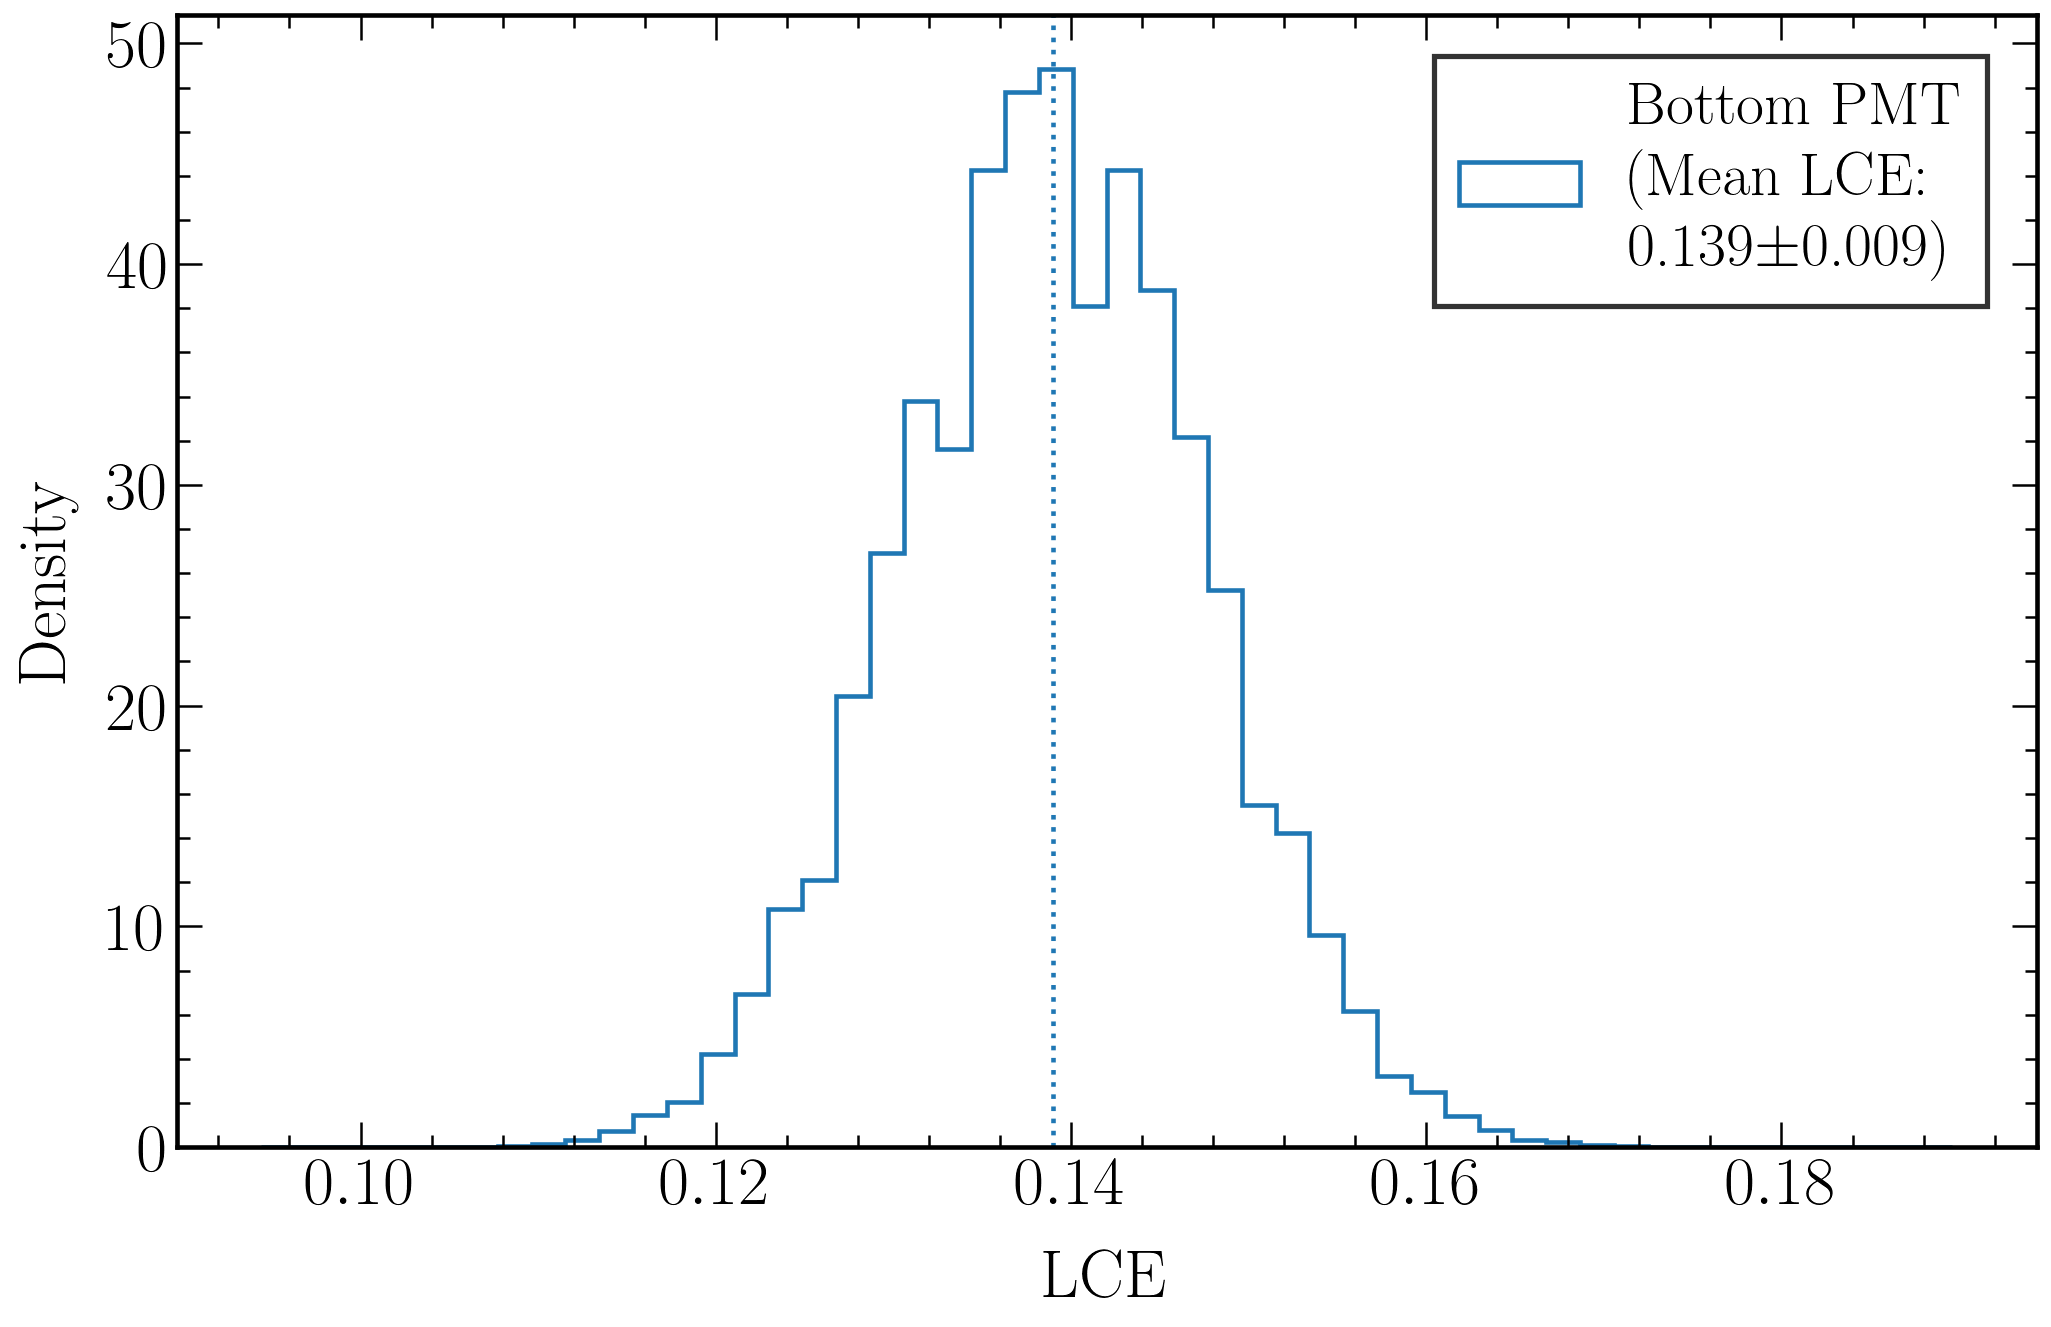

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['nbpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', 
         label = "Bottom PMT\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['nbpmthits'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['nbpmthits'].std(), 2))+")")
plt.axvline(x=_chunk_collect['nbpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMTbottom_hist.png")
plt.show()

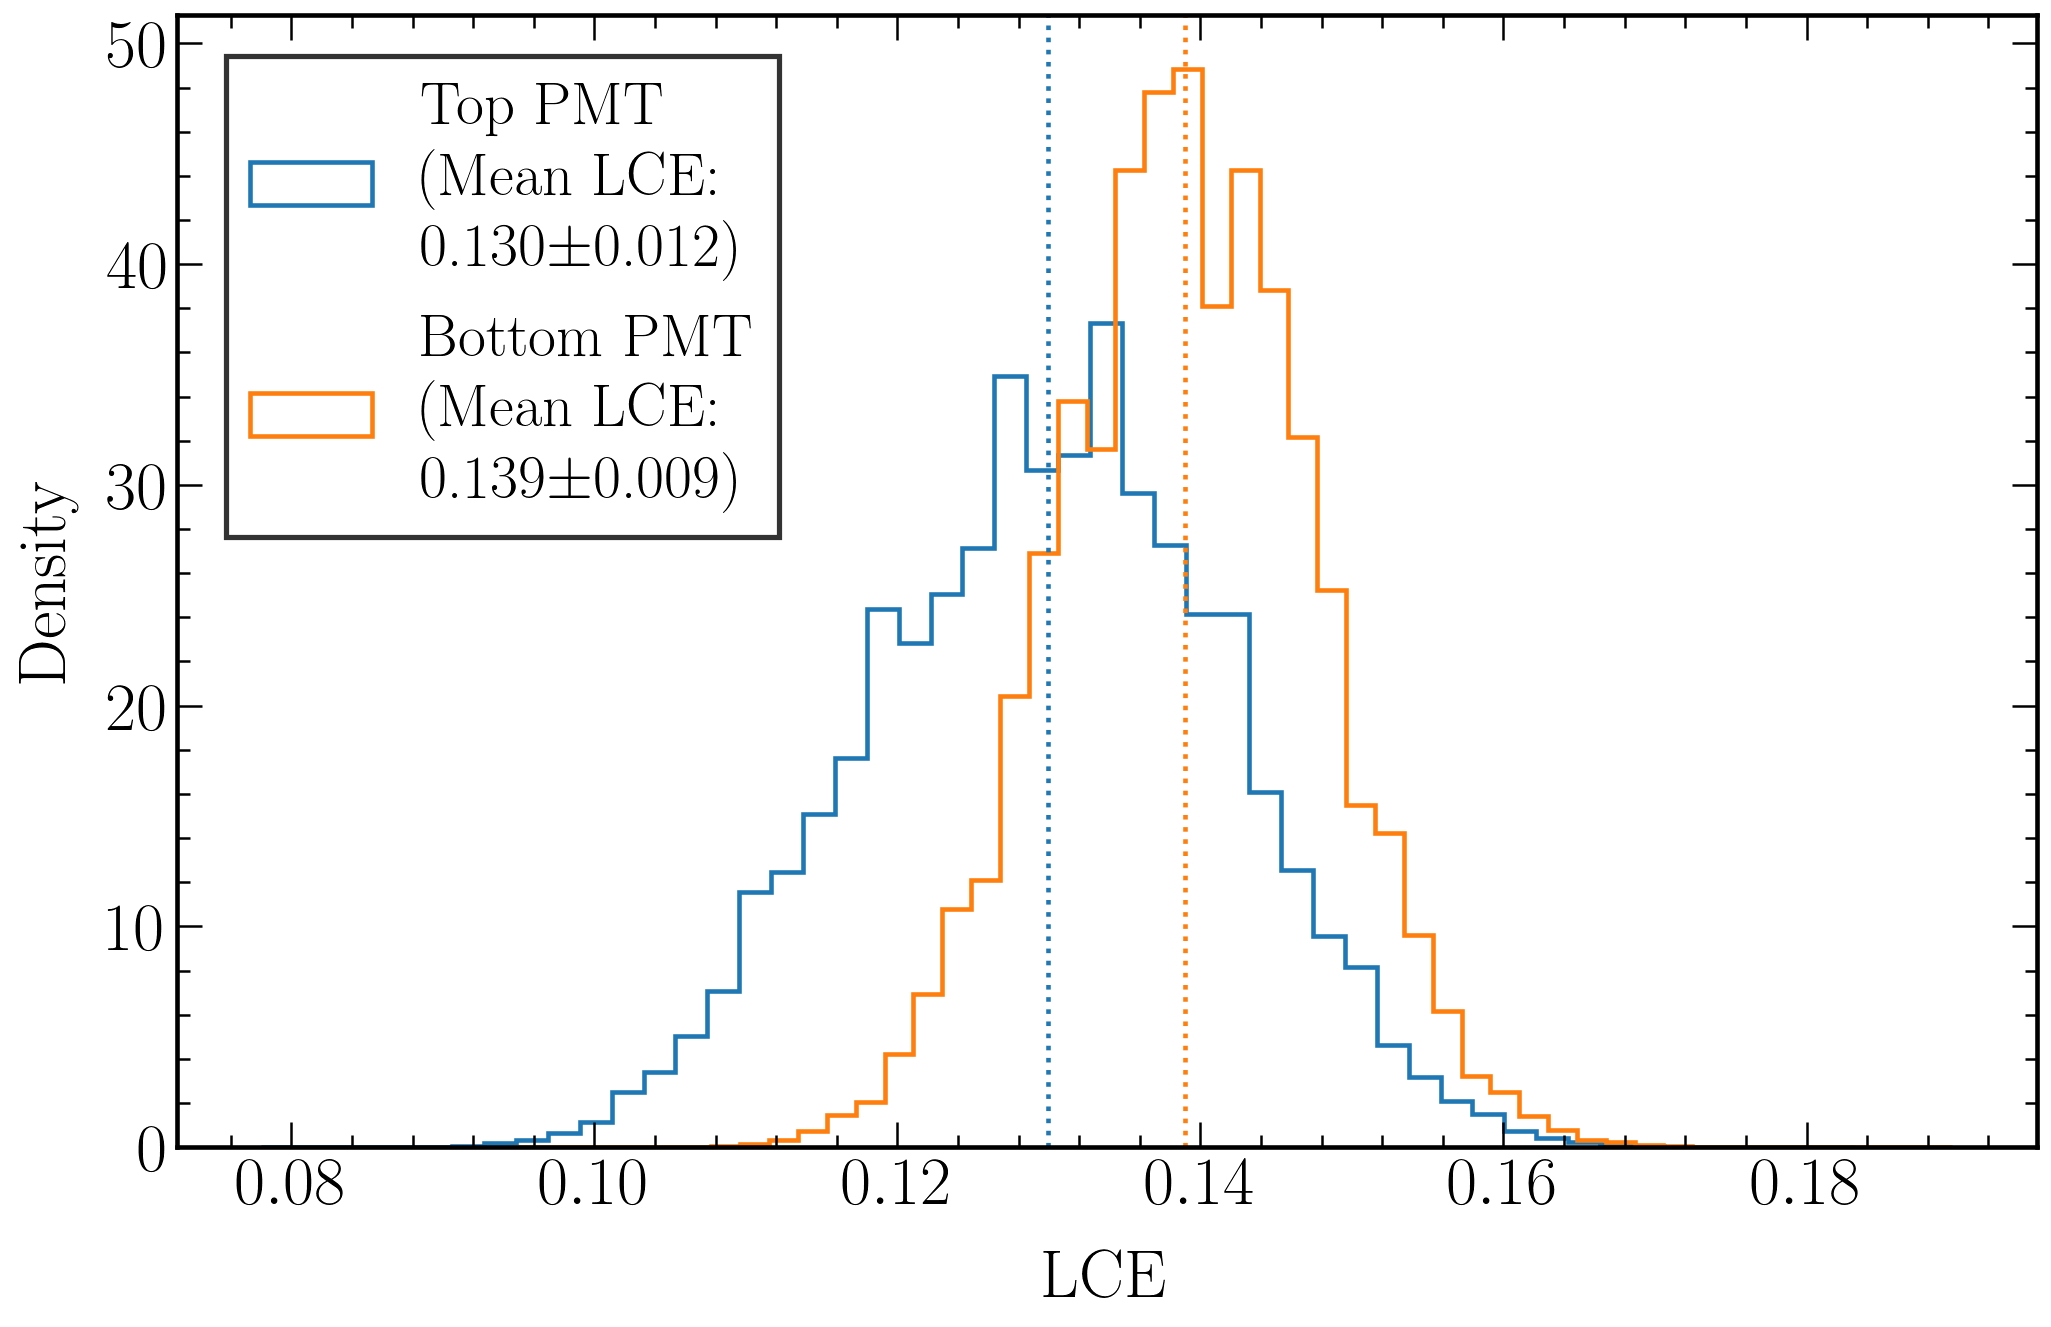

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', 
         label = "Top PMT\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['ntpmthits'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['ntpmthits'].std(), 2))+")")
plt.axvline(x=_chunk_collect['ntpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['nbpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C1', 
         label = "Bottom PMT\n(Mean LCE:\n"+"{0:.3f}".format(round_sig(_chunk_collect['nbpmthits'].mean(), 3))+"$\pm$"+"{0:.3f}".format(round_sig(_chunk_collect['nbpmthits'].std(), 2))+")")
plt.axvline(x=_chunk_collect['nbpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMTbottomtop_hist.png")
plt.show()

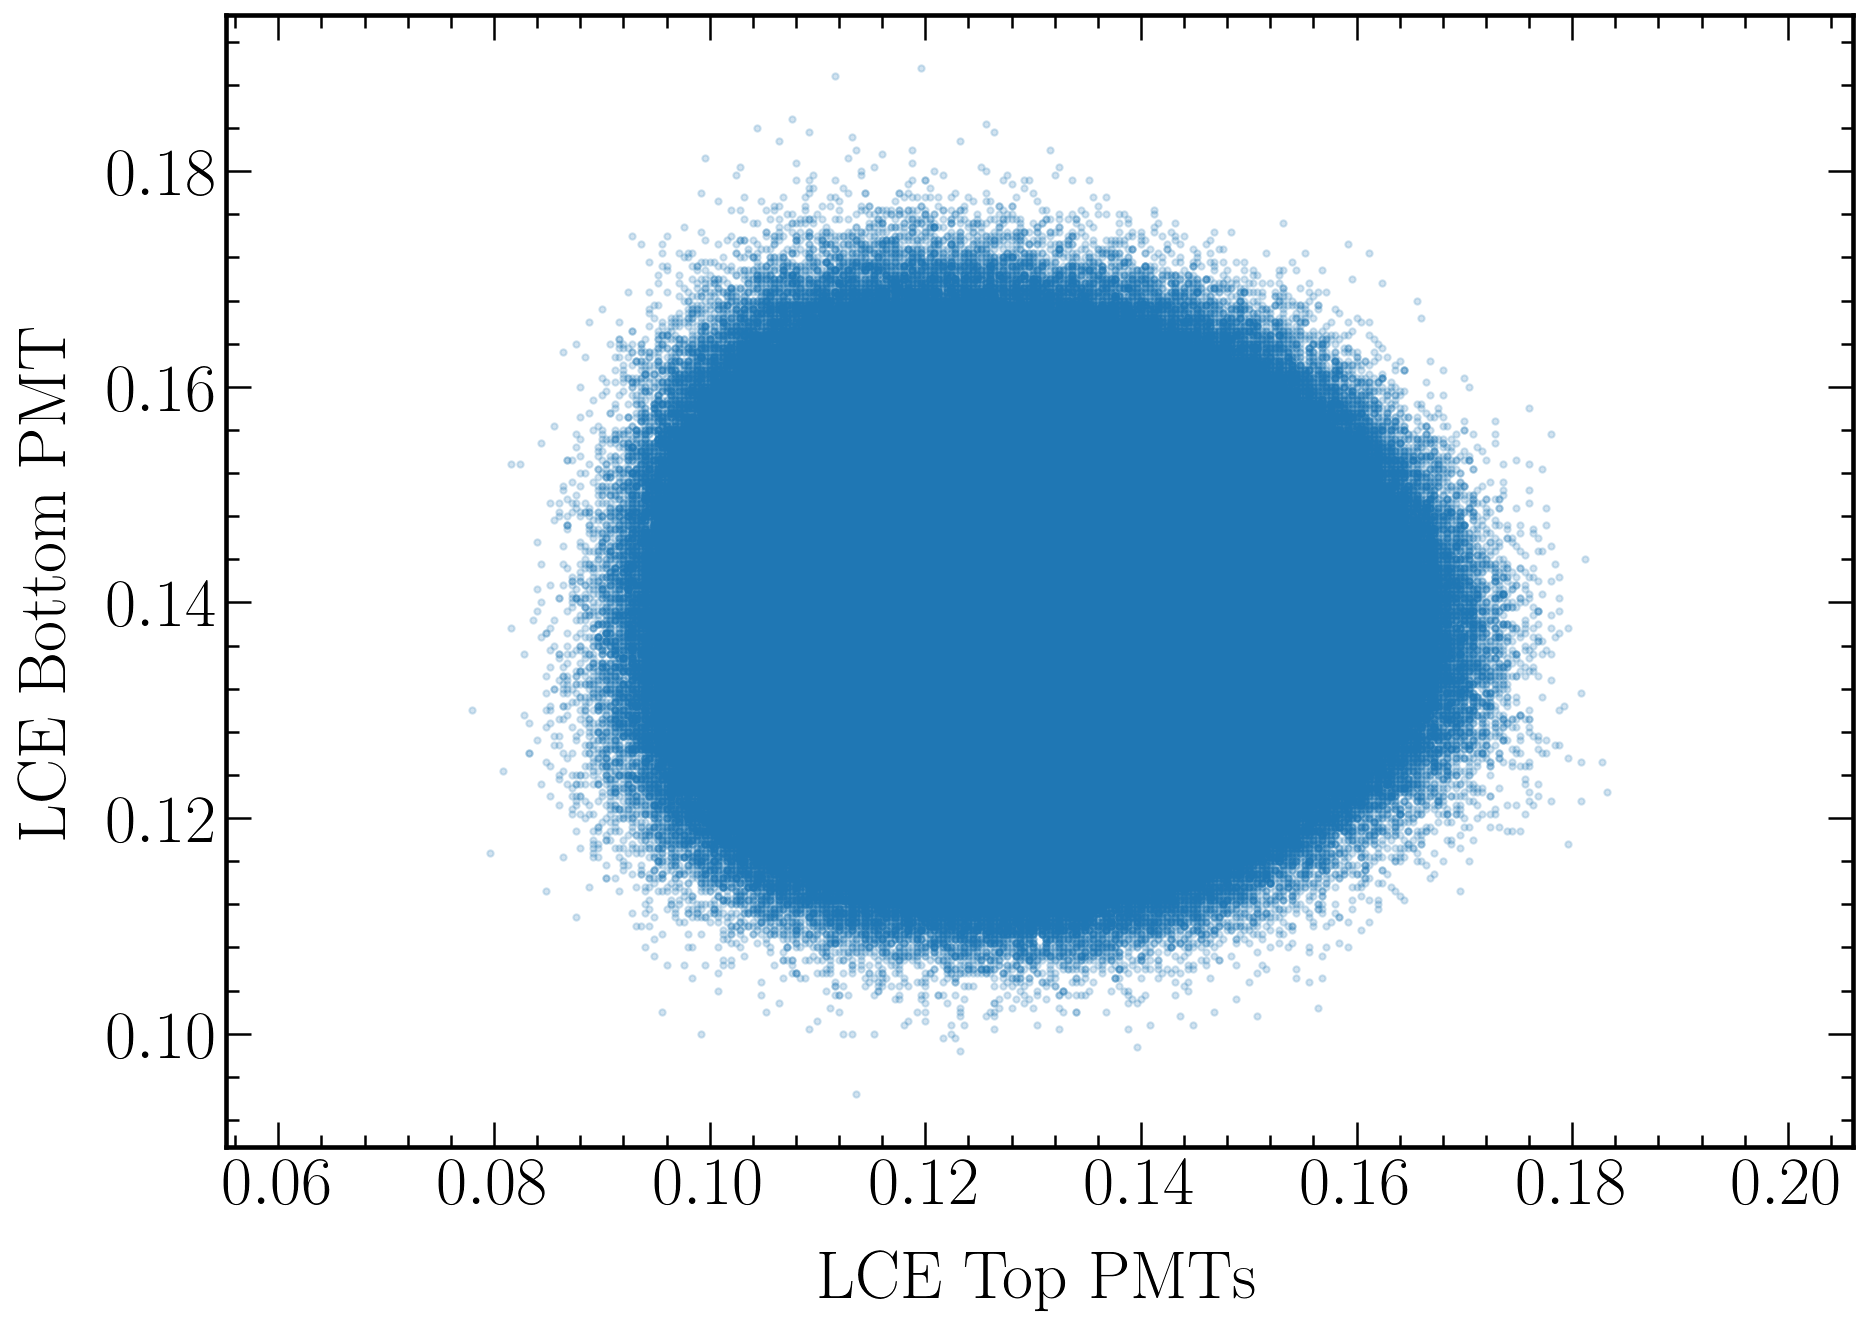

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(14, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.gca().set_aspect('equal', adjustable='box')
plt.axis('equal')
plt.scatter(_chunk_collect['ntpmthits'], _chunk_collect['nbpmthits'], marker = '.', alpha = 0.2)

plt.xlabel('LCE Top PMTs', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE Bottom PMT', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

fig.savefig(filenameprefix+"_LCE_PMTbottomtop_scatter.png")
plt.show()

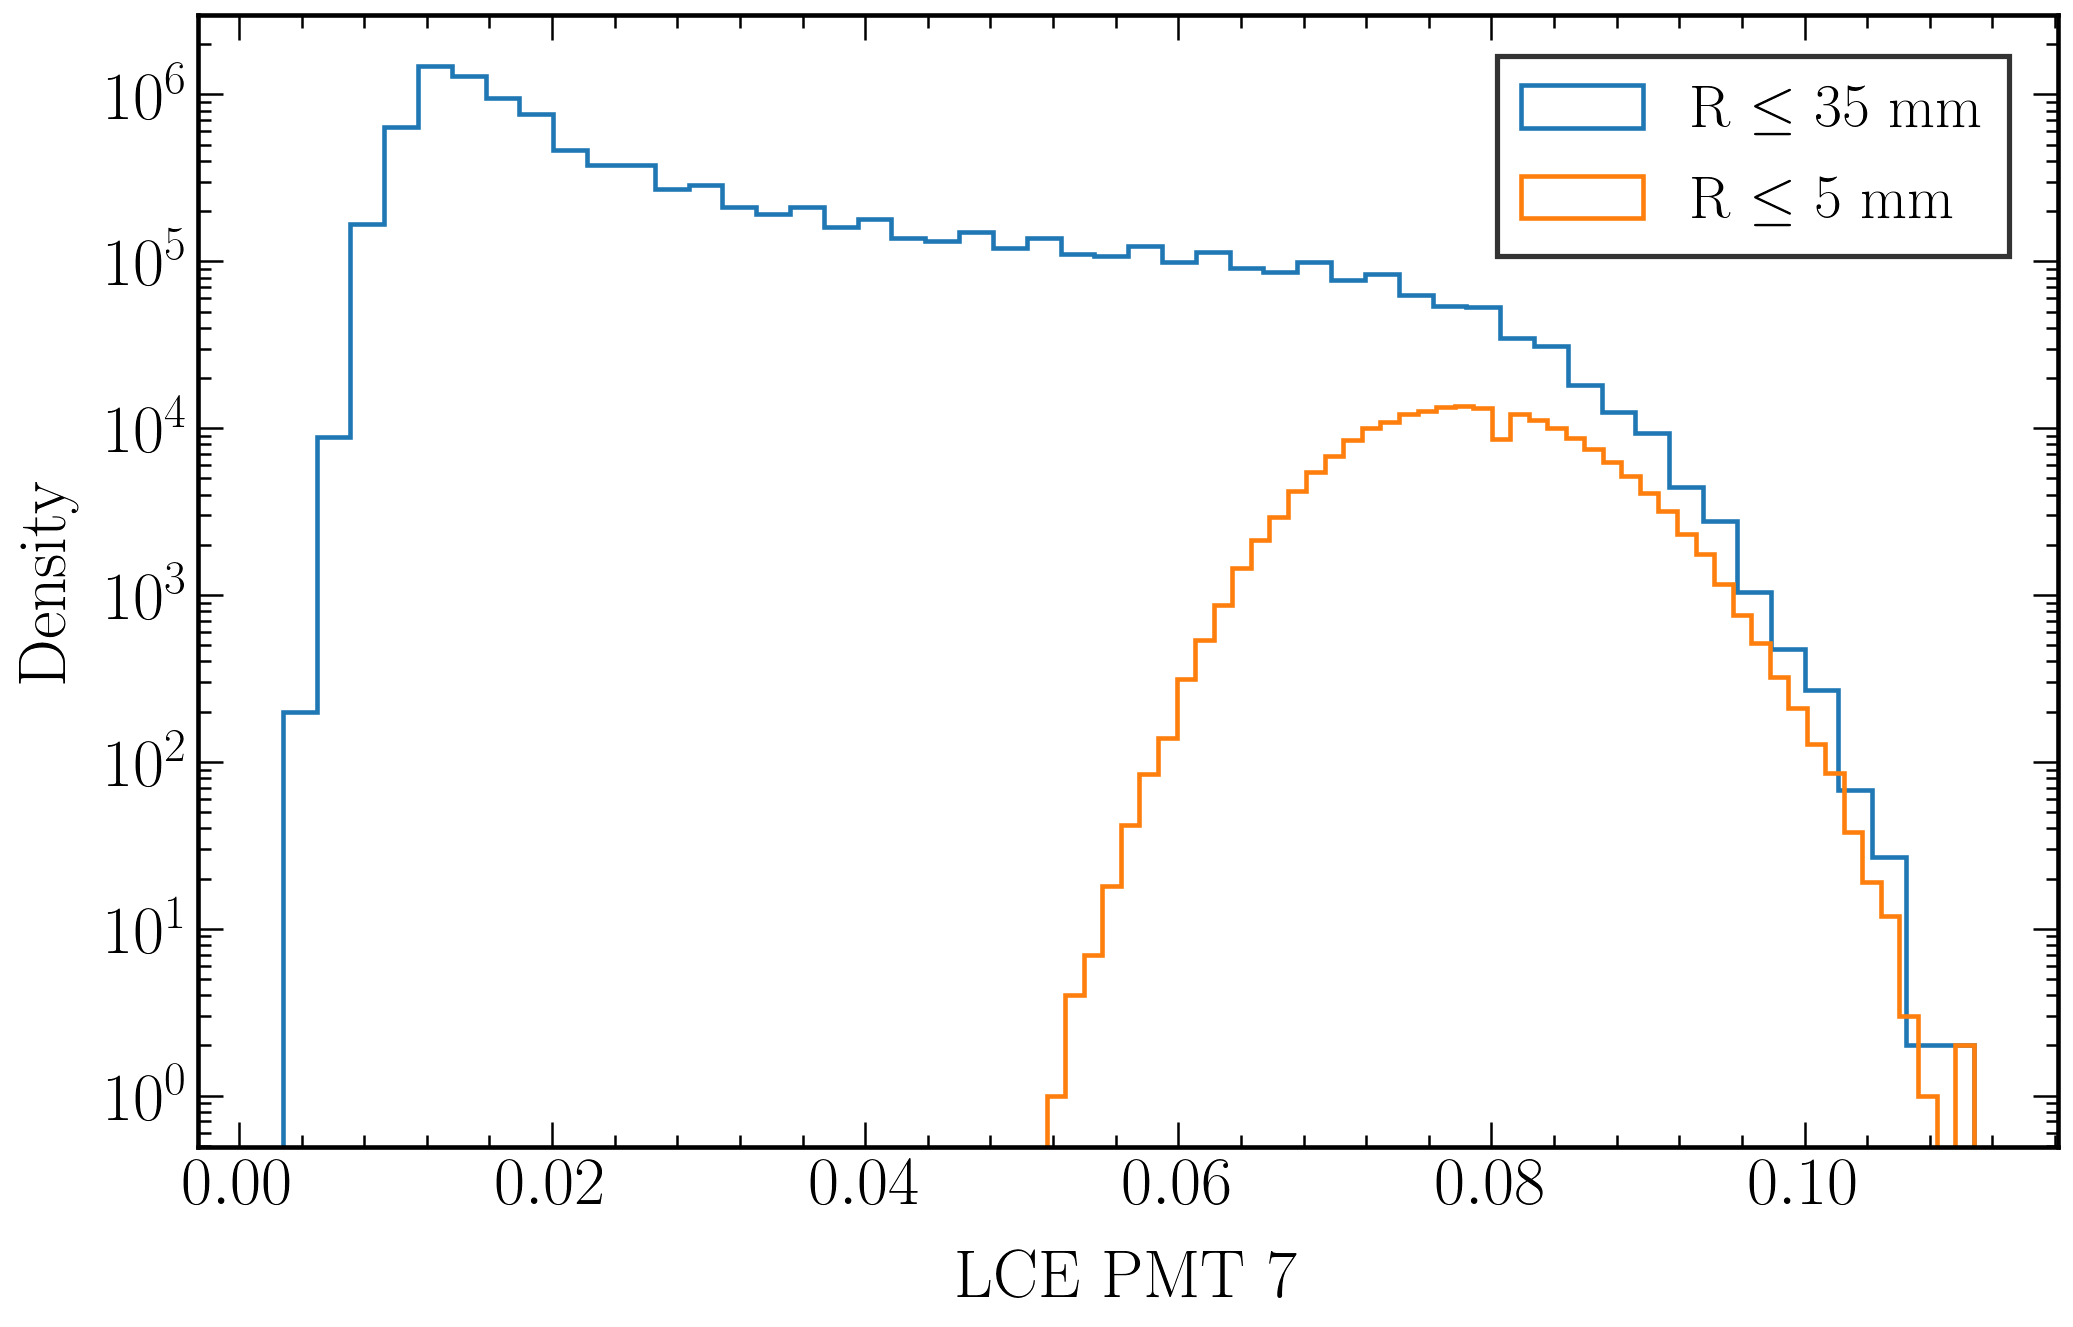

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_7'], bins = 50, histtype='step', linewidth = 2.2, label = 'R $\leq$ 35 mm')
plt.hist(_chunk_collect['pmthits_7'][np.sqrt(_chunk_collect['xp_pri']**2 + _chunk_collect['yp_pri']**2) <= 5], bins = 50, histtype='step', linewidth = 2.2, label = 'R $\leq$ 5 mm')
plt.yscale('log')

plt.xlabel('LCE PMT 7', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT7_conf_hist.png")
plt.show()

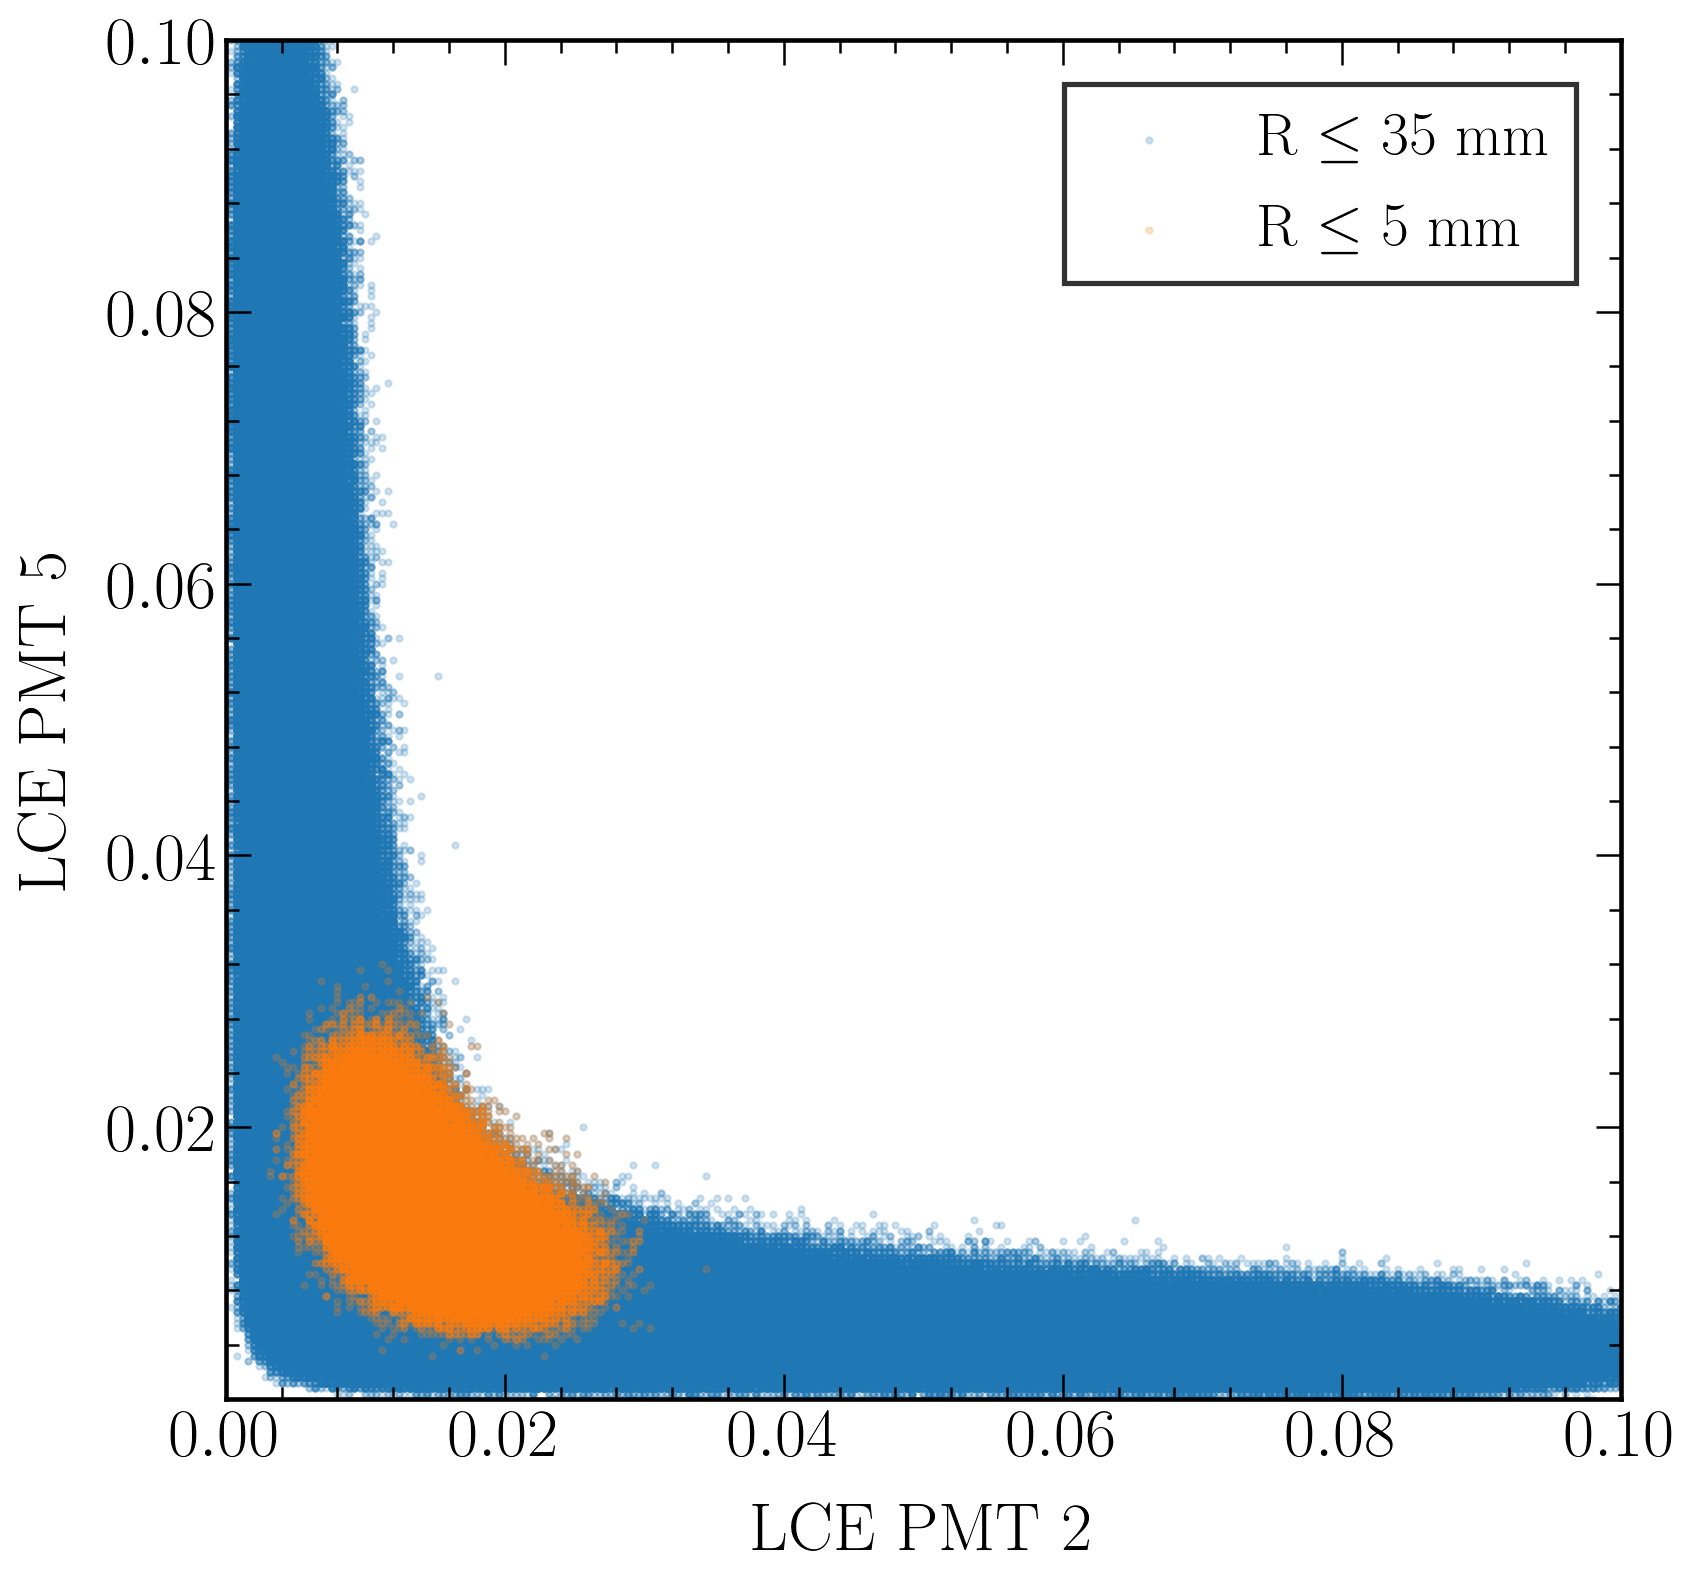

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(12, 12), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.scatter(_chunk_collect['pmthits_2'], _chunk_collect['pmthits_5'], marker = '.', label = 'R $\leq$ 35 mm', alpha = 0.2)
ct = 5
plt.scatter(_chunk_collect['pmthits_2'][np.sqrt(_chunk_collect['xp_pri']**2 + _chunk_collect['yp_pri']**2) < ct], _chunk_collect['pmthits_5'][np.sqrt(_chunk_collect['xp_pri']**2 + _chunk_collect['yp_pri']**2) < ct], marker = '.', label = 'R $\leq$ '+str(ct)+' mm', alpha = 0.2)
plt.ylim(bottom = 0)
plt.xlim(left = 0)

plt.xticks(np.arange(0.0, 0.11, 0.02))
plt.yticks(np.arange(0.02, 0.11, 0.02))
plt.xlim(0.0, 0.1)
plt.ylim(0.0, 0.1)

plt.xlabel('LCE PMT 2', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE PMT 5', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT25_scatter.png")
plt.show()

## Comparison to measurements

In [29]:
ls /home/ab602/Thesis/Xebra_Measurements_Analysis/S2_AFT/output/*.pkl

ls: cannot access '/home/ab602/Thesis/Xebra_Measurements_Analysis/S2_AFT/output/*.pkl': No such file or directory


In [30]:
#### Import processed measurements data

## Define run to be used
## Good Kr83m runs concerning S2 AFT: 00157, 00158, (00159,) 00163
run = "00158"

## Import pandas dataframe from pkl
try:
    df_meas = pd.read_pickle("/home/ab602/Thesis/Xebra_Measurements_Analysis/S2_AFT/output/run_"+run+"_Kr83m_S2_AFT.pkl")
except:
    pass
try:
    df_meas = pd.read_pickle("/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_"+run+"_Kr83m_S2_AFT.pkl")
except:
    print('Selected file cannot be found.')
    
filenameprefix_meas = "run_"+run+"_Kr83m_S2_AFT"
print(filenameprefix_meas)
df_meas

run_00158_Kr83m_S2_AFT


PMT1  \
area                 [81.51187, 58.73296, 505.49127, 329.77402, 336...   
HF                   [0.03403163464572272, 0.021447941888815488, 0....   
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.0849843310139693, 10.091889307908854, ...   

                                                                  PMT2  \
area                 [54.27654, 81.40954, 1438.9236, 235.8328, 1276...   
HF                   [0.022660740204117076, 0.029728912922178632, 0...   
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.11472884686885855, 10.559303128485686,...   

                                                                  PMT3  \
area                 [155.54578, 162.00565, 153.64876, 153.18832, 2...   
HF                   [0.06494117905931028, 0.05916077941069192, 0.0...   
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.8370956604875976, 19.308440006373825, ...   

                                                                  PMT4  \
area                 [964.6338, 1214.074, 85.29809, 130.35835, 91.2...   
HF                   [0.40273967628852736, 0.4433522194041271, 0.02...   
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.22095926063632018, 19.6526265469804, 1...   

                                                                  PMT5  \
area                 [560.59515, 852.8486, 126.01928, 334.0981, 113...   
HF                   [0.23405142276139163, 0.3114409130092604, 0.04...   
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.012747649652095395, 0.7053699474159452...   

                                                                  PMT6  \
area                 [105.141235, 94.01074, 172.28401, 482.03452, 1...   
HF                   [0.04389701829874486, 0.03433058616553222, 0.0...   
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...   
hist_HF_n            [0.0, 0.004249216550698465, 0.7266160301694375...   

                                                                  PMT7  
area                 [473.47507, 275.31464, 595.08093, 1736.5447, 5...  
HF                   [0.19767832874218608, 0.1005386471993942, 0.19...  
hist_HF_bins_center  [-0.006250000000000002, 0.00625, 0.01875000000...  
hist_HF_n            [0.0, 0.0, 0.0, 0.0042492165506984635, 0.02974...

In [31]:
###########################
## Average equivalent PMTs
###########################

PMT1346_HF_hist = (df_meas['PMT1']['hist_HF_n']+df_meas['PMT3']['hist_HF_n']+df_meas['PMT4']['hist_HF_n']+df_meas['PMT6']['hist_HF_n'])/4
PMT1346_HF_hist_mean = (PMT1346_HF_hist*df_meas['PMT1']['hist_HF_bins_center']).sum()/(PMT1346_HF_hist.sum())

PMT25_HF_hist = (df_meas['PMT2']['hist_HF_n']+df_meas['PMT5']['hist_HF_n'])/2
PMT25_HF_hist_mean = (PMT25_HF_hist*df_meas['PMT2']['hist_HF_bins_center']).sum()/(PMT25_HF_hist.sum())

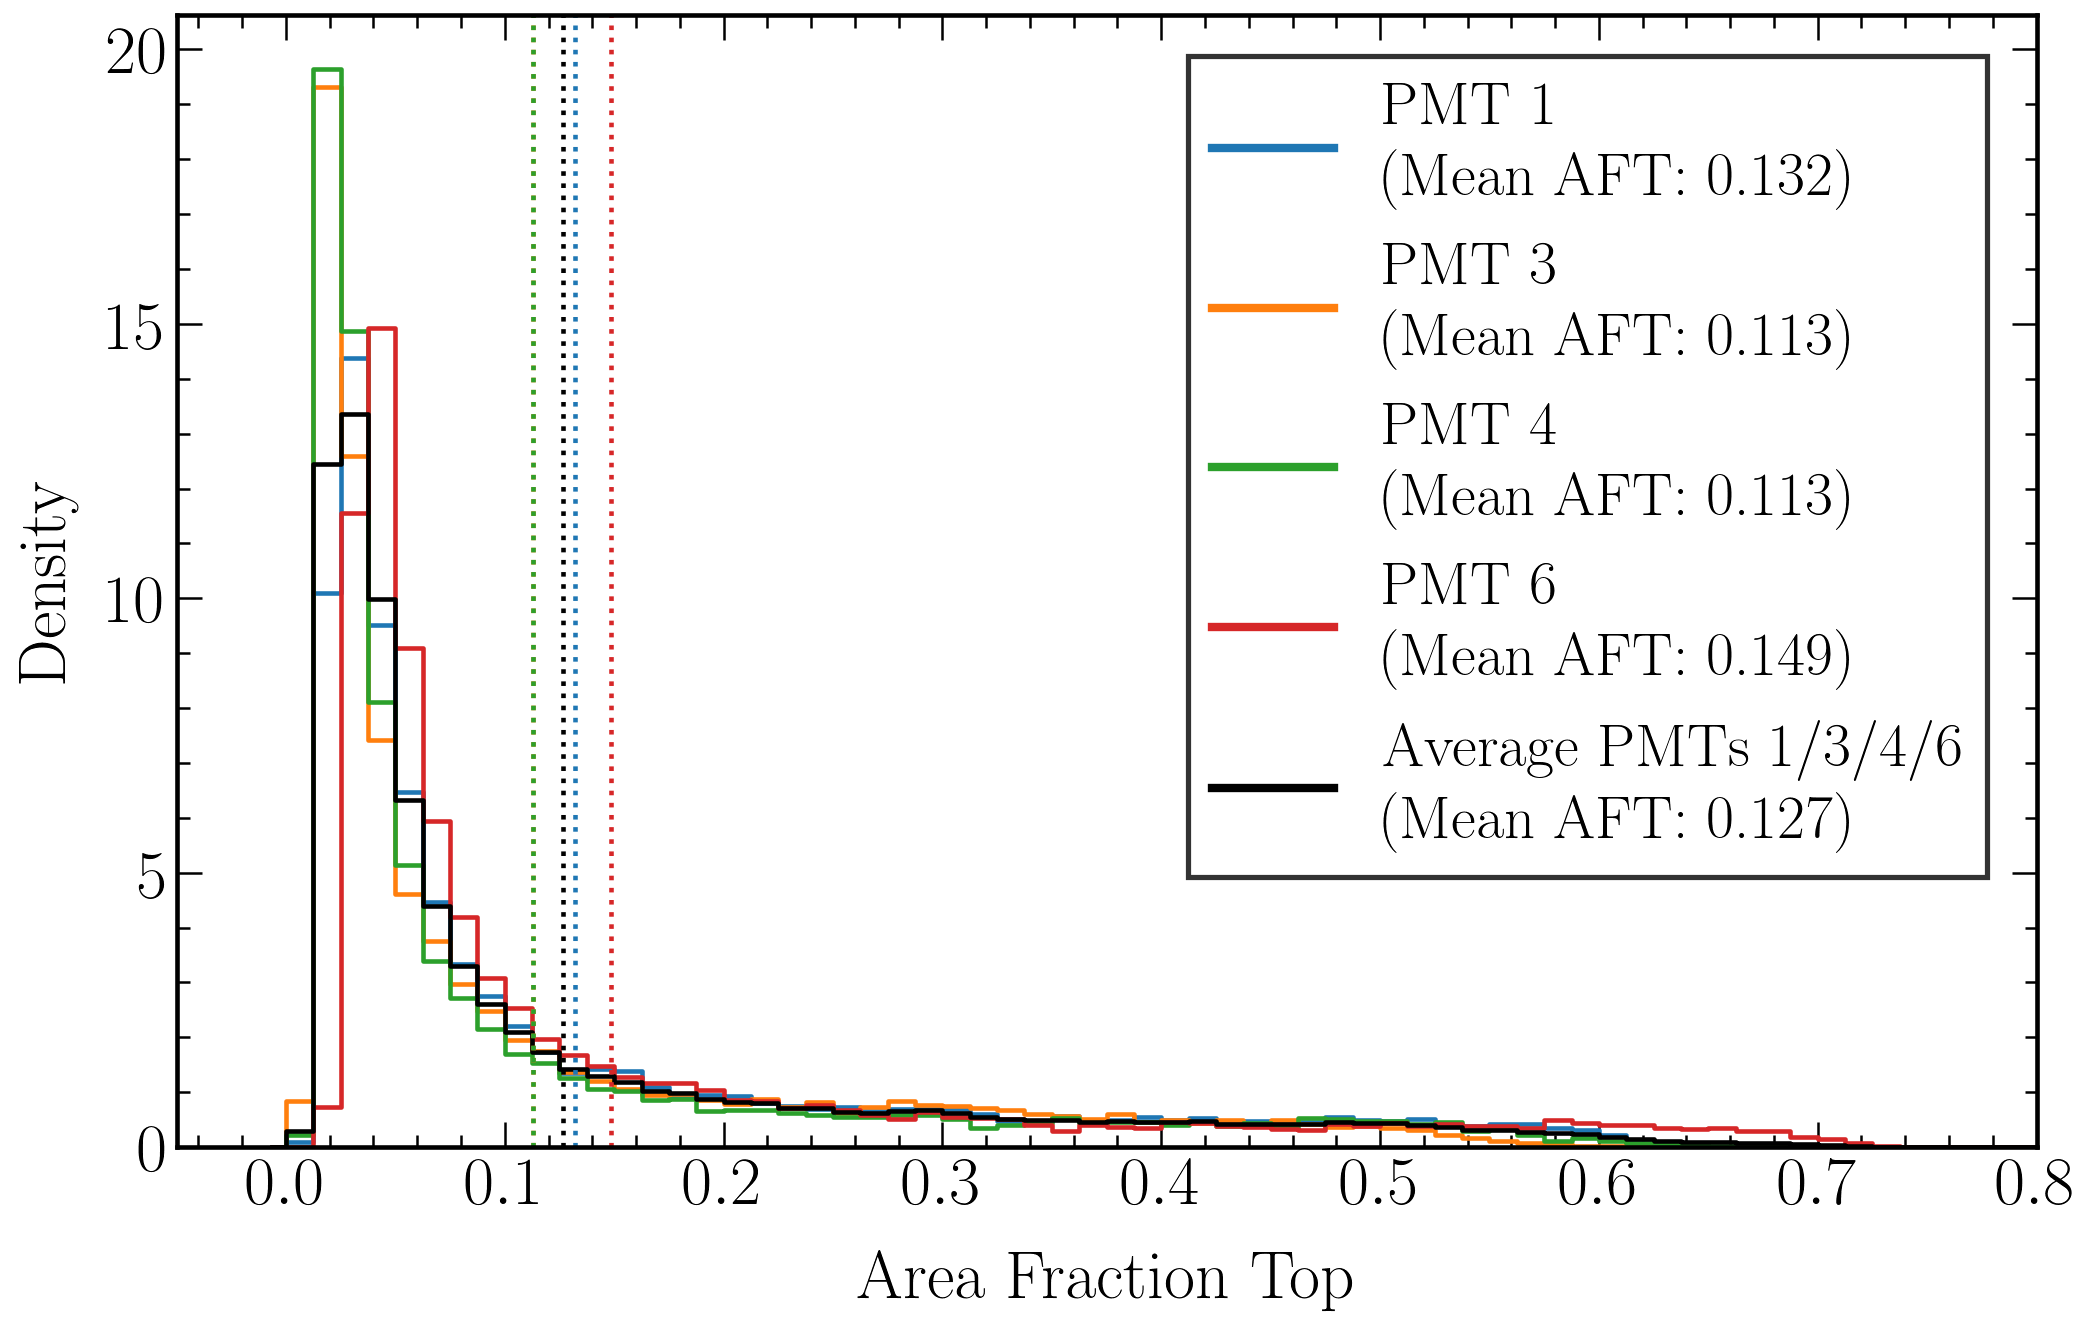

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT1']['hist_HF_bins_center'], df_meas['PMT1']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'PMT 1'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT1']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT3']['hist_HF_bins_center'], df_meas['PMT3']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'PMT 3'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT3']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT4']['hist_HF_bins_center'], df_meas['PMT4']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C2', 
         label = 'PMT 4'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT4']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT6']['hist_HF_bins_center'], df_meas['PMT6']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C3', 
         label = 'PMT 6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT6']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.2, color = 'k', 
         label = 'Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")

plt.axvline(x=(np.array(df_meas['PMT1']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.axvline(x=(np.array(df_meas['PMT3']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.axvline(x=(np.array(df_meas['PMT4']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')
plt.axvline(x=(np.array(df_meas['PMT6']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C3')
plt.axvline(x=PMT1346_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'k')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT1346_hist_scaled_fixedbinning.png")
plt.show()

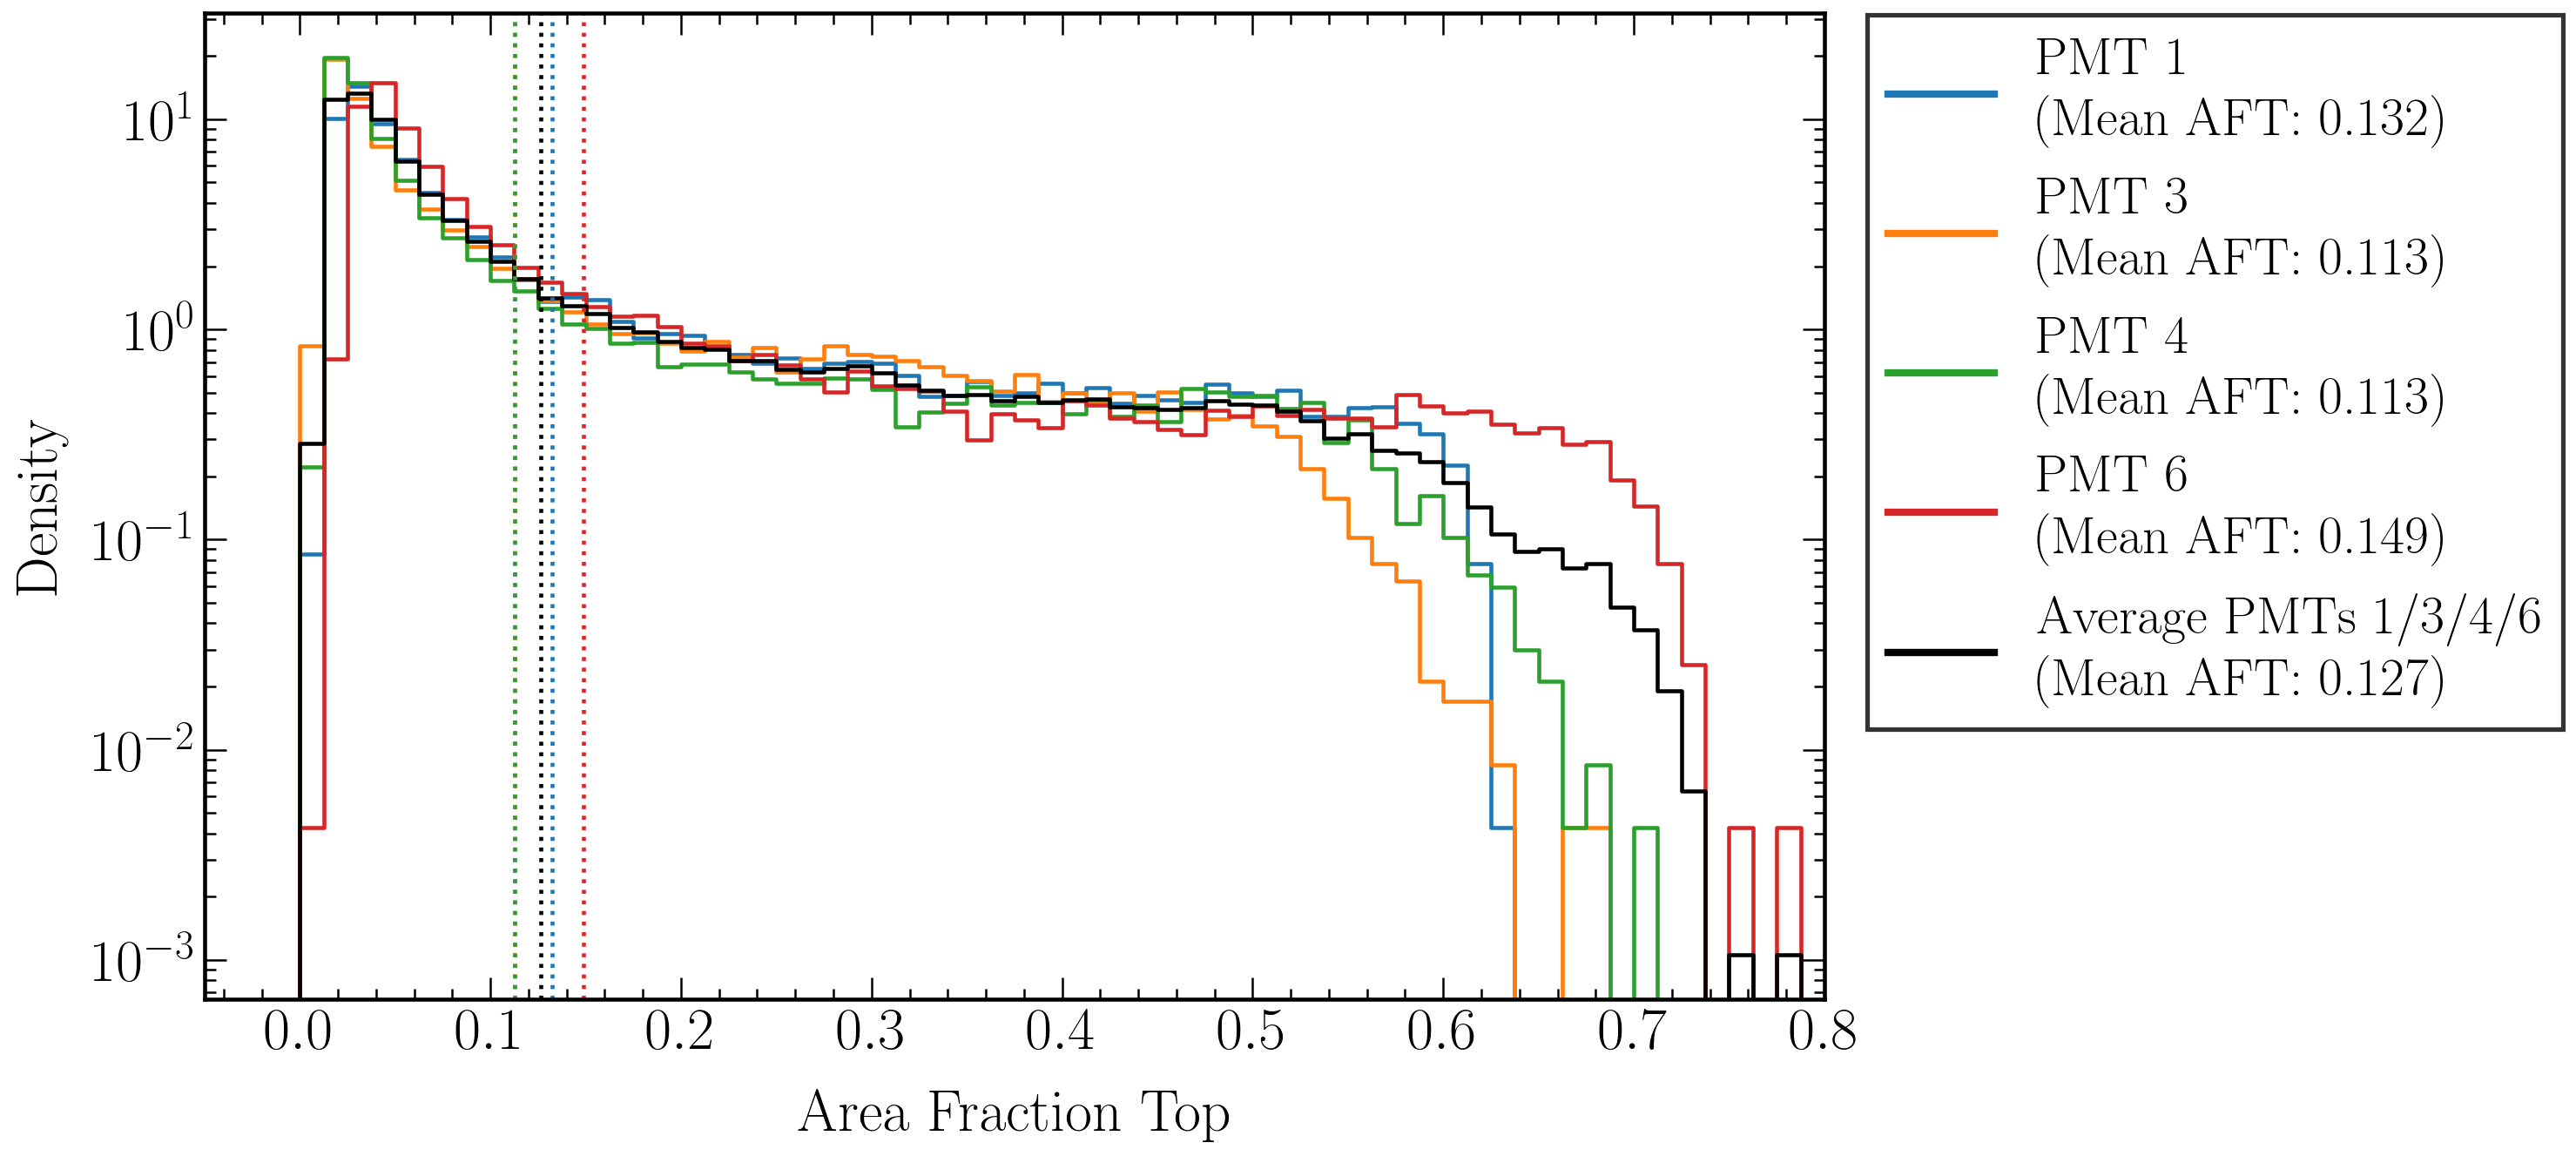

In [33]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT1']['hist_HF_bins_center'], df_meas['PMT1']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'PMT 1'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT1']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT3']['hist_HF_bins_center'], df_meas['PMT3']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'PMT 3'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT3']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT4']['hist_HF_bins_center'], df_meas['PMT4']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C2', 
         label = 'PMT 4'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT4']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT6']['hist_HF_bins_center'], df_meas['PMT6']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C3', 
         label = 'PMT 6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT6']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.2, color = 'k', 
         label = 'Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")

plt.axvline(x=(np.array(df_meas['PMT1']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.axvline(x=(np.array(df_meas['PMT3']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.axvline(x=(np.array(df_meas['PMT4']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')
plt.axvline(x=(np.array(df_meas['PMT6']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C3')
plt.axvline(x=PMT1346_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'k')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
#plt.ylim(bottom=0)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT1346_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()

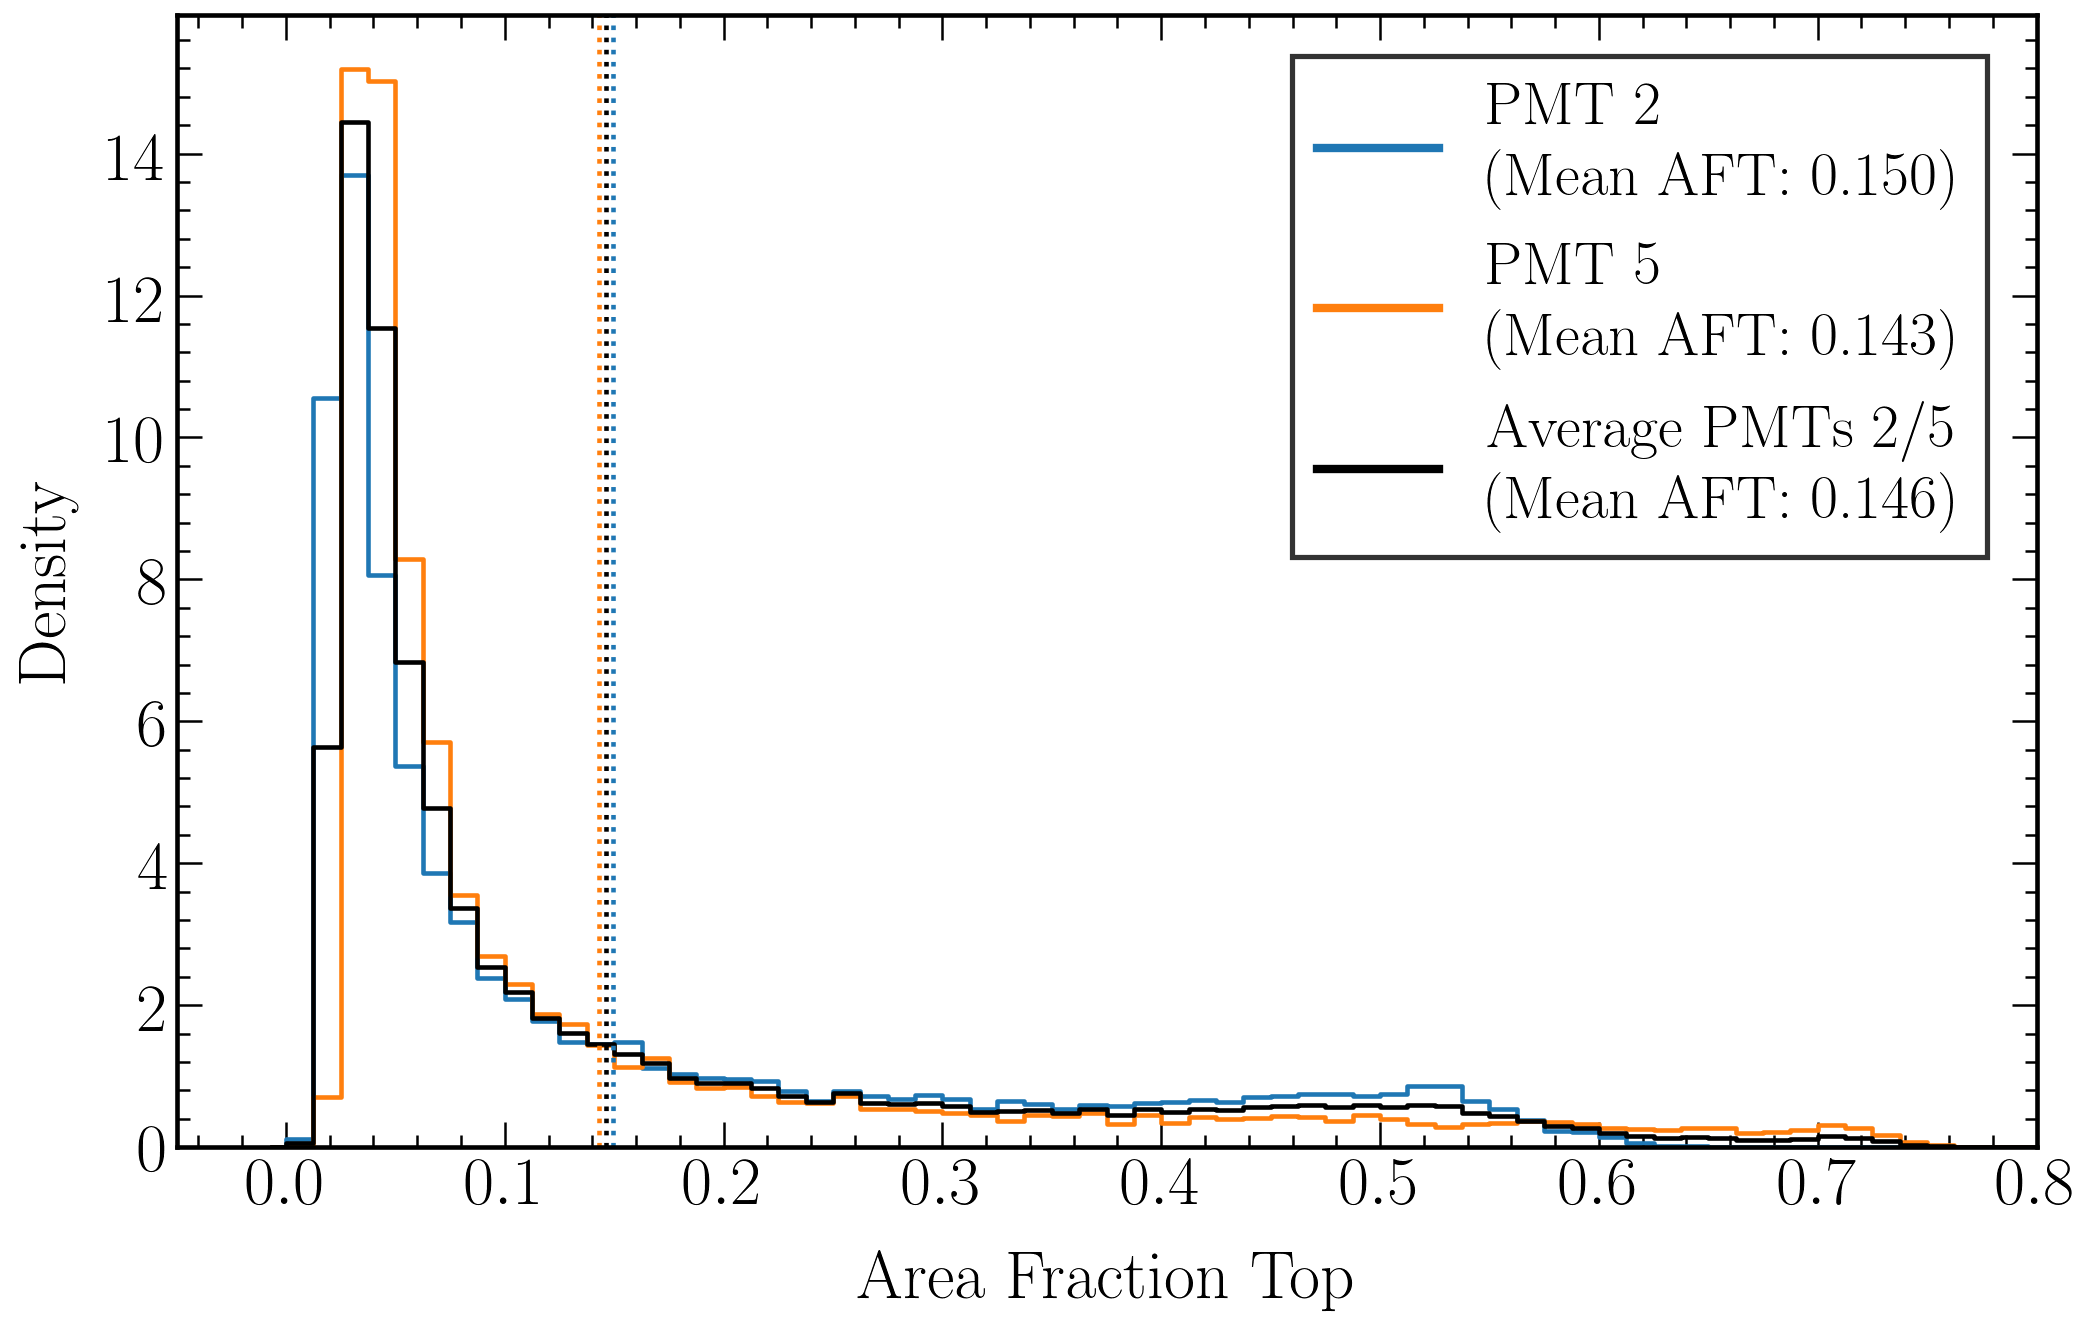

In [34]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT2']['hist_HF_bins_center'], df_meas['PMT2']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'PMT 2'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT2']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT5']['hist_HF_bins_center'], df_meas['PMT5']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'PMT 5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT5']['HF'])).mean(), 3))+")")

plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.2, color = 'k', 
         label = 'Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")

plt.axvline(x=(np.array(df_meas['PMT2']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.axvline(x=(np.array(df_meas['PMT5']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.axvline(x=PMT25_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'k')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT25_hist_scaled_fixedbinning.png")
plt.show()

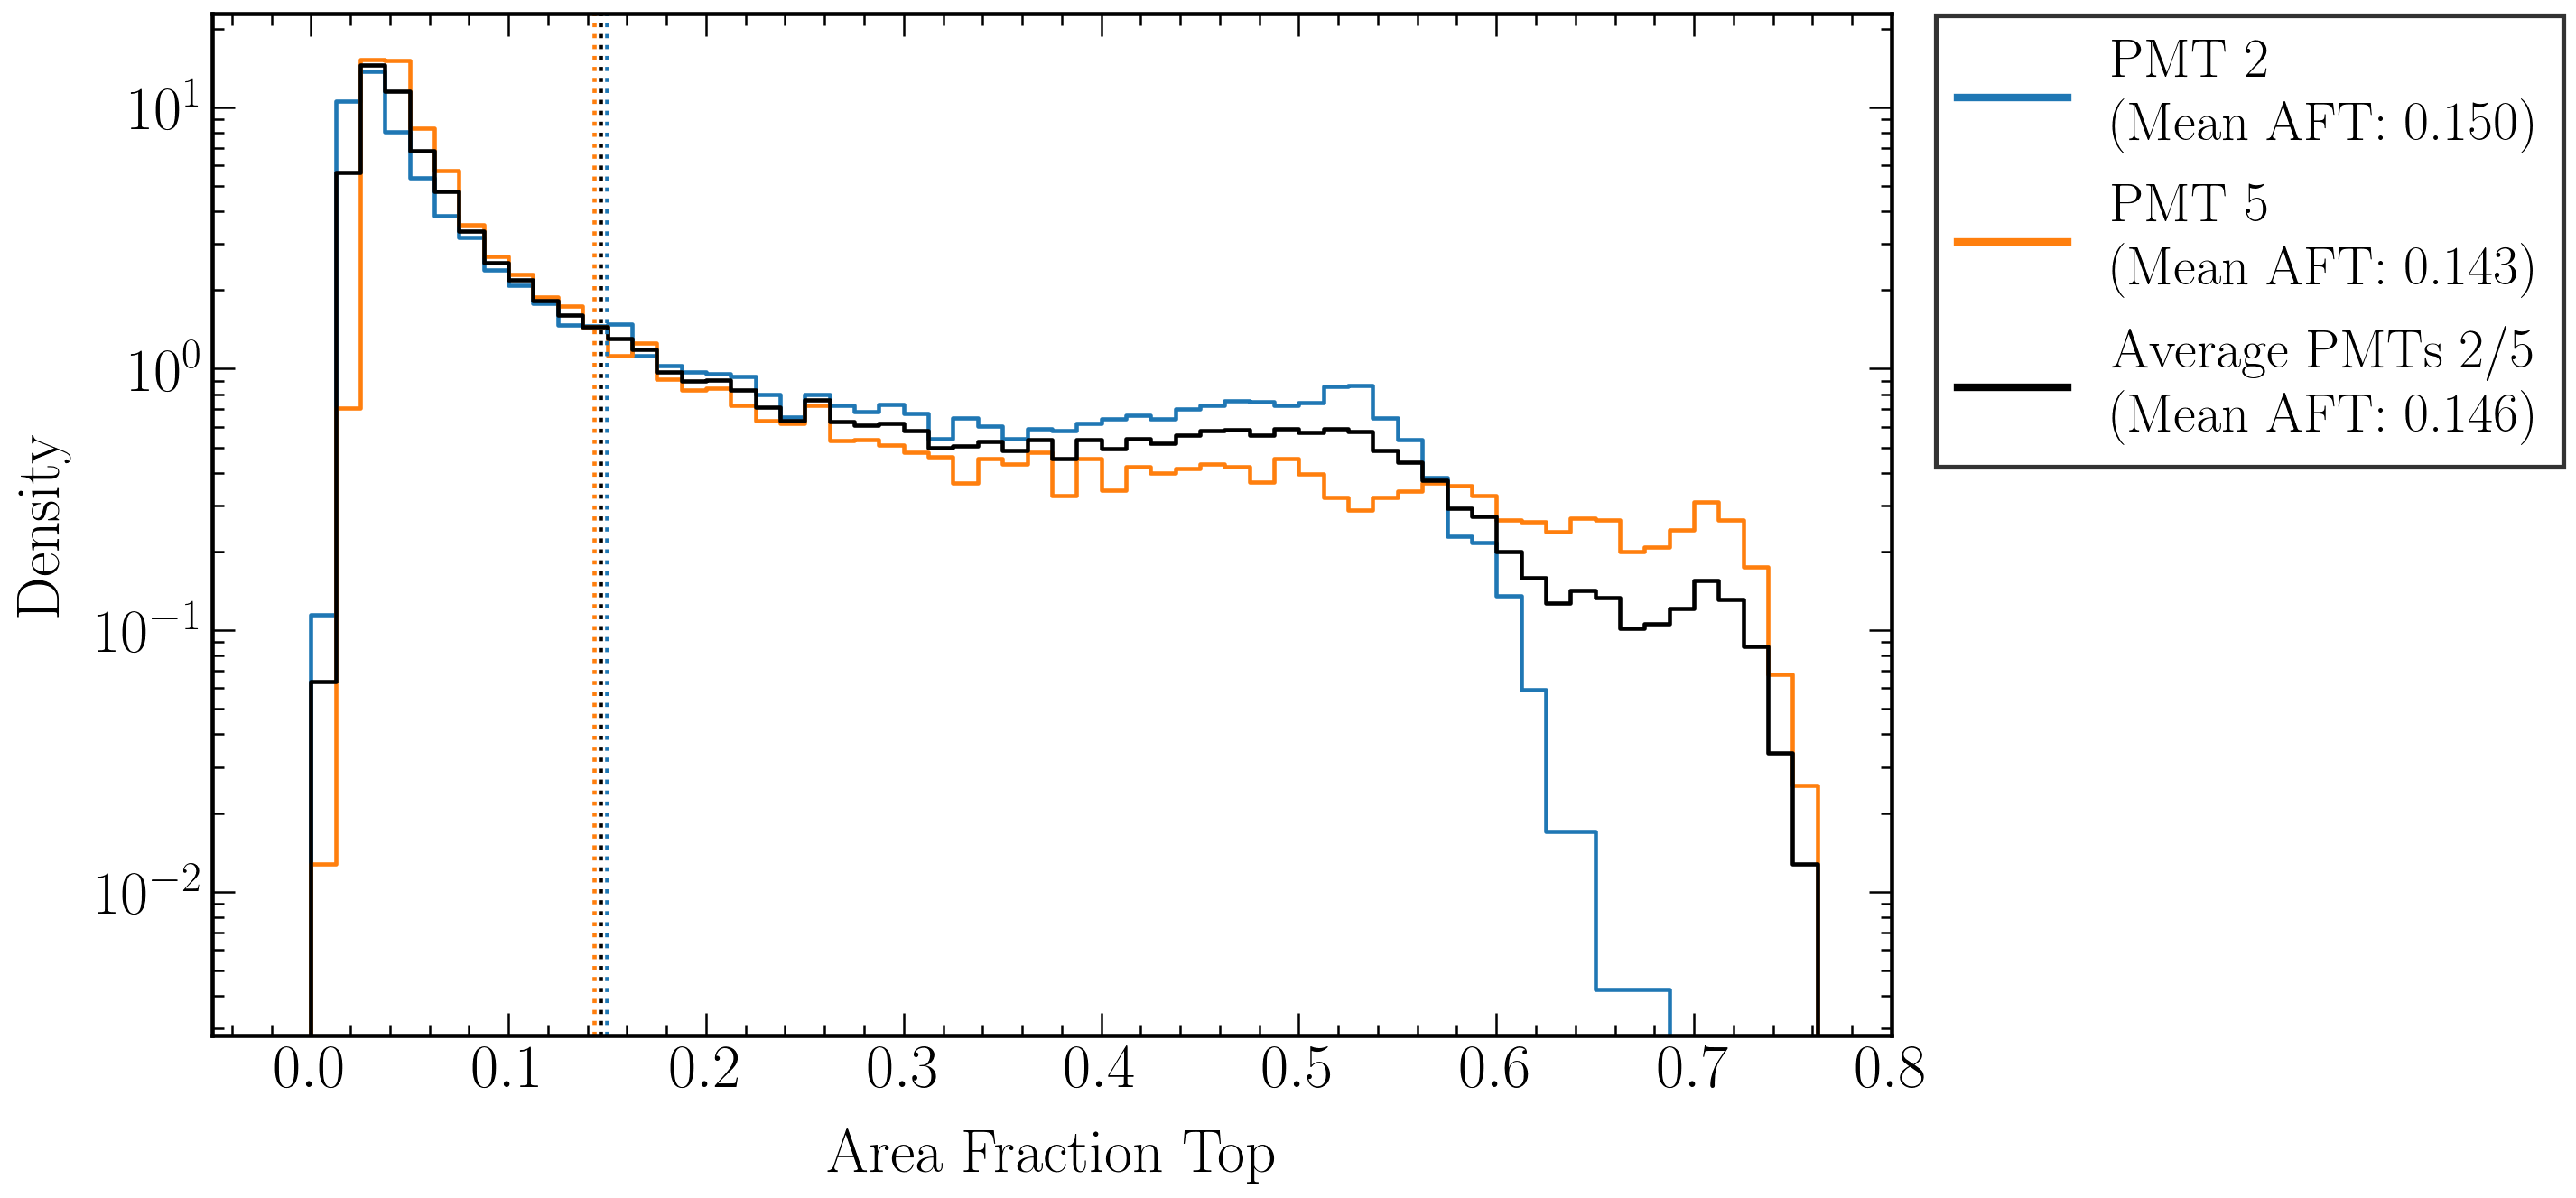

In [35]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT2']['hist_HF_bins_center'], df_meas['PMT2']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'PMT 2'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT2']['HF'])).mean(), 3))+")")
plt.step(df_meas['PMT5']['hist_HF_bins_center'], df_meas['PMT5']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'PMT 5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT5']['HF'])).mean(), 3))+")")

plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.2, color = 'k', 
         label = 'Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")

plt.axvline(x=(np.array(df_meas['PMT2']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.axvline(x=(np.array(df_meas['PMT5']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.axvline(x=PMT25_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'k')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT25_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()

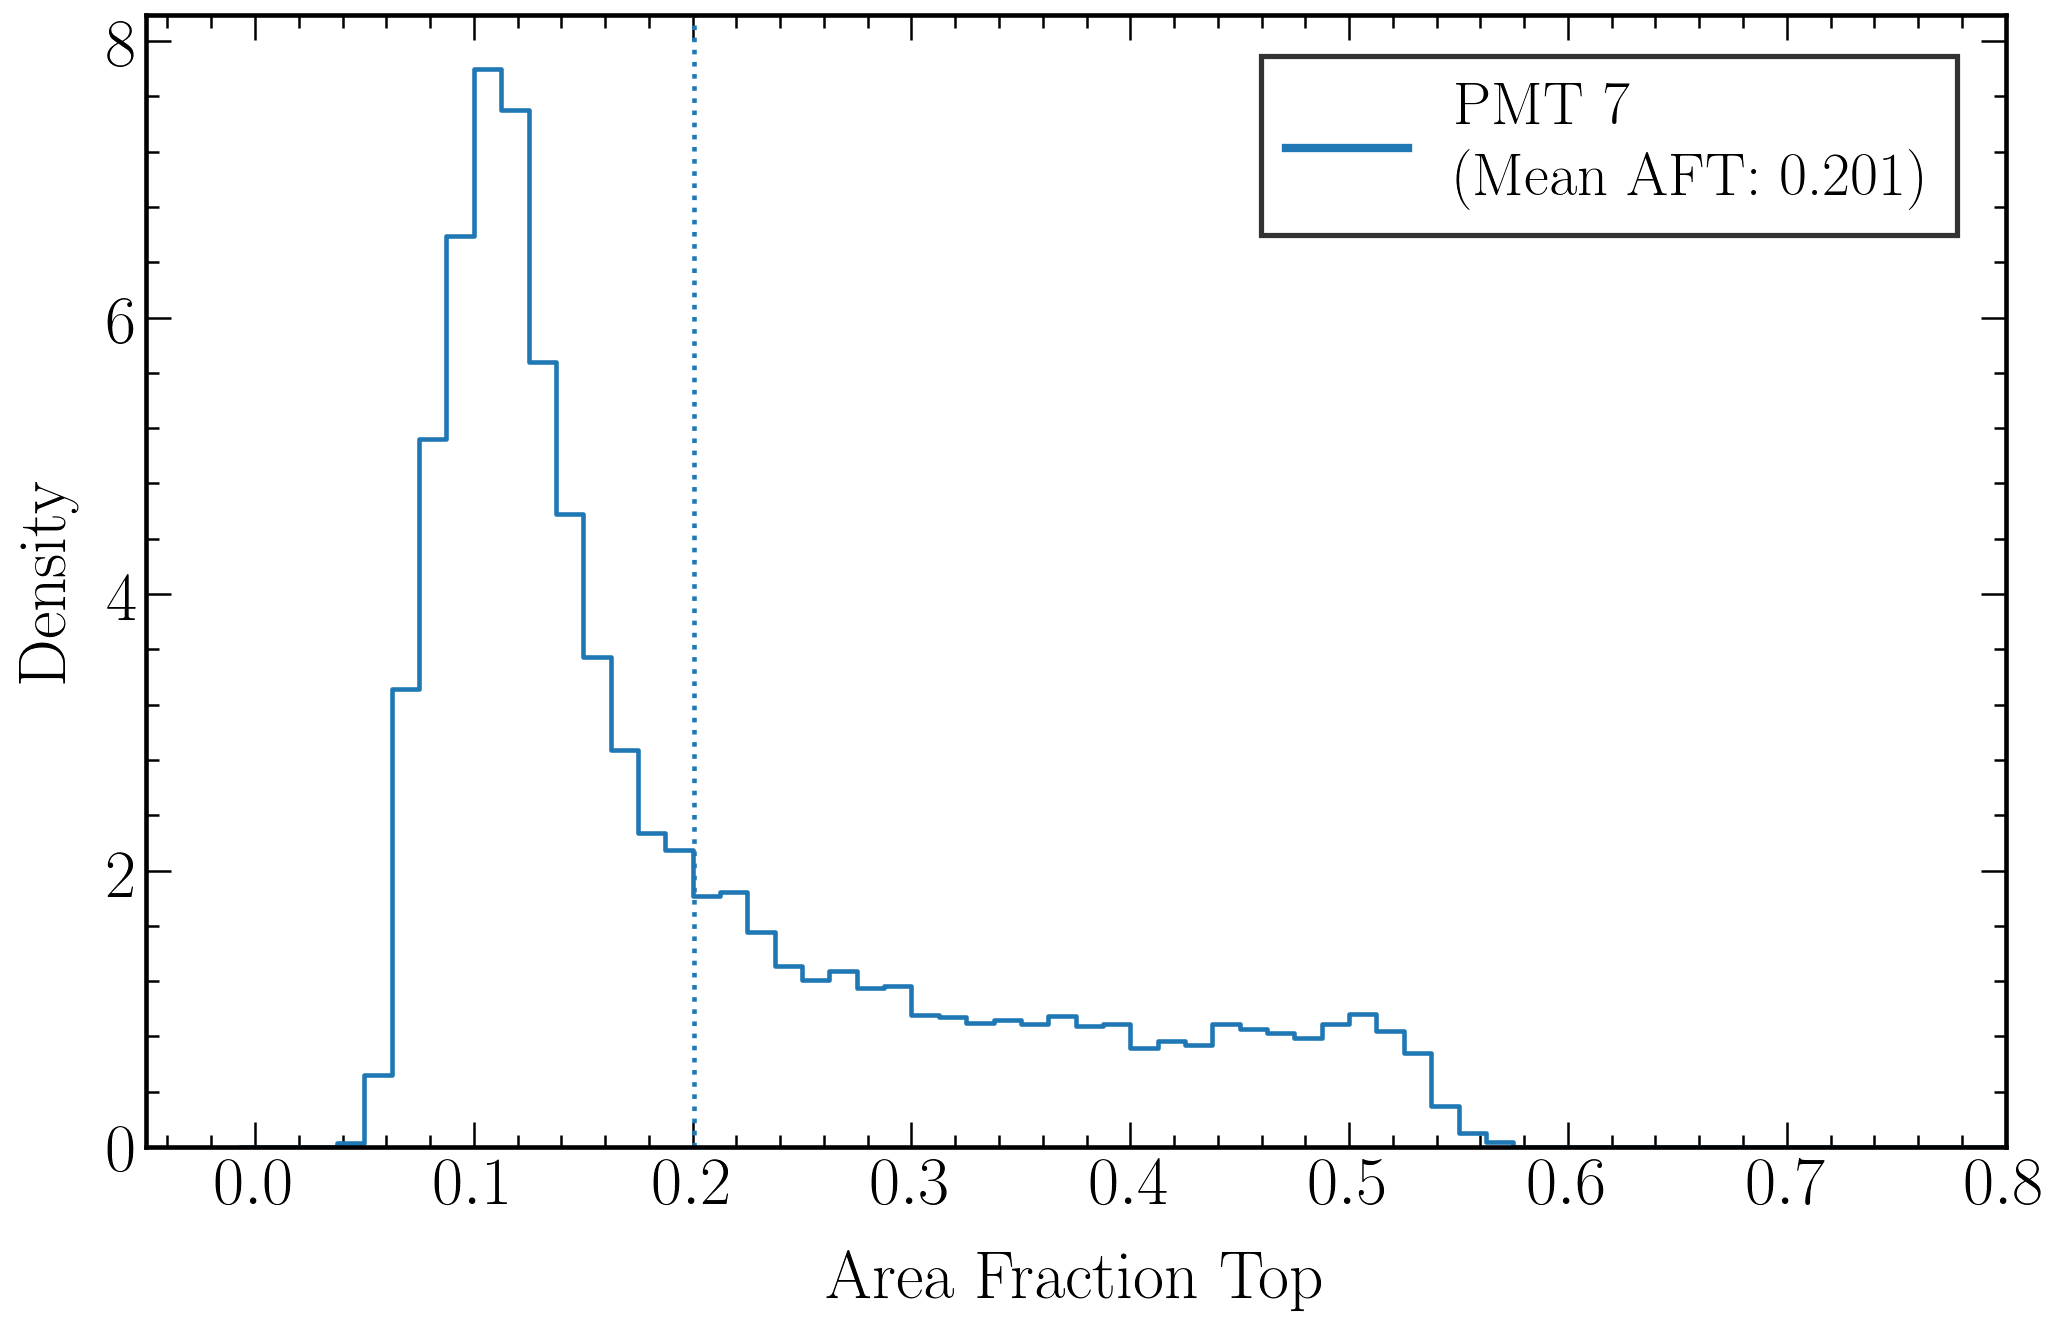

In [36]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")

plt.axvline(x=(np.array(df_meas['PMT7']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT7only_hist_scaled_fixedbinning.png")
plt.show()

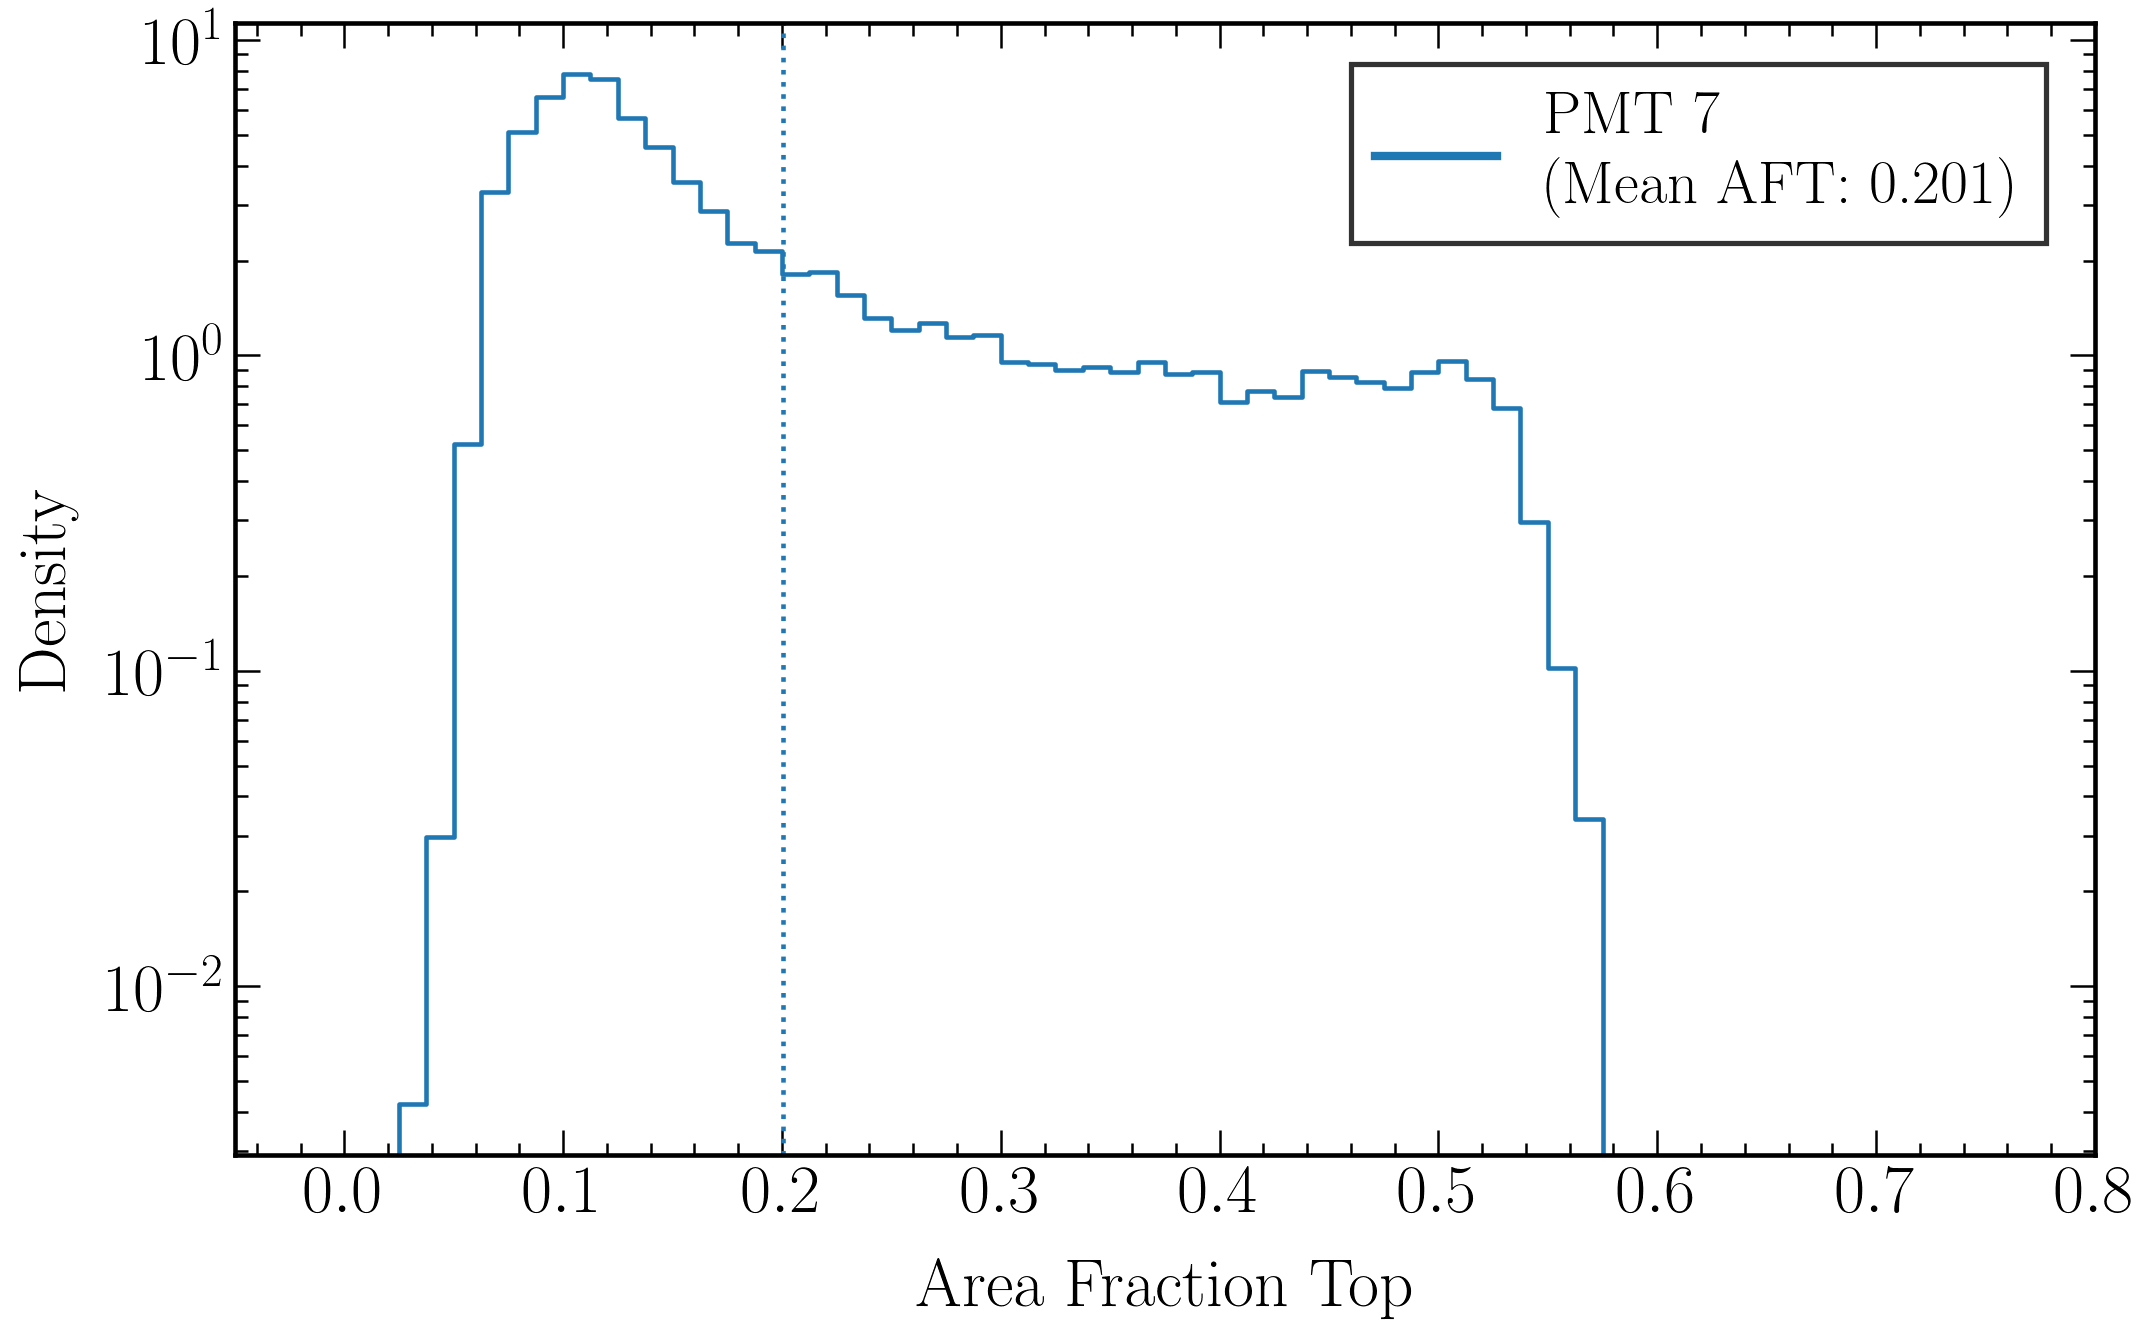

In [37]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")

plt.axvline(x=(np.array(df_meas['PMT7']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT7only_hist_scaled_fixedbinning_log.png")
plt.show()

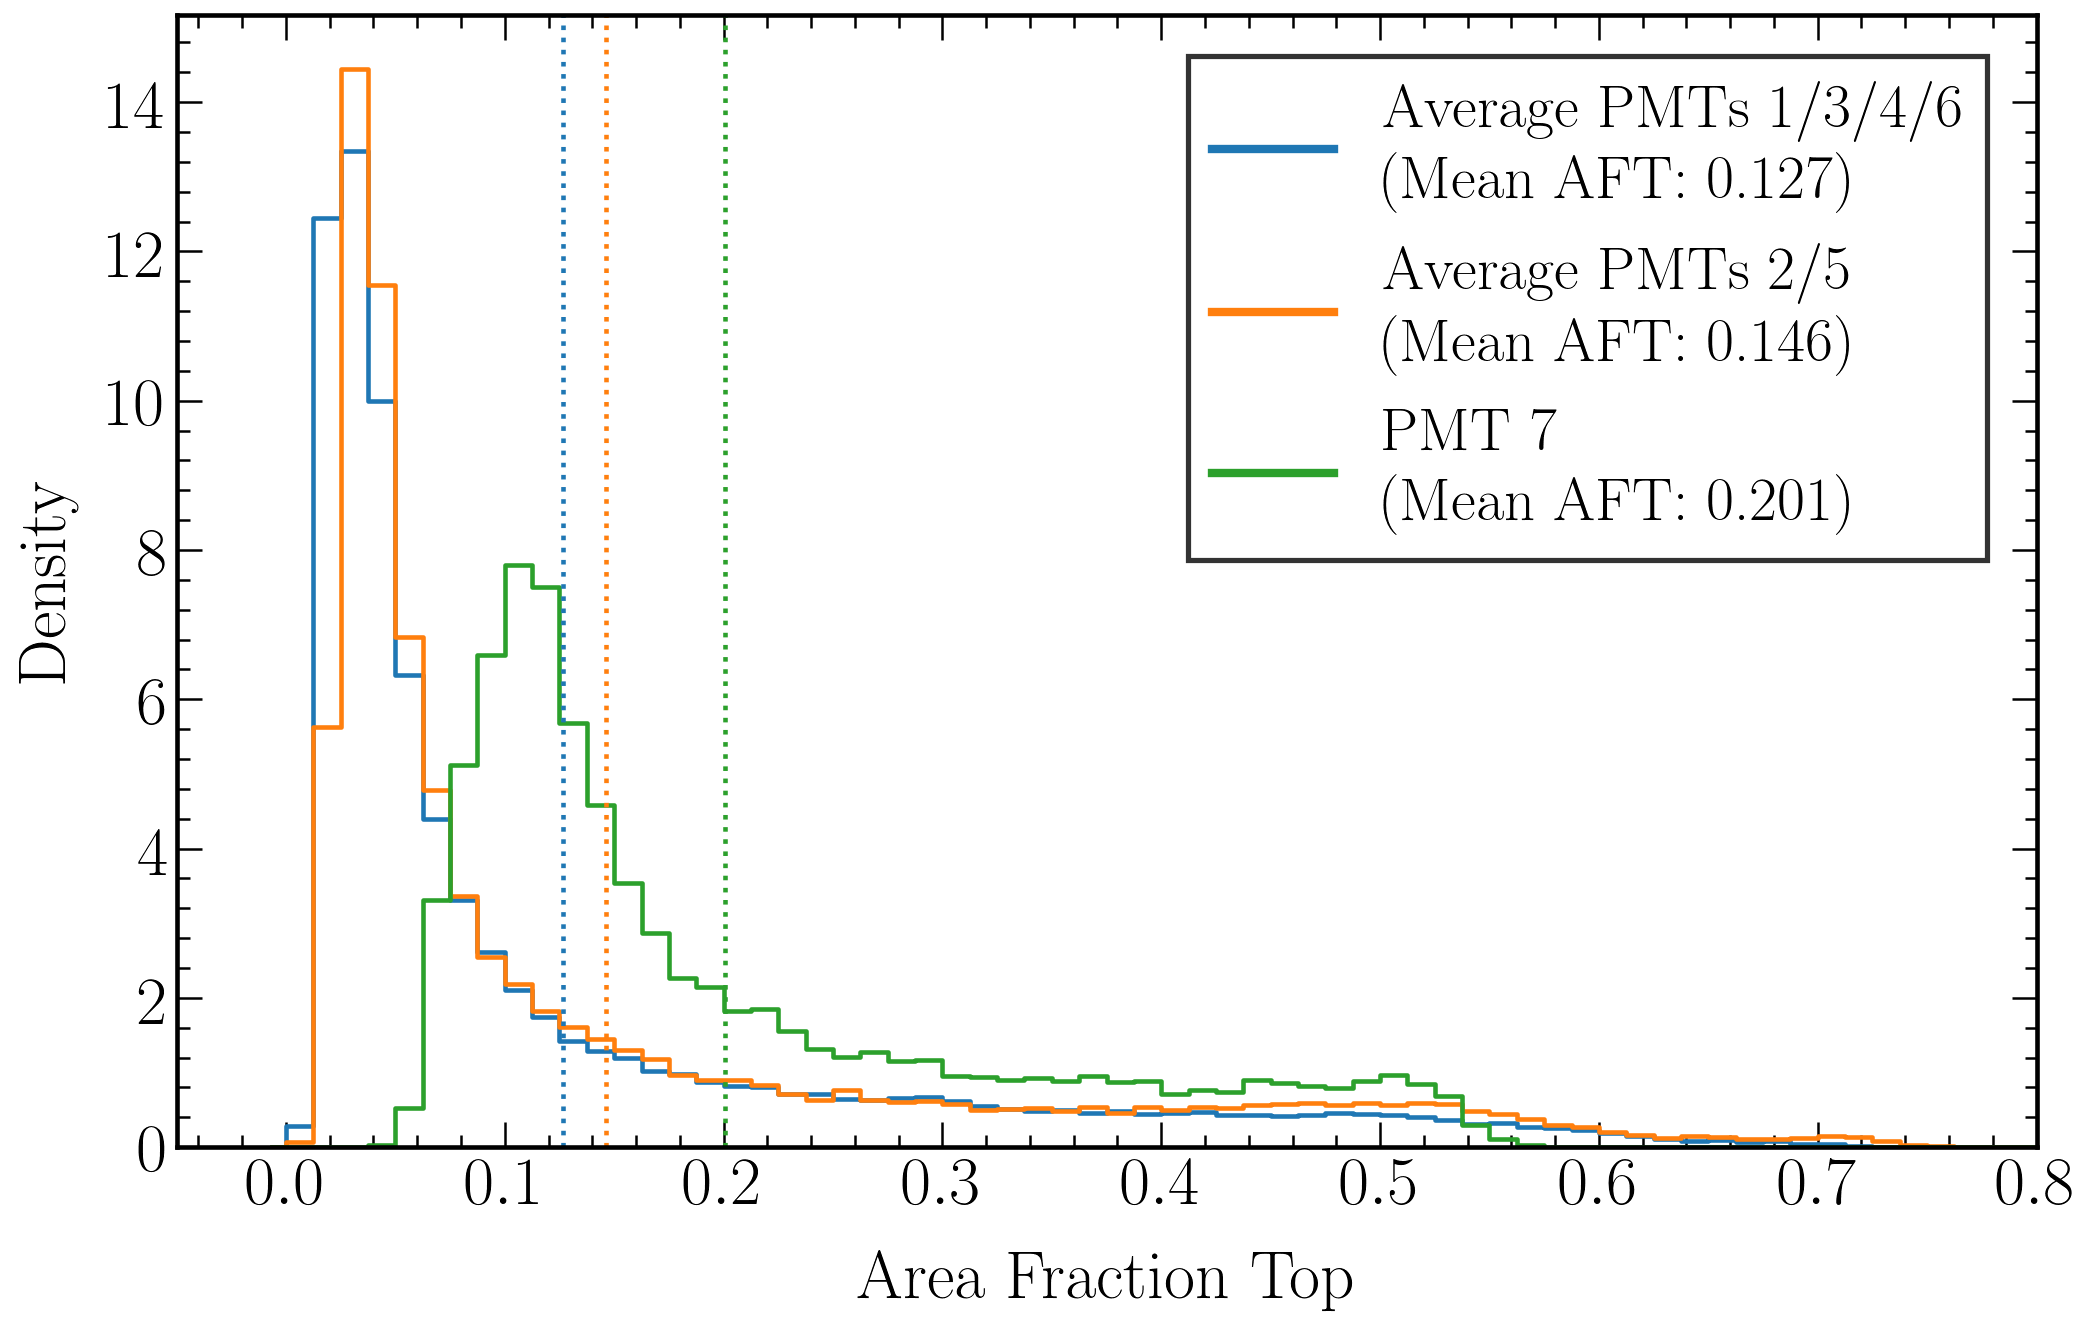

In [38]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C2', 
         label = 'PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")

plt.axvline(x=PMT1346_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.axvline(x=PMT25_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.axvline(x=(np.array(df_meas['PMT7']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT1av2av7_hist_scaled_fixedbinning.png")
plt.show()

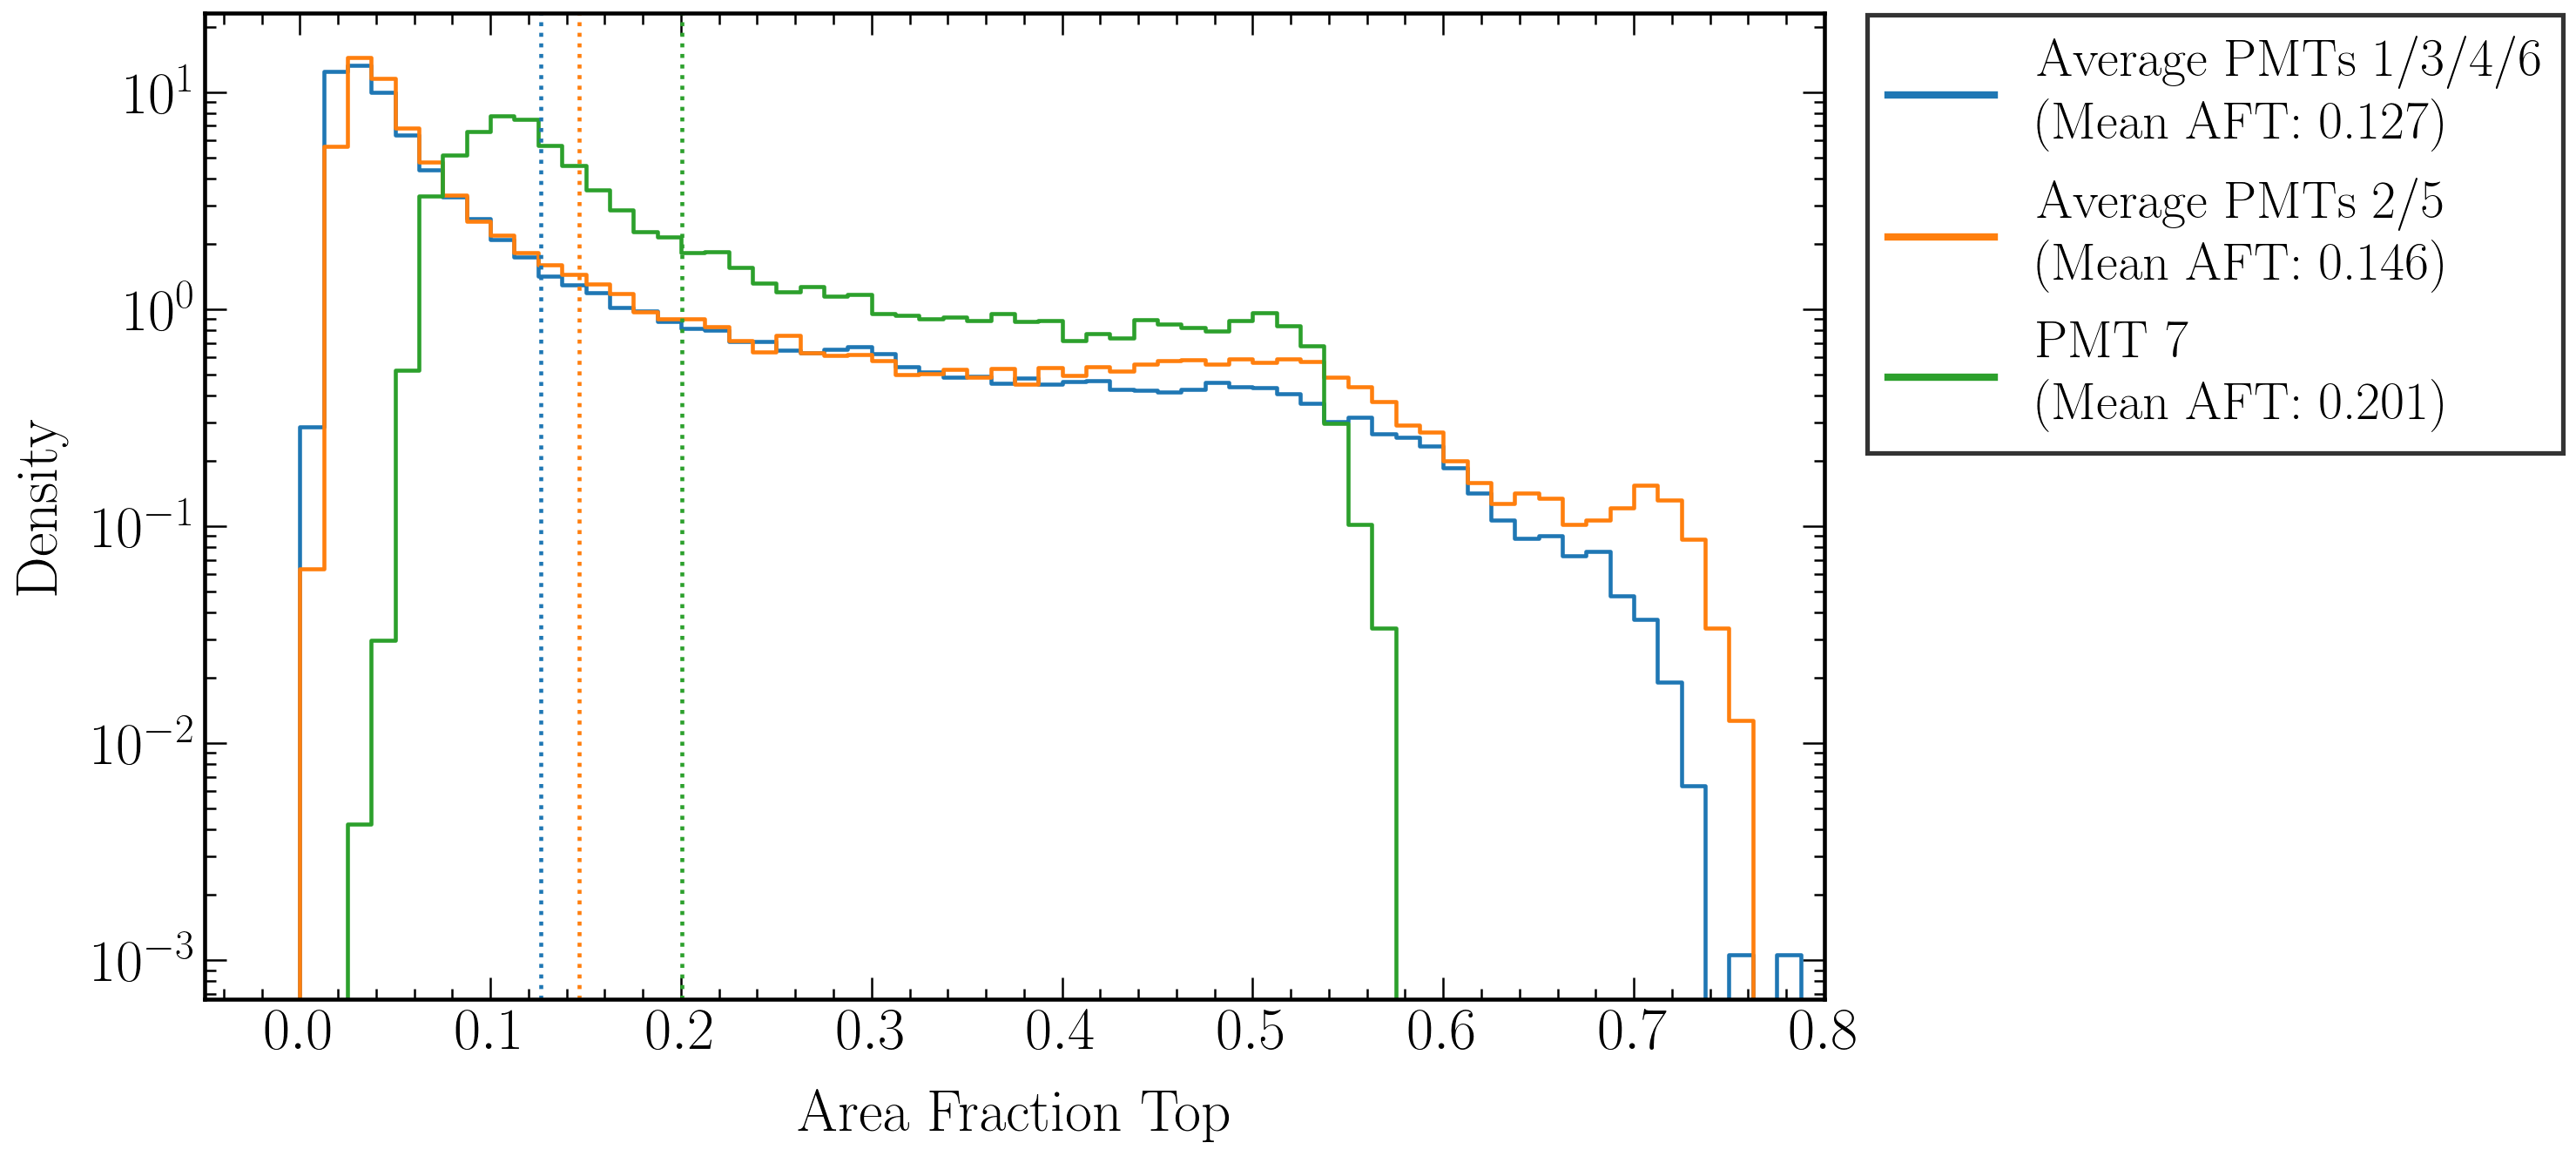

In [39]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C2', 
         label = 'PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")

plt.axvline(x=PMT1346_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.axvline(x=PMT25_HF_hist_mean, linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.axvline(x=(np.array(df_meas['PMT7']['HF'])).mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix_meas+"_AFT_PMT1av2av7_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()

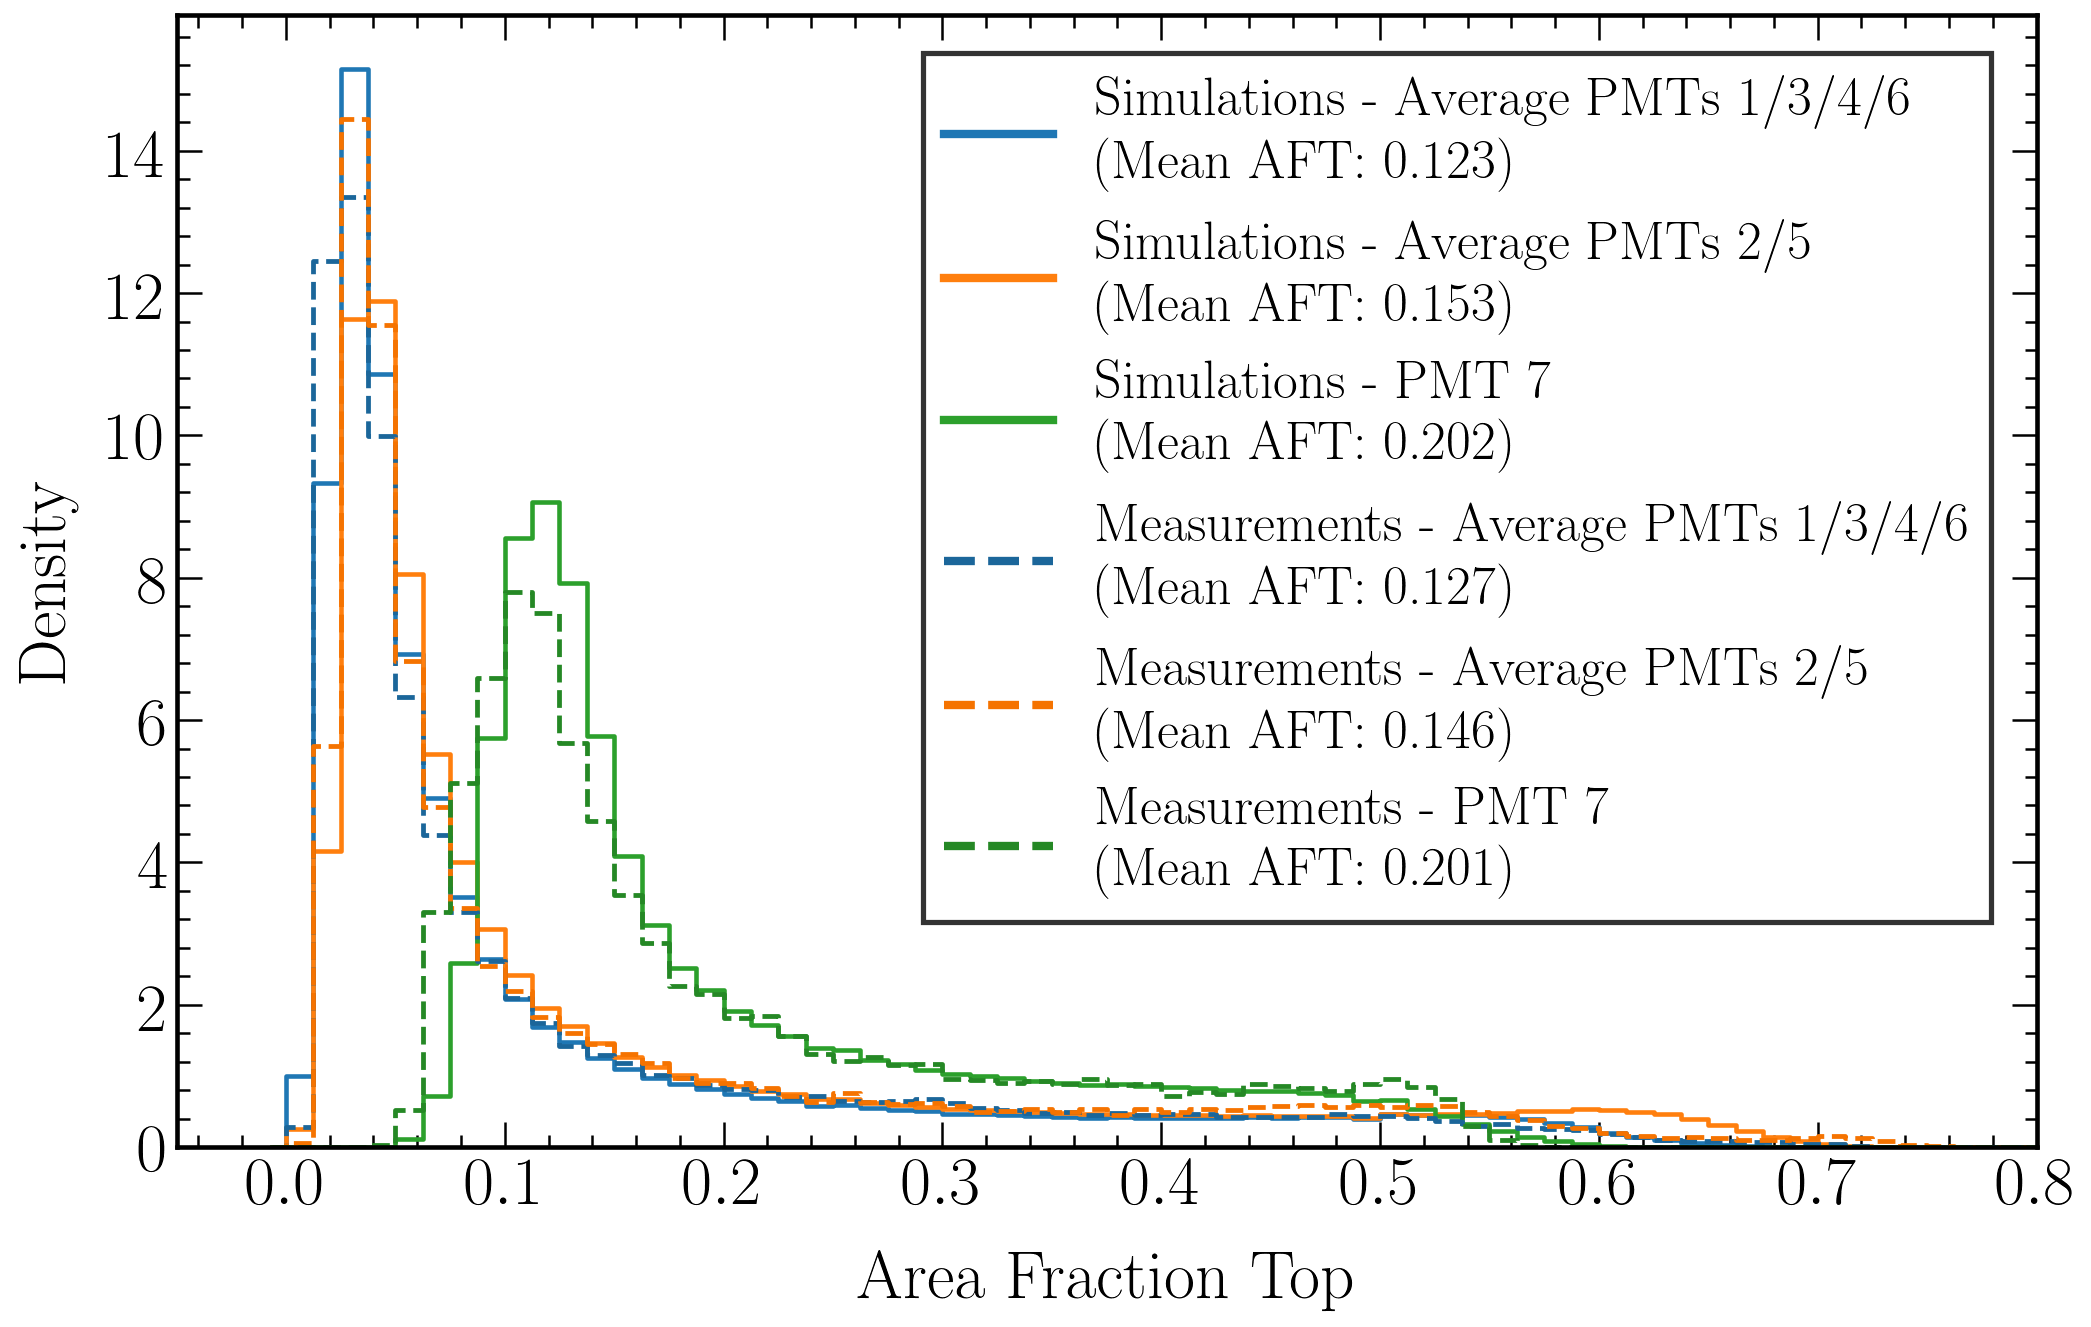

In [40]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT1']['hist_HF_bins_center'], df['PMT1']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'Simulations - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(1)]/_chunk_collect['ntpmthits']).mean(), 3))+")")
plt.step(df['PMT2']['hist_HF_bins_center'], df['PMT2']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'Simulations - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(2)]/_chunk_collect['ntpmthits']).mean(), 3))+")")
plt.step(df['PMT7']['hist_HF_bins_center'], df['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C2', 
         label = 'Simulations - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(7)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.3, color=lighten_color('C0', 1.1), linestyle = 'dashed',
         label = 'Measurements - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.3, color=lighten_color('C1', 1.1), linestyle = 'dashed', 
         label = 'Measurements - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.3, color=lighten_color('C2', 1.1), linestyle = 'dashed', 
         label = 'Measurements - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.8*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT1av2av7_hist_scaled_fixedbinning.png")
plt.show()

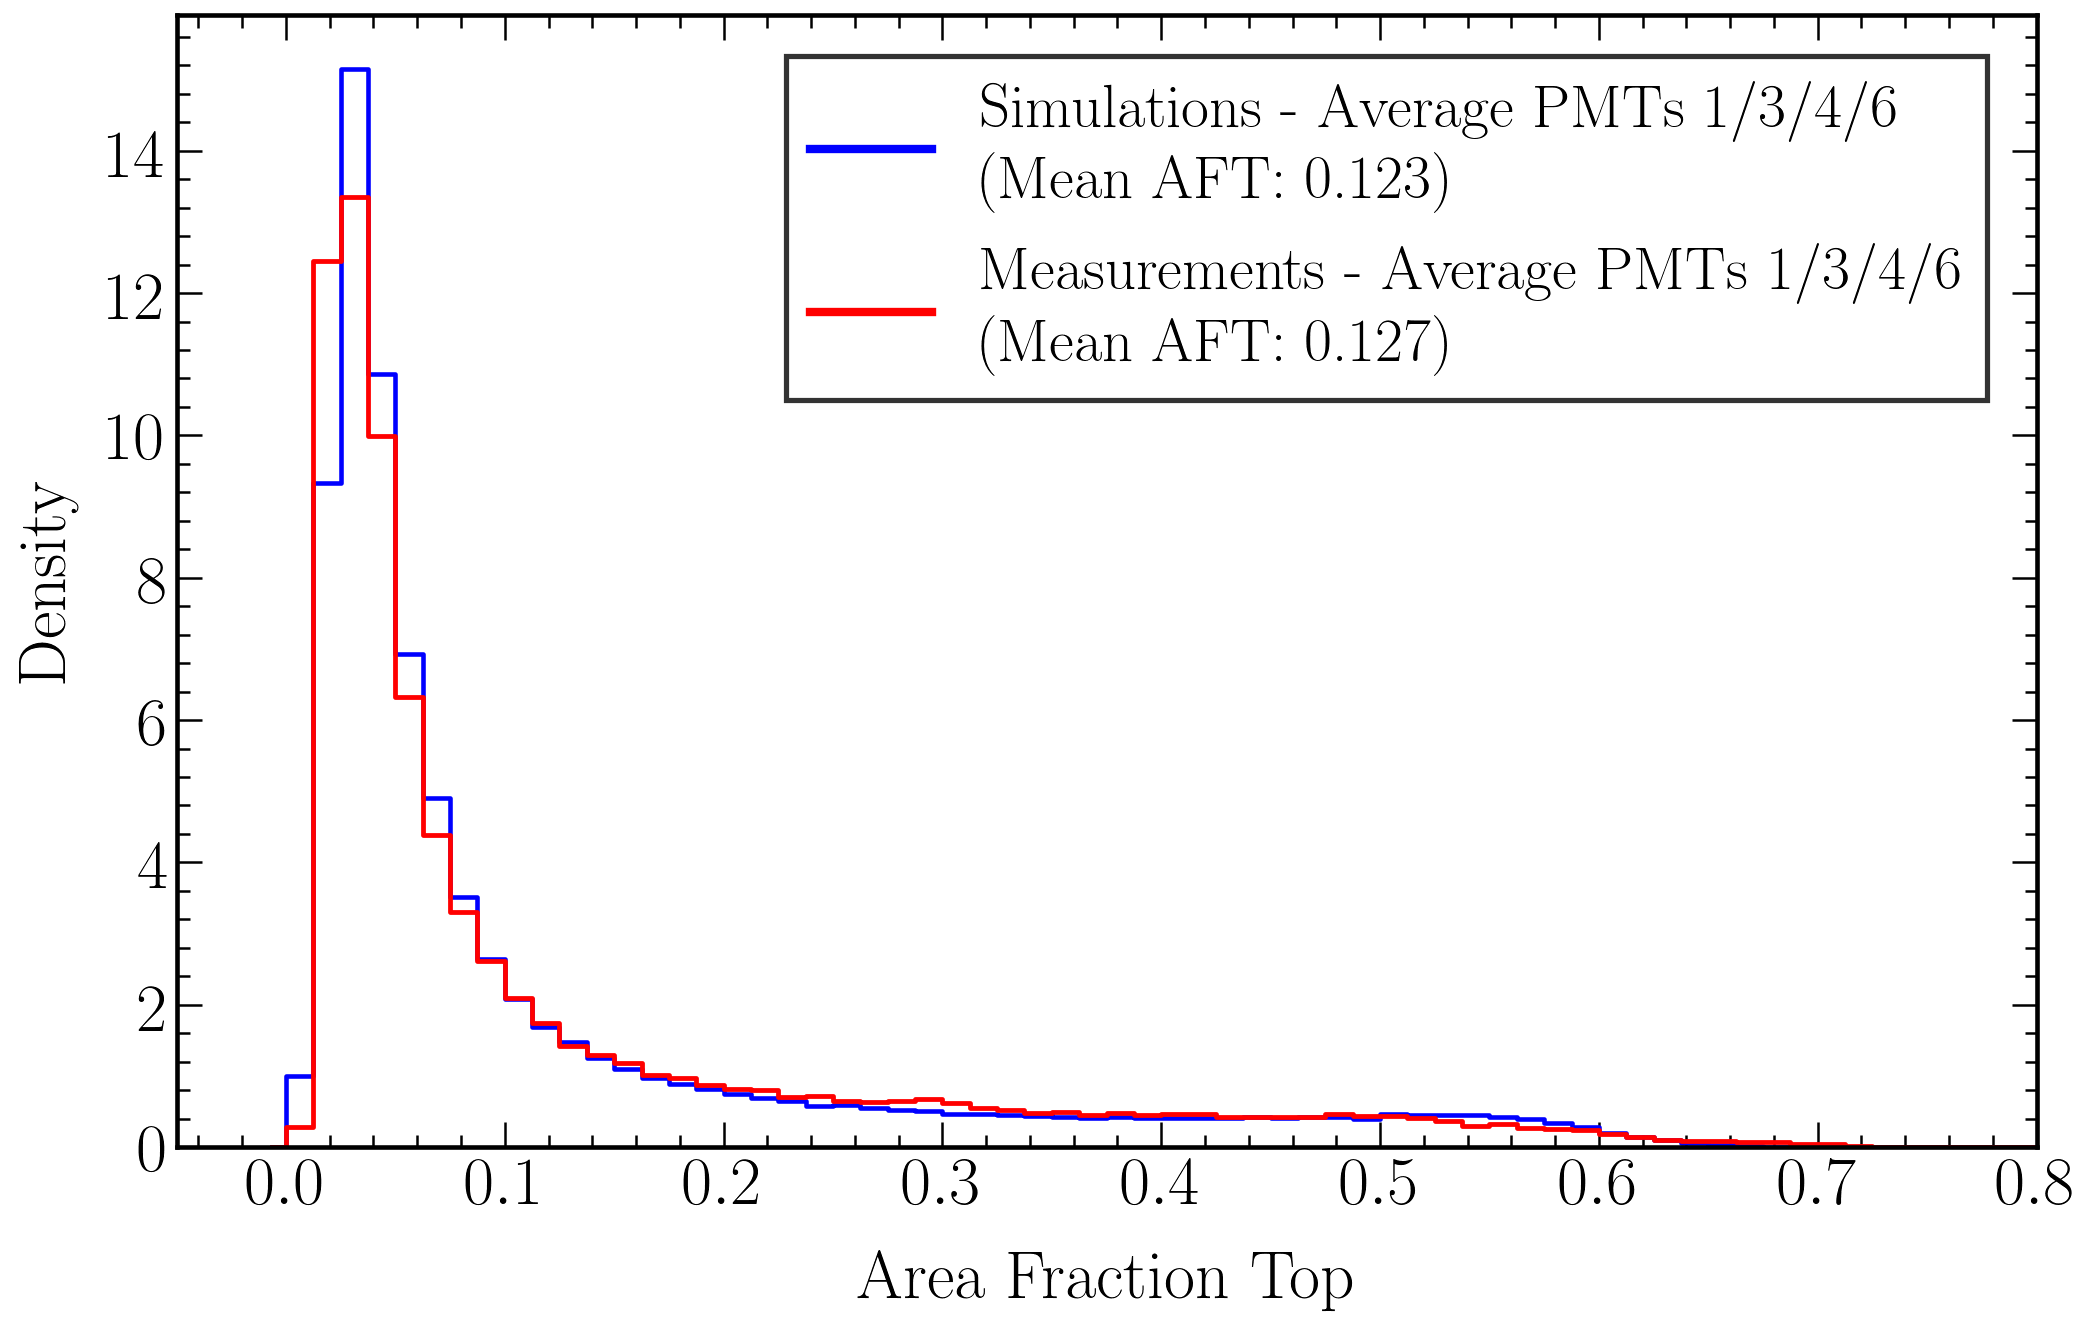

In [41]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT1']['hist_HF_bins_center'], df['PMT1']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'blue', 
         label = 'Simulations - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(1)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.3, color='red',
         label = 'Measurements - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT1av_hist_scaled_fixedbinning.png")
plt.show()

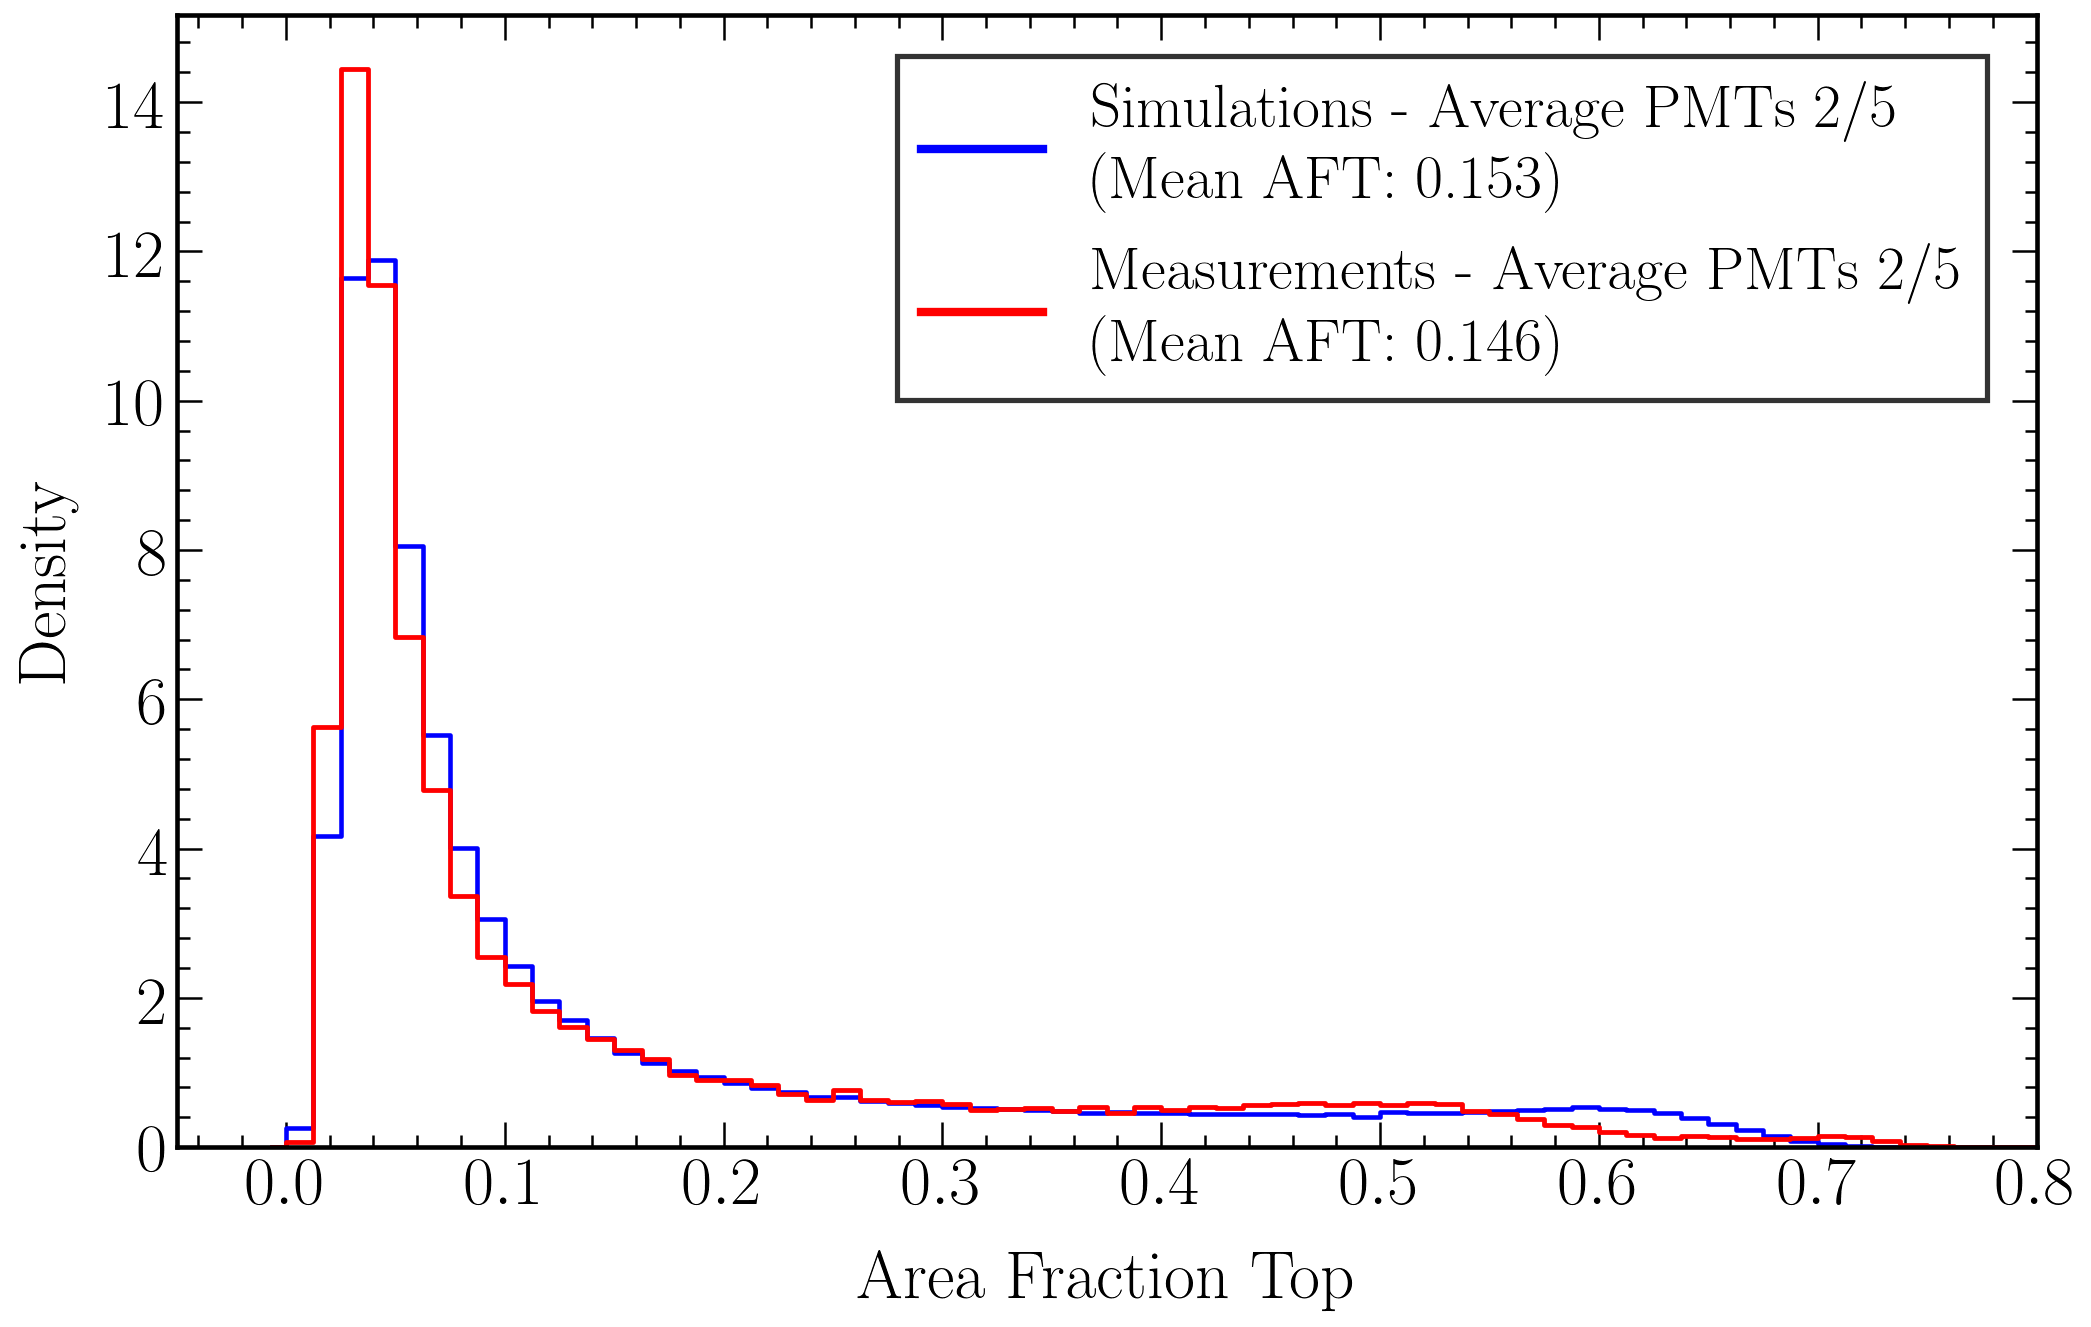

In [42]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT2']['hist_HF_bins_center'], df['PMT2']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'blue', 
         label = 'Simulations - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(2)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.3, color='red',
         label = 'Measurements - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT2av_hist_scaled_fixedbinning.png")
plt.show()

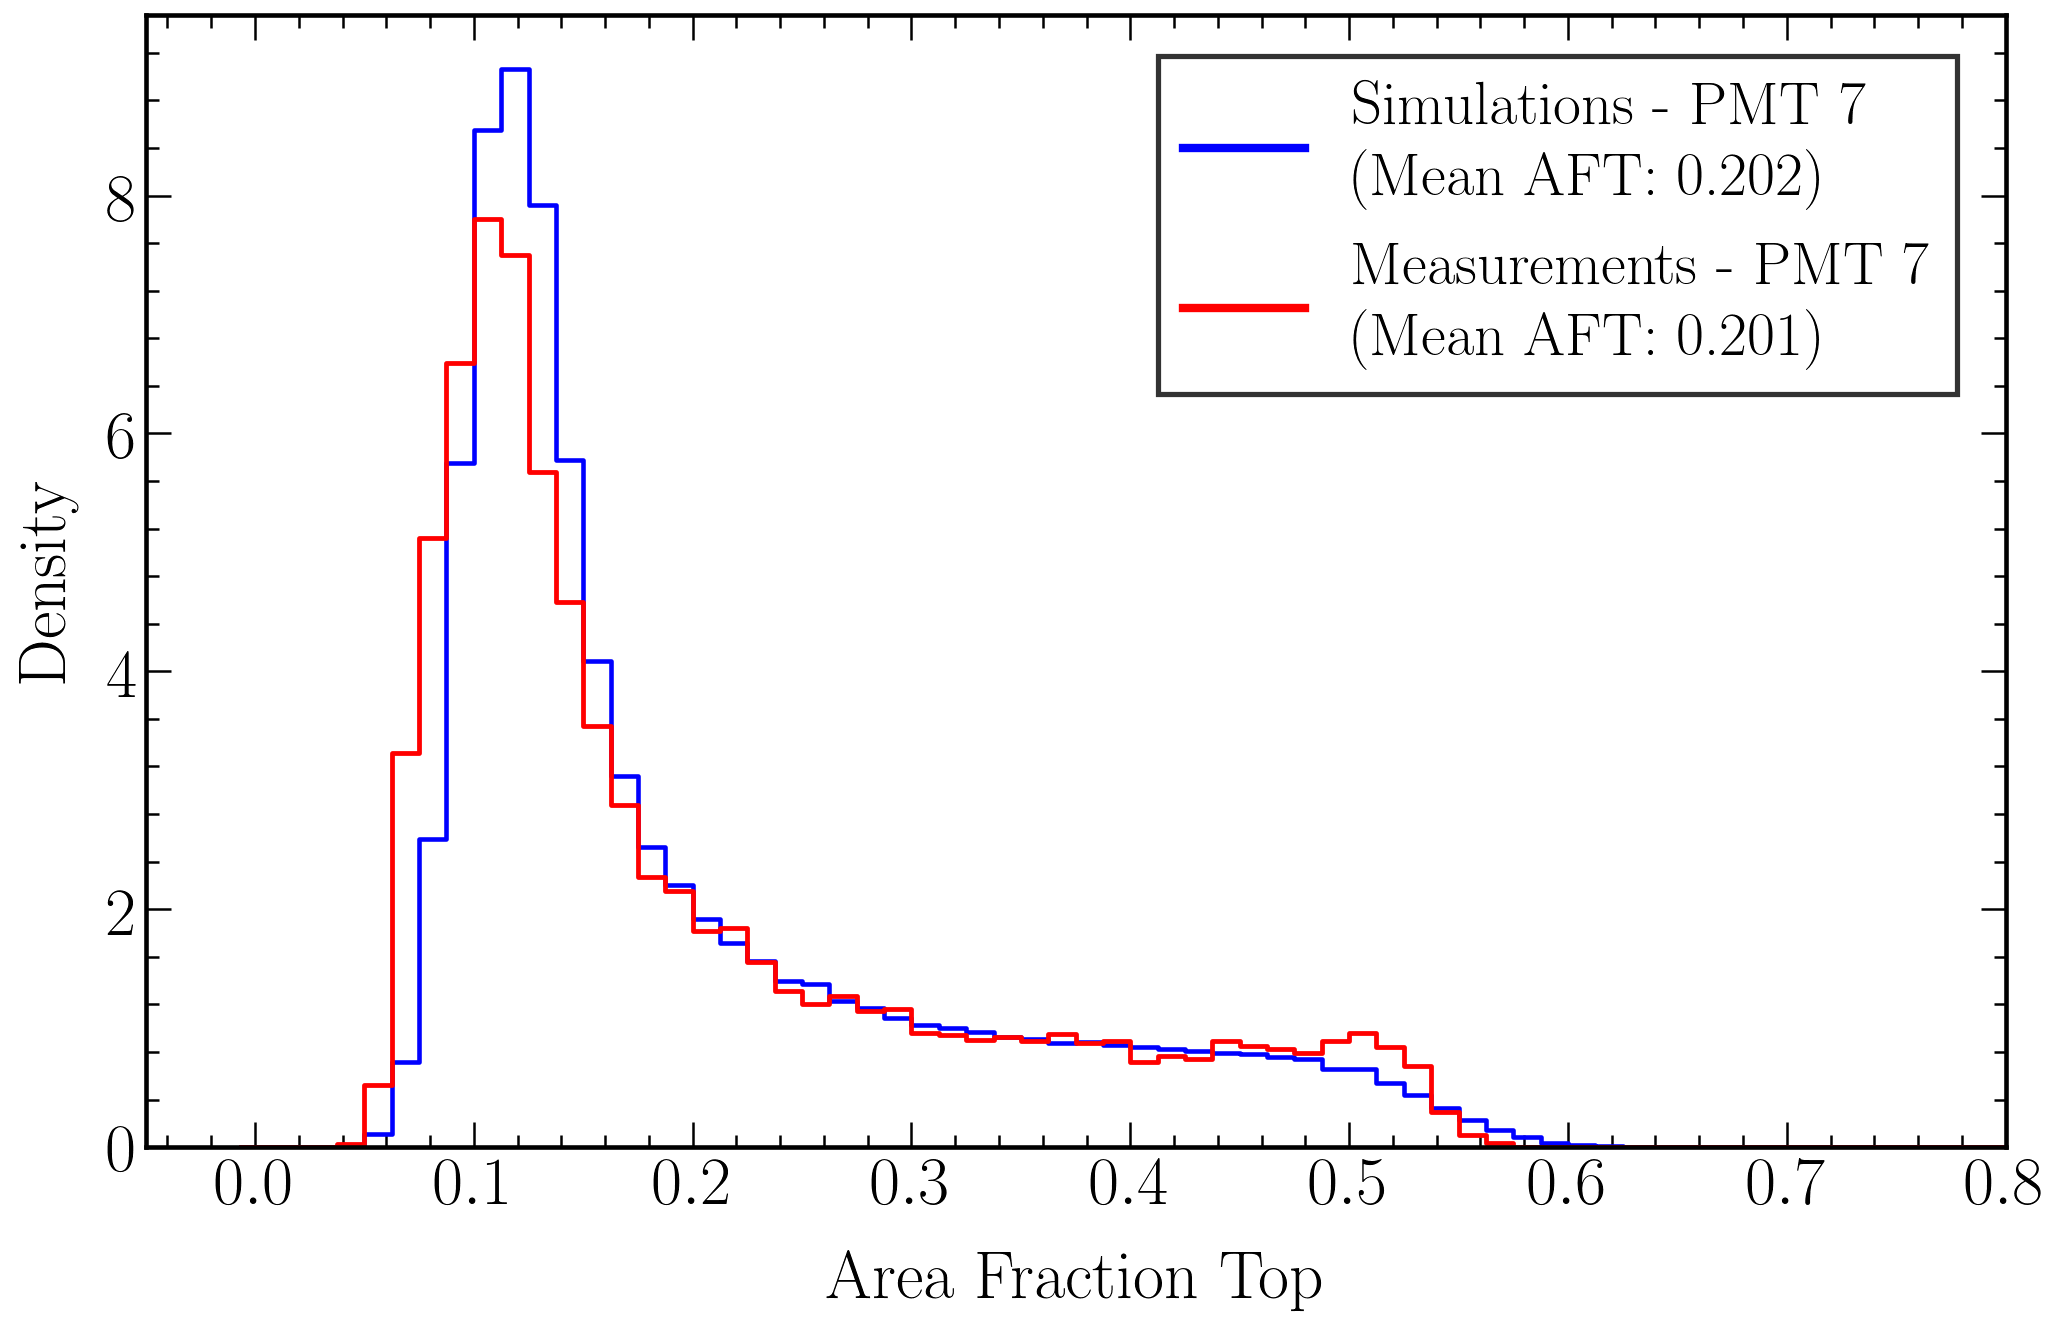

In [43]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT7']['hist_HF_bins_center'], df['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'blue', 
         label = 'Simulations - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(7)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.3, color='red',
         label = 'Measurements - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.ylim(bottom=0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT7_hist_scaled_fixedbinning.png")
plt.show()

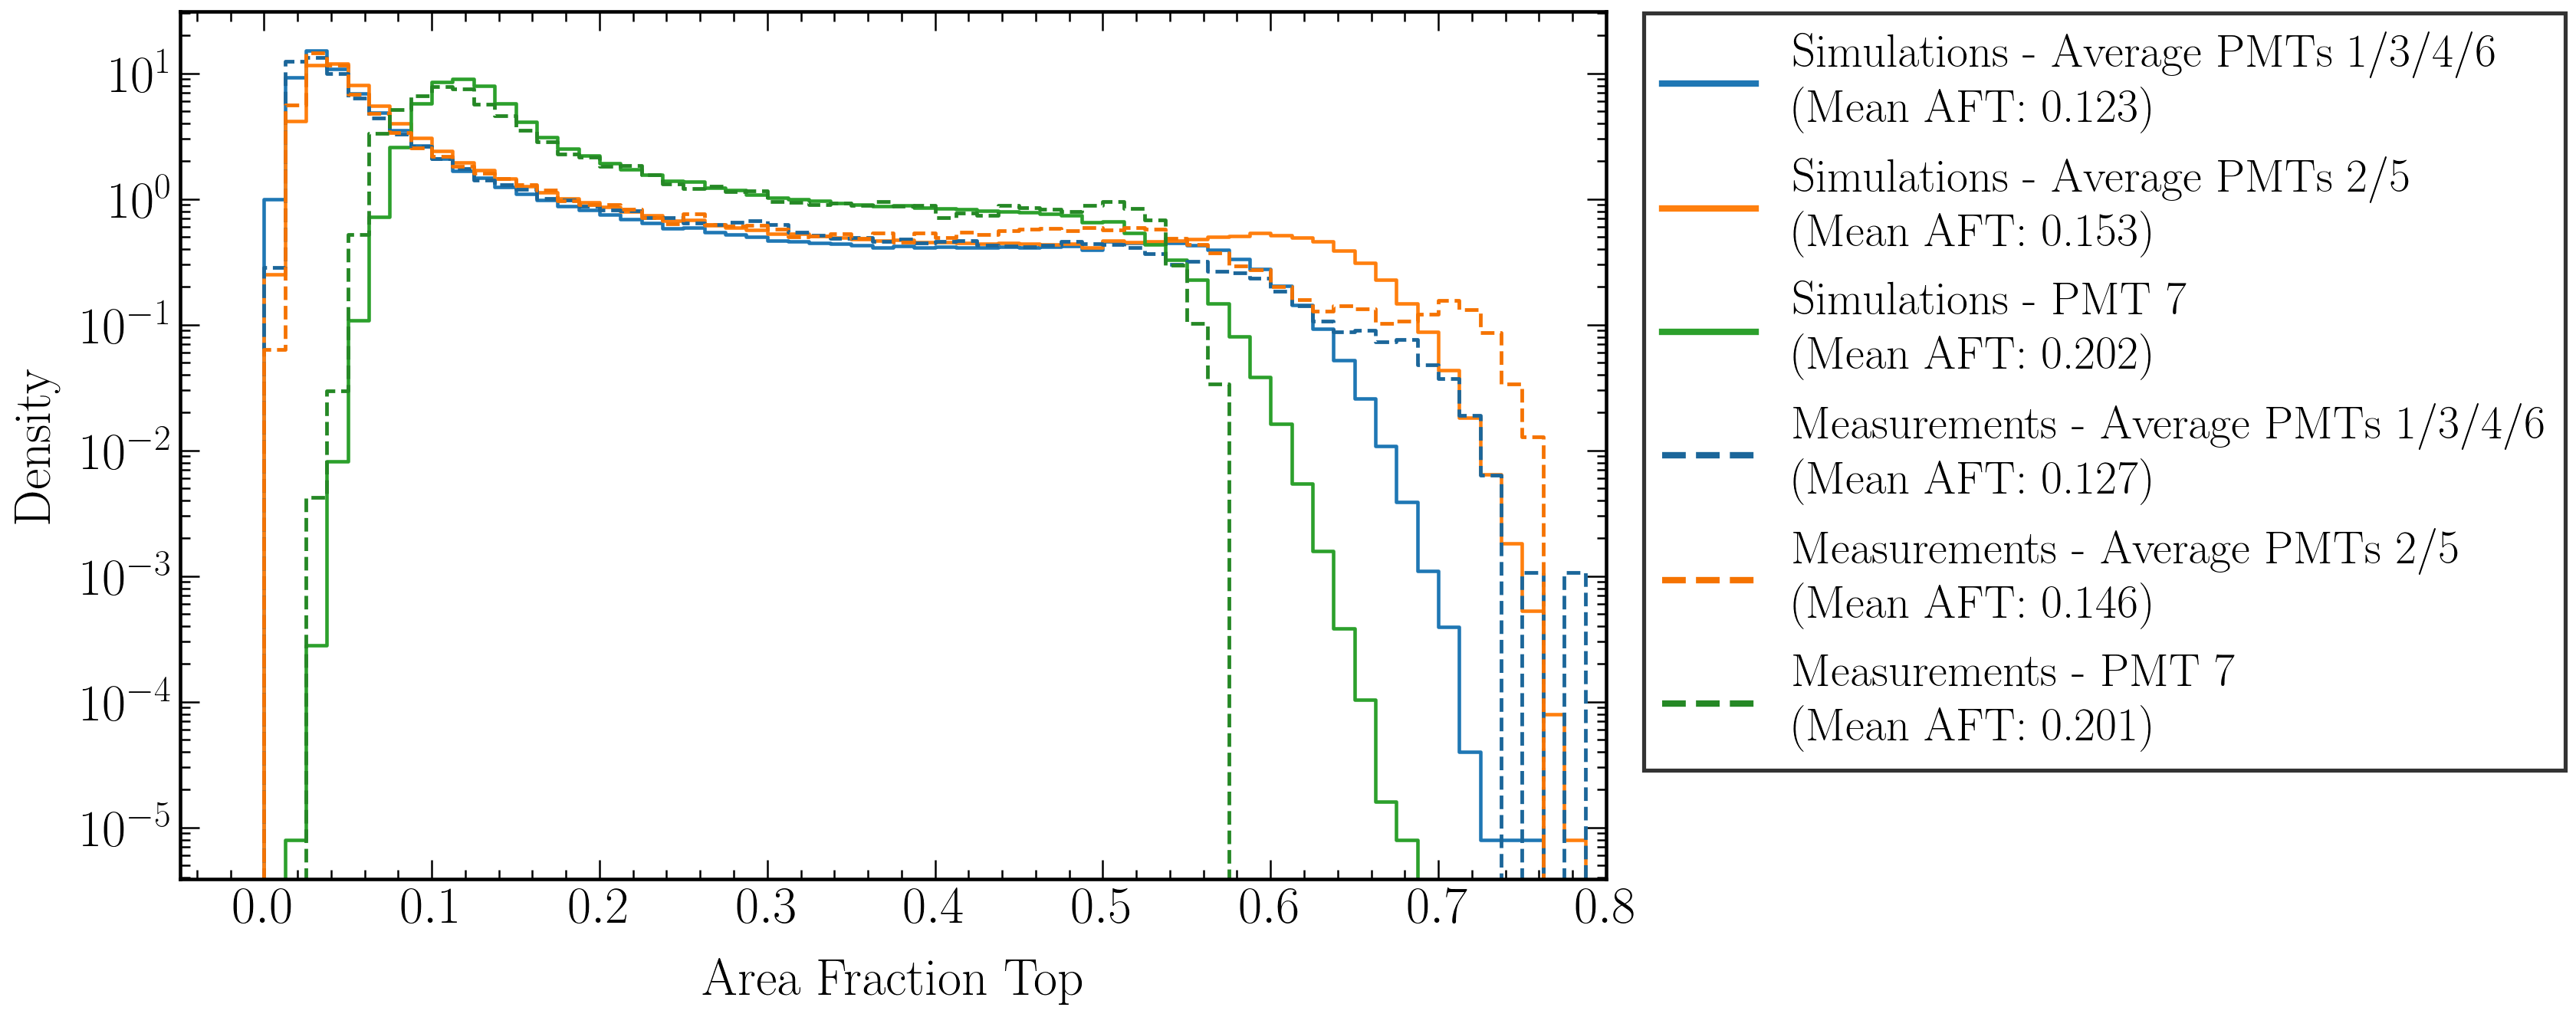

In [44]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT1']['hist_HF_bins_center'], df['PMT1']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C0', 
         label = 'Simulations - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(1)]/_chunk_collect['ntpmthits']).mean(), 3))+")")
plt.step(df['PMT2']['hist_HF_bins_center'], df['PMT2']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C1', 
         label = 'Simulations - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(2)]/_chunk_collect['ntpmthits']).mean(), 3))+")")
plt.step(df['PMT7']['hist_HF_bins_center'], df['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'C2', 
         label = 'Simulations - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(7)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.3, color=lighten_color('C0', 1.1), linestyle = 'dashed',
         label = 'Measurements - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.3, color=lighten_color('C1', 1.1), linestyle = 'dashed', 
         label = 'Measurements - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")
plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.3, color=lighten_color('C2', 1.1), linestyle = 'dashed', 
         label = 'Measurements - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT1av2av7_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()

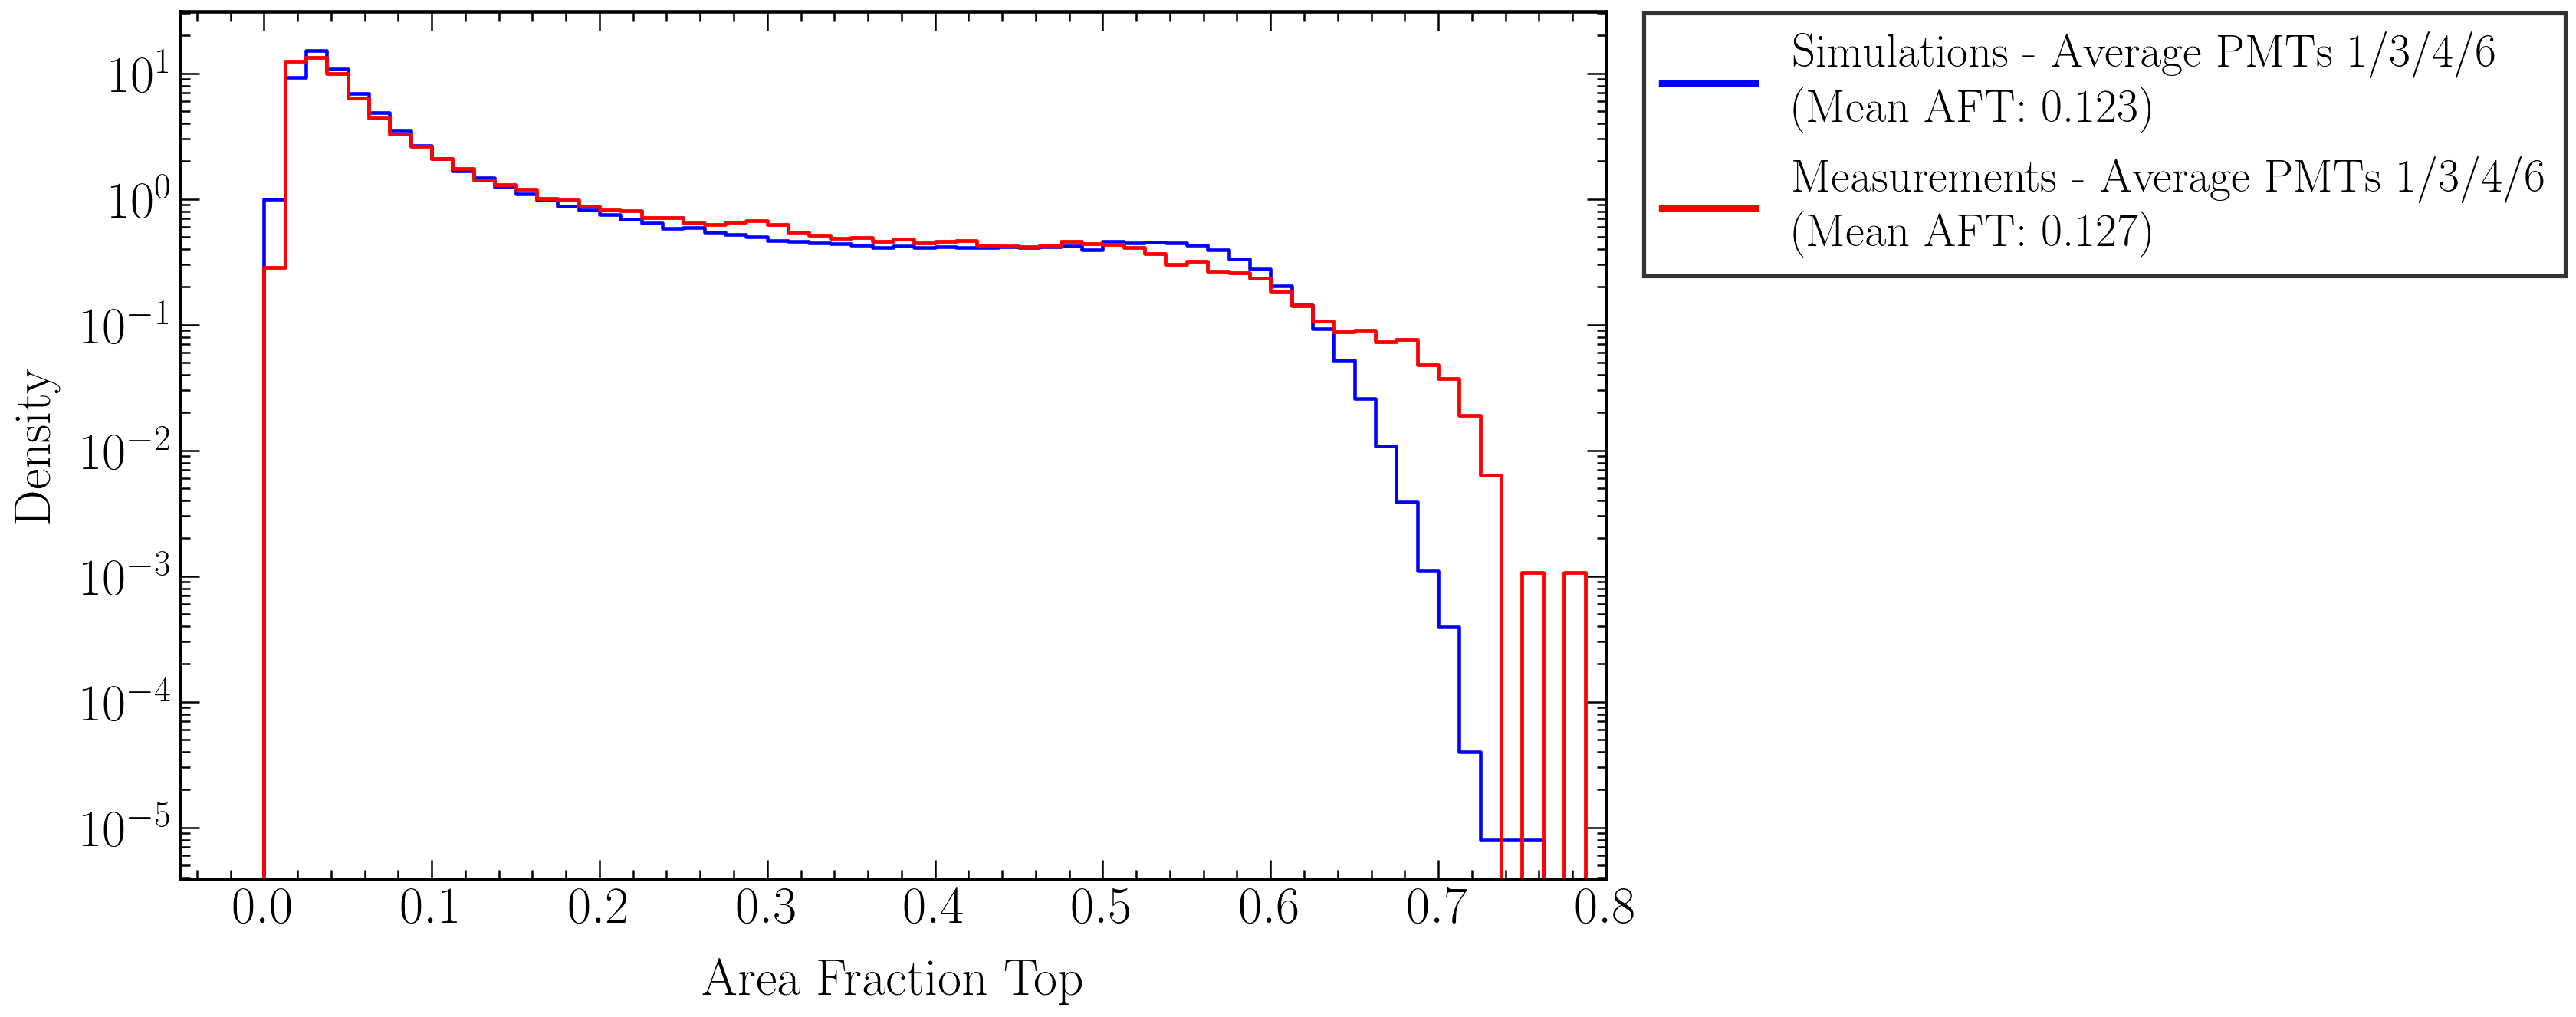

In [45]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT1']['hist_HF_bins_center'], df['PMT1']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'blue', 
         label = 'Simulations - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(1)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT1']['hist_HF_bins_center'], PMT1346_HF_hist, where='mid', 
         linewidth = 2.3, color='red',
         label = 'Measurements - Average PMTs 1/3/4/6'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT1346_HF_hist_mean, 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT1av_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()

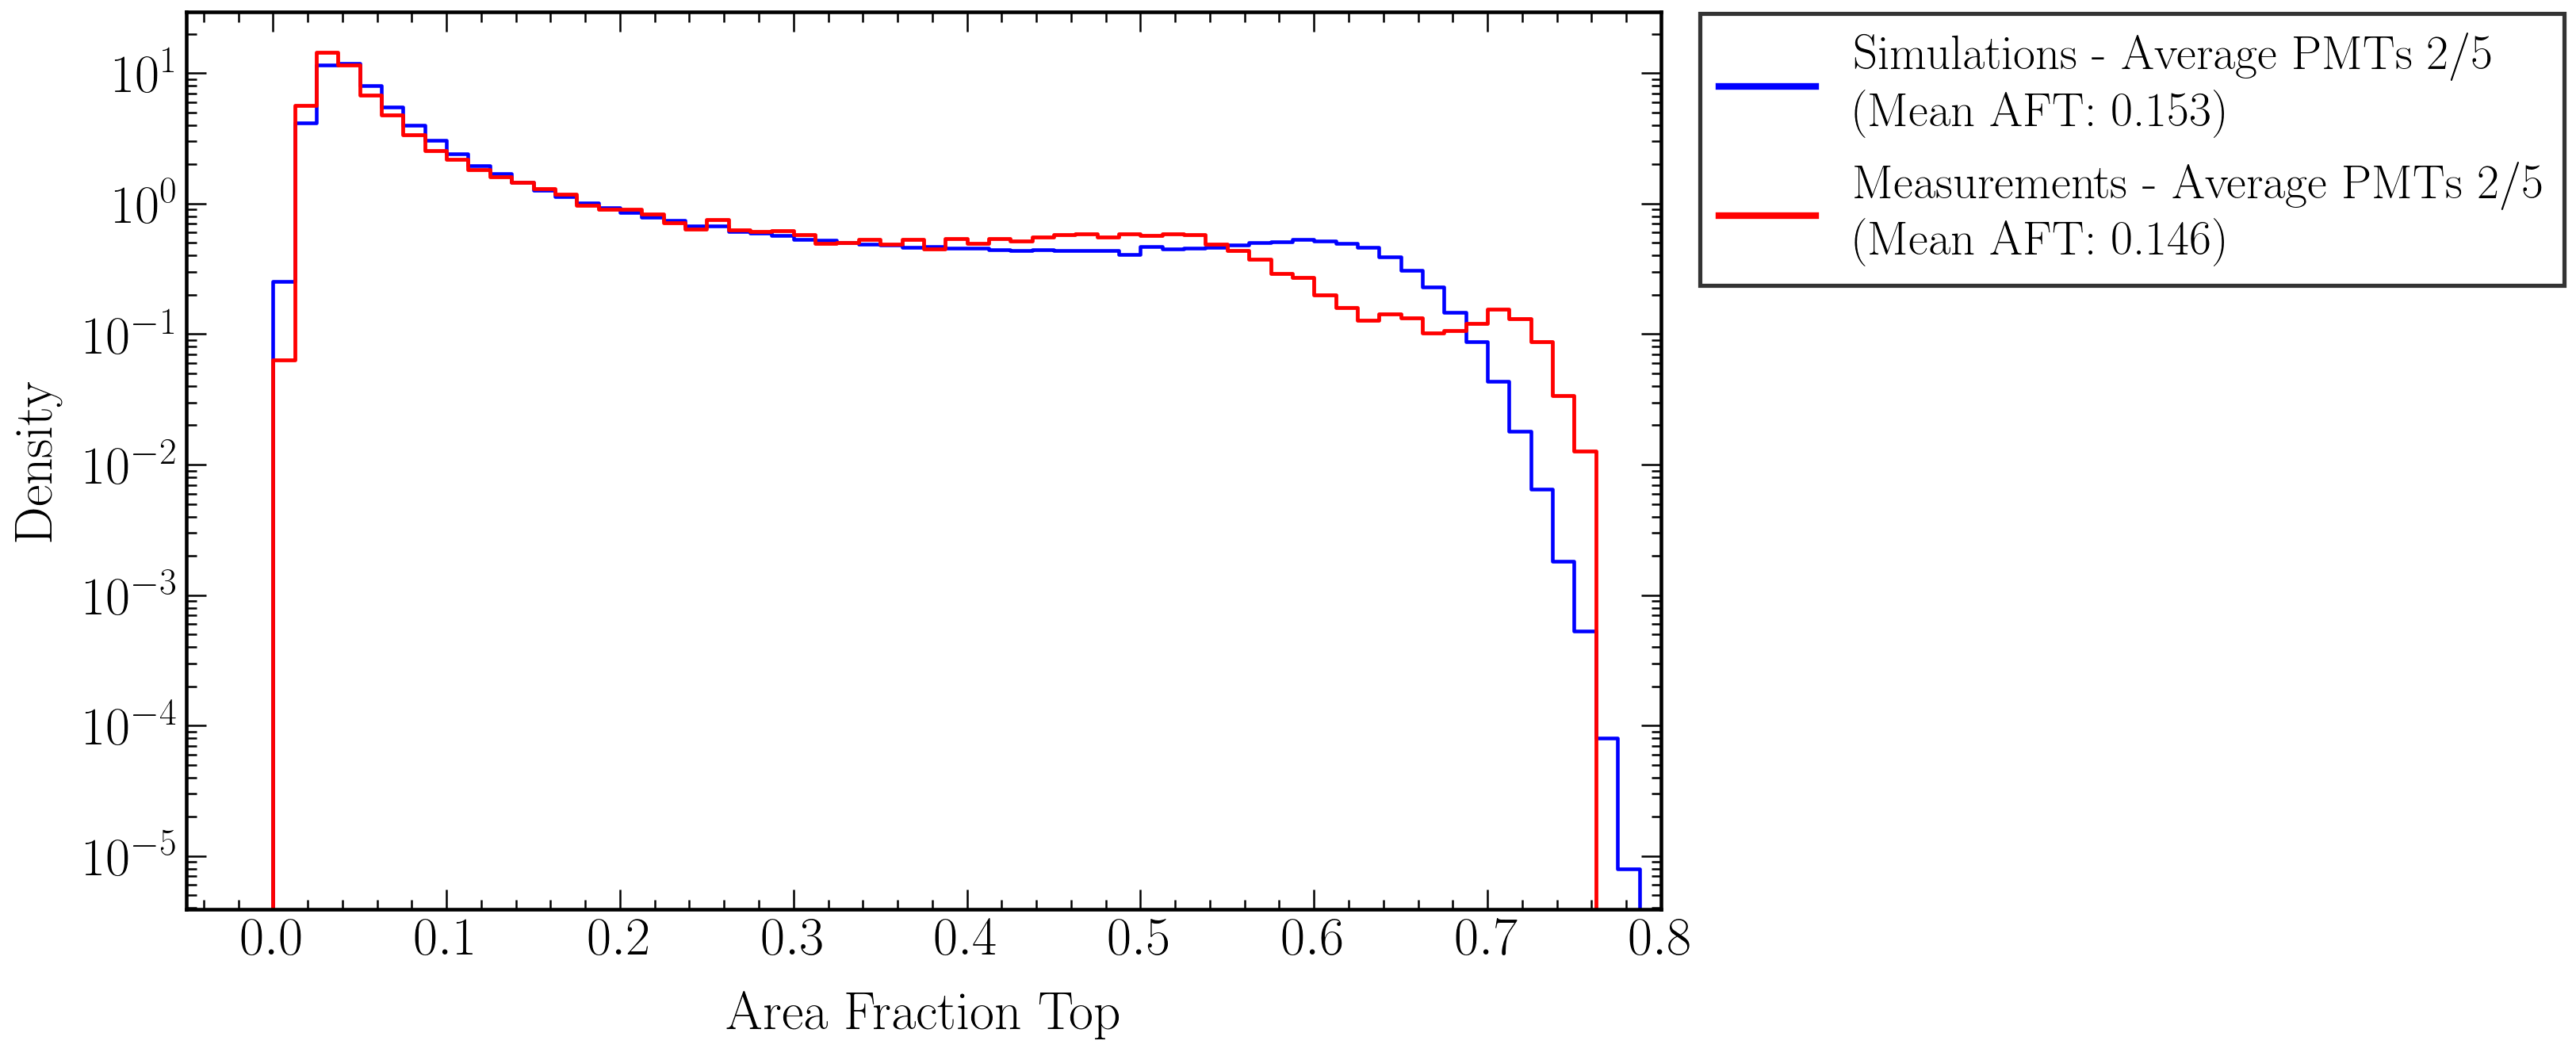

In [46]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT2']['hist_HF_bins_center'], df['PMT2']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'blue', 
         label = 'Simulations - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(2)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT2']['hist_HF_bins_center'], PMT25_HF_hist, where='mid', 
         linewidth = 2.3, color='red',
         label = 'Measurements - Average PMTs 2/5'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig(PMT25_HF_hist_mean, 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT2av_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()

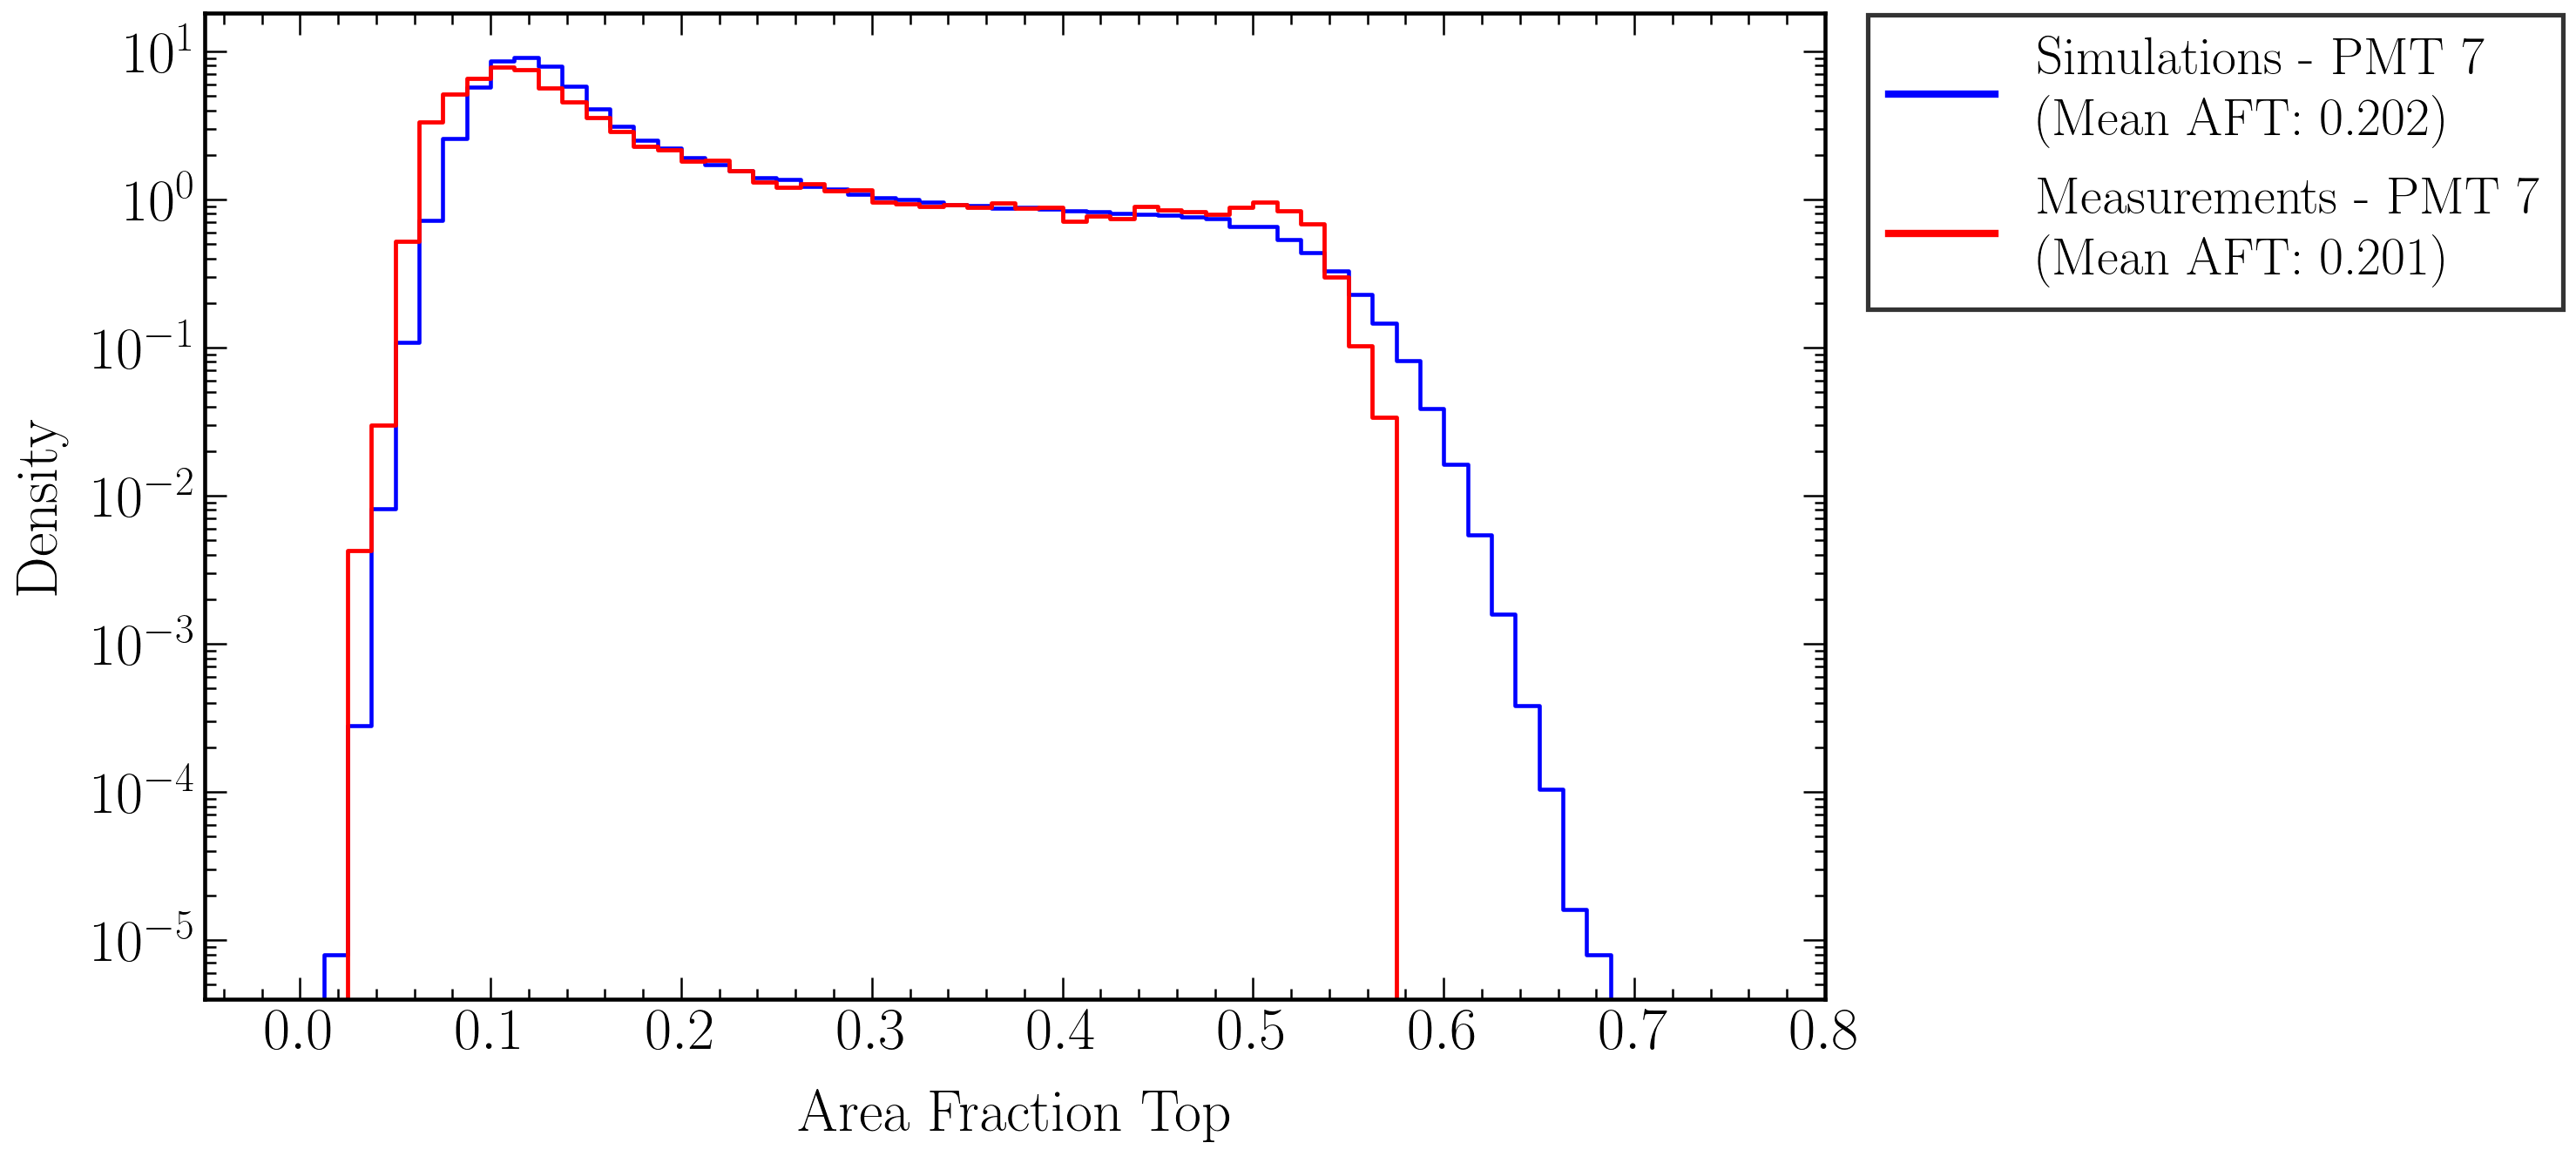

In [47]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.step(df['PMT7']['hist_HF_bins_center'], df['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.2, color = 'blue', 
         label = 'Simulations - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((_chunk_collect['pmthits_'+str(7)]/_chunk_collect['ntpmthits']).mean(), 3))+")")

plt.step(df_meas['PMT7']['hist_HF_bins_center'], df_meas['PMT7']['hist_HF_n'], where='mid', 
         linewidth = 2.3, color='red',
         label = 'Measurements - PMT 7'+"\n(Mean AFT: "+"{0:.3f}".format(
             round_sig((np.array(df_meas['PMT7']['HF'])).mean(), 3))+")")


plt.xlabel('Area Fraction Top', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('Tagged Kr-83m S2s', fontsize = title_size, pad = title_pad)

plt.xlim(-0.05,0.8)
plt.yscale('log')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_vs_"+filenameprefix_meas+"_AFT_PMT7_hist_scaled_fixedbinning_log.png", bbox_inches='tight')
plt.show()